## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


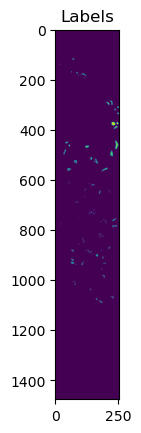

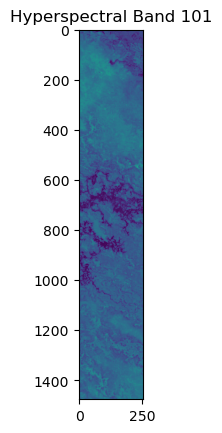

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(280, 5, 5, 145)
(70, 5, 5, 145)
(2898, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2200, PSNR: -8.3967


Epoch [1/50] Training Loss: 0.2125, PSNR: -8.7242
	[Val]   Batch [1/11] Loss: 0.2035, PSNR: -6.1228
	[Val]   Batch [10/11] Loss: 0.2036, PSNR: -8.3616
Epoch [1/50] Validation Loss: 0.2035, PSNR: -8.0536

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1985, PSNR: -9.3268


Epoch [2/50] Training Loss: 0.1901, PSNR: -8.3894
	[Val]   Batch [1/11] Loss: 0.1775, PSNR: -5.5286
	[Val]   Batch [10/11] Loss: 0.1777, PSNR: -7.7692
Epoch [2/50] Validation Loss: 0.1773, PSNR: -7.4562

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1768, PSNR: -8.9325


Epoch [3/50] Training Loss: 0.1689, PSNR: -7.7130
	[Val]   Batch [1/11] Loss: 0.1518, PSNR: -4.8489
	[Val]   Batch [10/11] Loss: 0.1519, PSNR: -7.0882
Epoch [3/50] Validation Loss: 0.1517, PSNR: -6.7779

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1555, PSNR: -7.3762


Epoch [4/50] Training Loss: 0.1484, PSNR: -7.2266
	[Val]   Batch [1/11] Loss: 0.1319, PSNR: -4.2403
	[Val]   Batch [10/11] Loss: 0.1320, PSNR: -6.4803
Epoch [4/50] Validation Loss: 0.1318, PSNR: -6.1685

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1356, PSNR: -7.3018


Epoch [5/50] Training Loss: 0.1291, PSNR: -6.5635
	[Val]   Batch [1/11] Loss: 0.1141, PSNR: -3.6086
	[Val]   Batch [10/11] Loss: 0.1141, PSNR: -5.8448
Epoch [5/50] Validation Loss: 0.1139, PSNR: -5.5345

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1165, PSNR: -5.9366


Epoch [6/50] Training Loss: 0.1116, PSNR: -6.0879
	[Val]   Batch [1/11] Loss: 0.0972, PSNR: -2.9123
	[Val]   Batch [10/11] Loss: 0.0971, PSNR: -5.1458
Epoch [6/50] Validation Loss: 0.0971, PSNR: -4.8381

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1001, PSNR: -4.3583


Epoch [7/50] Training Loss: 0.0962, PSNR: -5.3479
	[Val]   Batch [1/11] Loss: 0.0860, PSNR: -2.3841
	[Val]   Batch [10/11] Loss: 0.0860, PSNR: -4.6198
Epoch [7/50] Validation Loss: 0.0860, PSNR: -4.3117

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0880, PSNR: -4.0674


Epoch [8/50] Training Loss: 0.0830, PSNR: -4.8694
	[Val]   Batch [1/11] Loss: 0.0734, PSNR: -1.6927
	[Val]   Batch [10/11] Loss: 0.0734, PSNR: -3.9294
Epoch [8/50] Validation Loss: 0.0733, PSNR: -3.6195

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0752, PSNR: -3.7347


Epoch [9/50] Training Loss: 0.0717, PSNR: -3.8670
	[Val]   Batch [1/11] Loss: 0.0651, PSNR: -1.1751
	[Val]   Batch [10/11] Loss: 0.0651, PSNR: -3.4115
Epoch [9/50] Validation Loss: 0.0651, PSNR: -3.1034

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0642, PSNR: -2.6959


Epoch [10/50] Training Loss: 0.0622, PSNR: -3.4974
	[Val]   Batch [1/11] Loss: 0.0561, PSNR: -0.5229
	[Val]   Batch [10/11] Loss: 0.0561, PSNR: -2.7589
Epoch [10/50] Validation Loss: 0.0560, PSNR: -2.4513

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0579, PSNR: -4.4000


Epoch [11/50] Training Loss: 0.0543, PSNR: -2.9185
	[Val]   Batch [1/11] Loss: 0.0504, PSNR: -0.0596
	[Val]   Batch [10/11] Loss: 0.0504, PSNR: -2.2962
Epoch [11/50] Validation Loss: 0.0504, PSNR: -1.9889

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0497, PSNR: -4.3586


Epoch [12/50] Training Loss: 0.0478, PSNR: -2.5103
	[Val]   Batch [1/11] Loss: 0.0440, PSNR: 0.5263
	[Val]   Batch [10/11] Loss: 0.0440, PSNR: -1.7099
Epoch [12/50] Validation Loss: 0.0440, PSNR: -1.4029

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0435, PSNR: -2.2240


Epoch [13/50] Training Loss: 0.0422, PSNR: -1.8391
	[Val]   Batch [1/11] Loss: 0.0394, PSNR: 1.0035
	[Val]   Batch [10/11] Loss: 0.0394, PSNR: -1.2330
Epoch [13/50] Validation Loss: 0.0394, PSNR: -0.9266

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0392, PSNR: -1.3880


Epoch [14/50] Training Loss: 0.0376, PSNR: -1.2232
	[Val]   Batch [1/11] Loss: 0.0355, PSNR: 1.4647
	[Val]   Batch [10/11] Loss: 0.0355, PSNR: -0.7727
Epoch [14/50] Validation Loss: 0.0355, PSNR: -0.4654

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0354, PSNR: -3.0973


Epoch [15/50] Training Loss: 0.0337, PSNR: -0.9024
	[Val]   Batch [1/11] Loss: 0.0321, PSNR: 1.8926
	[Val]   Batch [10/11] Loss: 0.0322, PSNR: -0.3468
Epoch [15/50] Validation Loss: 0.0321, PSNR: -0.0380

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0316, PSNR: -1.9604


Epoch [16/50] Training Loss: 0.0304, PSNR: -0.4202
	[Val]   Batch [1/11] Loss: 0.0290, PSNR: 2.3463
	[Val]   Batch [10/11] Loss: 0.0290, PSNR: 0.1058
Epoch [16/50] Validation Loss: 0.0289, PSNR: 0.4155

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0286, PSNR: -1.8288


Epoch [17/50] Training Loss: 0.0275, PSNR: 0.0015
	[Val]   Batch [1/11] Loss: 0.0261, PSNR: 2.7965
	[Val]   Batch [10/11] Loss: 0.0261, PSNR: 0.5551
Epoch [17/50] Validation Loss: 0.0261, PSNR: 0.8656

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0256, PSNR: -1.0521


Epoch [18/50] Training Loss: 0.0250, PSNR: 0.6353
	[Val]   Batch [1/11] Loss: 0.0241, PSNR: 3.1505
	[Val]   Batch [10/11] Loss: 0.0241, PSNR: 0.9103
Epoch [18/50] Validation Loss: 0.0241, PSNR: 1.2192

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0240, PSNR: 0.3616


Epoch [19/50] Training Loss: 0.0229, PSNR: 0.9510
	[Val]   Batch [1/11] Loss: 0.0220, PSNR: 3.5367
	[Val]   Batch [10/11] Loss: 0.0220, PSNR: 1.2965
Epoch [19/50] Validation Loss: 0.0220, PSNR: 1.6055

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0219, PSNR: 3.5672


Epoch [20/50] Training Loss: 0.0210, PSNR: 1.3996
	[Val]   Batch [1/11] Loss: 0.0203, PSNR: 3.8901
	[Val]   Batch [10/11] Loss: 0.0203, PSNR: 1.6502
Epoch [20/50] Validation Loss: 0.0203, PSNR: 1.9594

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0196, PSNR: 0.6203


Epoch [21/50] Training Loss: 0.0193, PSNR: 1.6942
	[Val]   Batch [1/11] Loss: 0.0187, PSNR: 4.2549
	[Val]   Batch [10/11] Loss: 0.0187, PSNR: 2.0161
Epoch [21/50] Validation Loss: 0.0187, PSNR: 2.3246

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0185, PSNR: 2.7179


Epoch [22/50] Training Loss: 0.0179, PSNR: 1.8437
	[Val]   Batch [1/11] Loss: 0.0173, PSNR: 4.5827
	[Val]   Batch [10/11] Loss: 0.0173, PSNR: 2.3450
Epoch [22/50] Validation Loss: 0.0173, PSNR: 2.6534

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0167, PSNR: 4.7295


Epoch [23/50] Training Loss: 0.0165, PSNR: 2.2356
	[Val]   Batch [1/11] Loss: 0.0162, PSNR: 4.8772
	[Val]   Batch [10/11] Loss: 0.0162, PSNR: 2.6395
Epoch [23/50] Validation Loss: 0.0162, PSNR: 2.9490

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0154, PSNR: 3.7598


Epoch [24/50] Training Loss: 0.0154, PSNR: 2.6309
	[Val]   Batch [1/11] Loss: 0.0151, PSNR: 5.1815
	[Val]   Batch [10/11] Loss: 0.0151, PSNR: 2.9437
Epoch [24/50] Validation Loss: 0.0151, PSNR: 3.2539

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0151, PSNR: 1.7507


Epoch [25/50] Training Loss: 0.0144, PSNR: 2.8064
	[Val]   Batch [1/11] Loss: 0.0140, PSNR: 5.5088
	[Val]   Batch [10/11] Loss: 0.0140, PSNR: 3.2704
Epoch [25/50] Validation Loss: 0.0140, PSNR: 3.5806

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0140, PSNR: 5.5026


Epoch [26/50] Training Loss: 0.0134, PSNR: 2.9720
	[Val]   Batch [1/11] Loss: 0.0130, PSNR: 5.8132
	[Val]   Batch [10/11] Loss: 0.0130, PSNR: 3.5744
Epoch [26/50] Validation Loss: 0.0130, PSNR: 3.8849

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0128, PSNR: 5.8862


Epoch [27/50] Training Loss: 0.0126, PSNR: 3.5211
	[Val]   Batch [1/11] Loss: 0.0123, PSNR: 6.0499
	[Val]   Batch [10/11] Loss: 0.0123, PSNR: 3.8115
Epoch [27/50] Validation Loss: 0.0123, PSNR: 4.1211

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0117, PSNR: 2.8465


Epoch [28/50] Training Loss: 0.0118, PSNR: 3.7865
	[Val]   Batch [1/11] Loss: 0.0116, PSNR: 6.3357
	[Val]   Batch [10/11] Loss: 0.0116, PSNR: 4.0979
Epoch [28/50] Validation Loss: 0.0115, PSNR: 4.4074

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0109, PSNR: 4.1575


Epoch [29/50] Training Loss: 0.0111, PSNR: 4.1739
	[Val]   Batch [1/11] Loss: 0.0108, PSNR: 6.6225
	[Val]   Batch [10/11] Loss: 0.0108, PSNR: 4.3843
Epoch [29/50] Validation Loss: 0.0108, PSNR: 4.6949

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0105, PSNR: 3.9629


Epoch [30/50] Training Loss: 0.0104, PSNR: 4.0912
	[Val]   Batch [1/11] Loss: 0.0103, PSNR: 6.8357
	[Val]   Batch [10/11] Loss: 0.0103, PSNR: 4.5972
Epoch [30/50] Validation Loss: 0.0103, PSNR: 4.9079

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 7.0504


Epoch [31/50] Training Loss: 0.0098, PSNR: 4.4101
	[Val]   Batch [1/11] Loss: 0.0097, PSNR: 7.1030
	[Val]   Batch [10/11] Loss: 0.0097, PSNR: 4.8647
Epoch [31/50] Validation Loss: 0.0097, PSNR: 5.1756

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0095, PSNR: 4.2674


Epoch [32/50] Training Loss: 0.0093, PSNR: 4.8374
	[Val]   Batch [1/11] Loss: 0.0092, PSNR: 7.3415
	[Val]   Batch [10/11] Loss: 0.0092, PSNR: 5.1031
Epoch [32/50] Validation Loss: 0.0092, PSNR: 5.4141

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0092, PSNR: 5.4132


Epoch [33/50] Training Loss: 0.0088, PSNR: 5.0922
	[Val]   Batch [1/11] Loss: 0.0087, PSNR: 7.5493
	[Val]   Batch [10/11] Loss: 0.0087, PSNR: 5.3121
Epoch [33/50] Validation Loss: 0.0087, PSNR: 5.6217

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 5.2623


Epoch [34/50] Training Loss: 0.0084, PSNR: 5.3142
	[Val]   Batch [1/11] Loss: 0.0082, PSNR: 7.8267
	[Val]   Batch [10/11] Loss: 0.0082, PSNR: 5.5899
Epoch [34/50] Validation Loss: 0.0082, PSNR: 5.8999

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0079, PSNR: 5.1754


Epoch [35/50] Training Loss: 0.0079, PSNR: 5.6556
	[Val]   Batch [1/11] Loss: 0.0078, PSNR: 8.0382
	[Val]   Batch [10/11] Loss: 0.0078, PSNR: 5.8014
Epoch [35/50] Validation Loss: 0.0078, PSNR: 6.1116

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 6.2734


Epoch [36/50] Training Loss: 0.0075, PSNR: 5.7741
	[Val]   Batch [1/11] Loss: 0.0075, PSNR: 8.2342
	[Val]   Batch [10/11] Loss: 0.0075, PSNR: 5.9984
Epoch [36/50] Validation Loss: 0.0075, PSNR: 6.3079

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0070, PSNR: 6.9178


Epoch [37/50] Training Loss: 0.0072, PSNR: 6.0318
	[Val]   Batch [1/11] Loss: 0.0071, PSNR: 8.4687
	[Val]   Batch [10/11] Loss: 0.0071, PSNR: 6.2331
Epoch [37/50] Validation Loss: 0.0071, PSNR: 6.5424

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 4.4565


Epoch [38/50] Training Loss: 0.0068, PSNR: 5.9624
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6654
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.4308
Epoch [38/50] Validation Loss: 0.0067, PSNR: 6.7396

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 4.3213


Epoch [39/50] Training Loss: 0.0065, PSNR: 6.2922
	[Val]   Batch [1/11] Loss: 0.0064, PSNR: 8.8968
	[Val]   Batch [10/11] Loss: 0.0064, PSNR: 6.6612
Epoch [39/50] Validation Loss: 0.0064, PSNR: 6.9715

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0063, PSNR: 6.5696


Epoch [40/50] Training Loss: 0.0062, PSNR: 6.6156
	[Val]   Batch [1/11] Loss: 0.0061, PSNR: 9.0744
	[Val]   Batch [10/11] Loss: 0.0061, PSNR: 6.8391
Epoch [40/50] Validation Loss: 0.0061, PSNR: 7.1499

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0059, PSNR: 7.9410


Epoch [41/50] Training Loss: 0.0059, PSNR: 6.6528
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2288
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 6.9939
Epoch [41/50] Validation Loss: 0.0059, PSNR: 7.3049

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 5.2200


Epoch [42/50] Training Loss: 0.0057, PSNR: 6.9854
	[Val]   Batch [1/11] Loss: 0.0056, PSNR: 9.4529
	[Val]   Batch [10/11] Loss: 0.0056, PSNR: 7.2186
Epoch [42/50] Validation Loss: 0.0056, PSNR: 7.5295

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 8.0394


Epoch [43/50] Training Loss: 0.0054, PSNR: 7.2006
	[Val]   Batch [1/11] Loss: 0.0054, PSNR: 9.6637
	[Val]   Batch [10/11] Loss: 0.0054, PSNR: 7.4302
Epoch [43/50] Validation Loss: 0.0054, PSNR: 7.7405

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0054, PSNR: 6.6993


Epoch [44/50] Training Loss: 0.0052, PSNR: 7.1868
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.8244
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5915
Epoch [44/50] Validation Loss: 0.0052, PSNR: 7.9007

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 8.3082


Epoch [45/50] Training Loss: 0.0050, PSNR: 7.7135
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 10.0126
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7800
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.0885

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 6.6600


Epoch [46/50] Training Loss: 0.0048, PSNR: 7.7618
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2057
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 7.9724
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.2817

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 6.2364


Epoch [47/50] Training Loss: 0.0046, PSNR: 7.7874
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3668
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.1332
Epoch [47/50] Validation Loss: 0.0046, PSNR: 8.4429

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 7.0380


Epoch [48/50] Training Loss: 0.0044, PSNR: 8.0443
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5645
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.3306
Epoch [48/50] Validation Loss: 0.0044, PSNR: 8.6407

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0045, PSNR: 7.0423


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.1066
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7283
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.4948
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.8045

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 6.2325


Epoch [50/50] Training Loss: 0.0041, PSNR: 8.2114
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8850
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.6522
Epoch [50/50] Validation Loss: 0.0040, PSNR: 8.9618


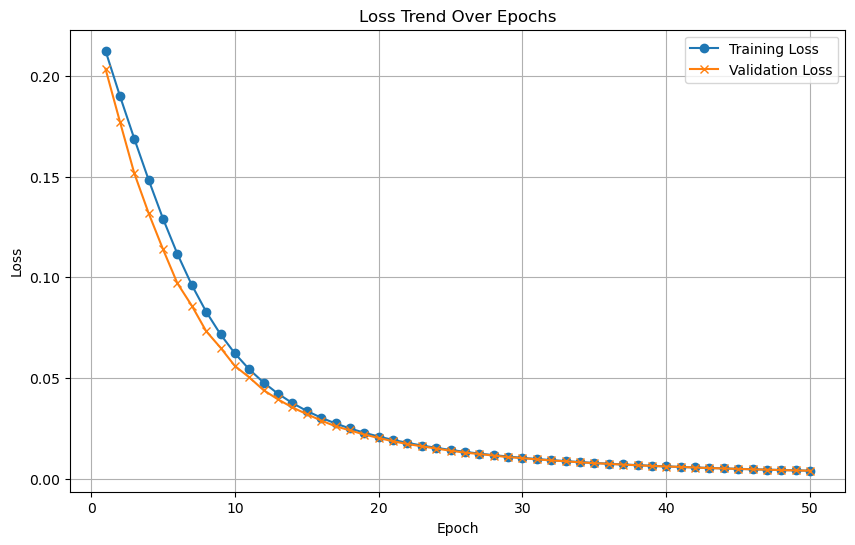

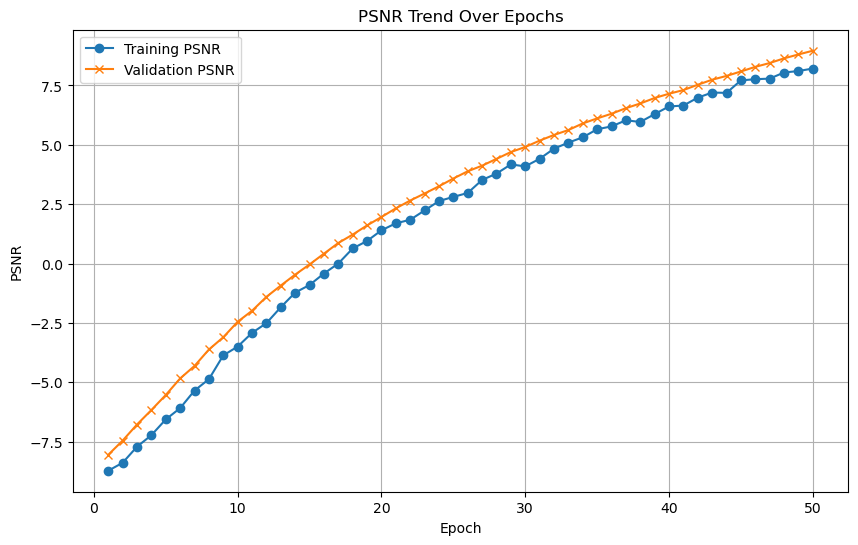

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6533
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6426. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6086
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5855
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5563
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss improved from 2.6426 to 2.6426. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.54

Epoch [17/1000] completed, Average Training Loss: 2.3673
    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 7.14%
Validation loss improved from 2.6419 to 2.6418. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3545
    Validation Batch [1/1], Loss: 2.6417
Validation Loss: 2.6417, Validation Accuracy: 7.14%
Validation loss improved from 2.6418 to 2.6417. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3571
    Validation Batch [1/1], Loss: 2.6417
Validation Loss: 2.6417, Validation Accuracy: 7.14%
Validation loss improved from 2.6417 to 2.6417. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.3499
    Validation Batch [1/1], Loss: 2.6415
Validation Loss: 2.6415, Validation Accuracy: 7.14%
Validation loss improved from 2.6417 to 2.6415. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/10

Epoch [23/1000] completed, Average Training Loss: 2.3157
    Validation Batch [1/1], Loss: 2.6411
Validation Loss: 2.6411, Validation Accuracy: 7.14%
Validation loss improved from 2.6412 to 2.6411. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2872
    Validation Batch [1/1], Loss: 2.6410
Validation Loss: 2.6410, Validation Accuracy: 7.14%
Validation loss improved from 2.6411 to 2.6410. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2926
    Validation Batch [1/1], Loss: 2.6409
Validation Loss: 2.6409, Validation Accuracy: 7.14%
Validation loss improved from 2.6410 to 2.6409. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2567
    Validation Batch [1/1], Loss: 2.6408
Validation Loss: 2.6408, Validation Accuracy: 7.14%
Validation loss improved from 2.6409 to 2.6408. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/10

Validation Loss: 2.6335, Validation Accuracy: 7.14%
Validation loss improved from 2.6346 to 2.6335. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.1461
    Validation Batch [1/1], Loss: 2.6324
Validation Loss: 2.6324, Validation Accuracy: 7.14%
Validation loss improved from 2.6335 to 2.6324. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.1255
    Validation Batch [1/1], Loss: 2.6312
Validation Loss: 2.6312, Validation Accuracy: 7.14%
Validation loss improved from 2.6324 to 2.6312. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.1240
    Validation Batch [1/1], Loss: 2.6301
Validation Loss: 2.6301, Validation Accuracy: 7.14%
Validation loss improved from 2.6312 to 2.6301. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.0989
    Validation Batch [1/1], Loss: 2.6290
Validation L

Epoch [47/1000] completed, Average Training Loss: 2.0639
    Validation Batch [1/1], Loss: 2.6218
Validation Loss: 2.6218, Validation Accuracy: 7.14%
Validation loss improved from 2.6236 to 2.6218. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 2.0354
    Validation Batch [1/1], Loss: 2.6191
Validation Loss: 2.6191, Validation Accuracy: 7.14%
Validation loss improved from 2.6218 to 2.6191. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.0360
    Validation Batch [1/1], Loss: 2.6153
Validation Loss: 2.6153, Validation Accuracy: 7.14%
Validation loss improved from 2.6191 to 2.6153. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.0463
    Validation Batch [1/1], Loss: 2.6112
Validation Loss: 2.6112, Validation Accuracy: 7.14%
Validation loss improved from 2.6153 to 2.6112. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/10

Epoch [61/1000] completed, Average Training Loss: 1.9278
    Validation Batch [1/1], Loss: 2.5240
Validation Loss: 2.5240, Validation Accuracy: 18.57%
Validation loss improved from 2.5369 to 2.5240. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.9108
    Validation Batch [1/1], Loss: 2.5070
Validation Loss: 2.5070, Validation Accuracy: 18.57%
Validation loss improved from 2.5240 to 2.5070. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.9097
    Validation Batch [1/1], Loss: 2.4911
Validation Loss: 2.4911, Validation Accuracy: 18.57%
Validation loss improved from 2.5070 to 2.4911. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.8920
    Validation Batch [1/1], Loss: 2.4773
Validation Loss: 2.4773, Validation Accuracy: 22.86%
Validation loss improved from 2.4911 to 2.4773. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [6

Epoch [69/1000] completed, Average Training Loss: 1.8429
    Validation Batch [1/1], Loss: 2.3761
Validation Loss: 2.3761, Validation Accuracy: 42.86%
Validation loss improved from 2.3978 to 2.3761. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.8182
    Validation Batch [1/1], Loss: 2.3566
Validation Loss: 2.3566, Validation Accuracy: 40.00%
Validation loss improved from 2.3761 to 2.3566. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.8190
    Validation Batch [1/1], Loss: 2.3356
Validation Loss: 2.3356, Validation Accuracy: 44.29%
Validation loss improved from 2.3566 to 2.3356. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.8079
    Validation Batch [1/1], Loss: 2.3113
Validation Loss: 2.3113, Validation Accuracy: 48.57%
Validation loss improved from 2.3356 to 2.3113. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 1.9783
Validation Loss: 1.9783, Validation Accuracy: 58.57%
Validation loss improved from 2.0076 to 1.9783. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.6967
    Validation Batch [1/1], Loss: 1.9490
Validation Loss: 1.9490, Validation Accuracy: 58.57%
Validation loss improved from 1.9783 to 1.9490. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.6718
    Validation Batch [1/1], Loss: 1.9161
Validation Loss: 1.9161, Validation Accuracy: 60.00%
Validation loss improved from 1.9490 to 1.9161. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.6799
    Validation Batch [1/1], Loss: 1.8844
Validation Loss: 1.8844, Validation Accuracy: 60.00%
Validation loss improved from 1.9161 to 1.8844. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.6409
    Vali

Epoch [92/1000] completed, Average Training Loss: 1.6168
    Validation Batch [1/1], Loss: 1.7705
Validation Loss: 1.7705, Validation Accuracy: 60.00%
Validation loss improved from 1.7964 to 1.7705. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.6265
    Validation Batch [1/1], Loss: 1.7553
Validation Loss: 1.7553, Validation Accuracy: 62.86%
Validation loss improved from 1.7705 to 1.7553. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.5953
    Validation Batch [1/1], Loss: 1.7309
Validation Loss: 1.7309, Validation Accuracy: 64.29%
Validation loss improved from 1.7553 to 1.7309. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.6045
    Validation Batch [1/1], Loss: 1.7131
Validation Loss: 1.7131, Validation Accuracy: 61.43%
Validation loss improved from 1.7309 to 1.7131. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [9

Epoch [107/1000] completed, Average Training Loss: 1.4761
    Validation Batch [1/1], Loss: 1.5622
Validation Loss: 1.5622, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.4537
    Validation Batch [1/1], Loss: 1.5166
Validation Loss: 1.5166, Validation Accuracy: 71.43%
Validation loss improved from 1.5539 to 1.5166. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.4449
    Validation Batch [1/1], Loss: 1.5008
Validation Loss: 1.5008, Validation Accuracy: 74.29%
Validation loss improved from 1.5166 to 1.5008. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.4549
    Validation Batch [1/1], Loss: 1.4986
Validation Loss: 1.4986, Validation Accuracy: 78.57%
Validation loss improved from 1.5008 to 1.4986. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000

Epoch [114/1000] completed, Average Training Loss: 1.3903
    Validation Batch [1/1], Loss: 1.4483
Validation Loss: 1.4483, Validation Accuracy: 75.71%
Validation loss improved from 1.4589 to 1.4483. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.3993
    Validation Batch [1/1], Loss: 1.4357
Validation Loss: 1.4357, Validation Accuracy: 72.86%
Validation loss improved from 1.4483 to 1.4357. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.3872
    Validation Batch [1/1], Loss: 1.4200
Validation Loss: 1.4200, Validation Accuracy: 72.86%
Validation loss improved from 1.4357 to 1.4200. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.3358
    Validation Batch [1/1], Loss: 1.4202
Validation Loss: 1.4202, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000

Epoch [130/1000] completed, Average Training Loss: 1.2763
    Validation Batch [1/1], Loss: 1.2888
Validation Loss: 1.2888, Validation Accuracy: 77.14%
Validation loss improved from 1.3063 to 1.2888. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.2458
    Validation Batch [1/1], Loss: 1.2677
Validation Loss: 1.2677, Validation Accuracy: 77.14%
Validation loss improved from 1.2888 to 1.2677. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.2359
    Validation Batch [1/1], Loss: 1.2652
Validation Loss: 1.2652, Validation Accuracy: 75.71%
Validation loss improved from 1.2677 to 1.2652. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.2041
    Validation Batch [1/1], Loss: 1.2657
Validation Loss: 1.2657, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000


LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.2012
    Validation Batch [1/1], Loss: 1.2245
Validation Loss: 1.2245, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.1722
    Validation Batch [1/1], Loss: 1.2060
Validation Loss: 1.2060, Validation Accuracy: 77.14%
Validation loss improved from 1.2223 to 1.2060. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.1758
    Validation Batch [1/1], Loss: 1.2007
Validation Loss: 1.2007, Validation Accuracy: 75.71%
Validation loss improved from 1.2060 to 1.2007. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.1947
    Validation Batch [1/1], Loss: 1.2055
Validation Loss: 1.2055, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Train

Epoch [153/1000] completed, Average Training Loss: 1.0481
    Validation Batch [1/1], Loss: 1.1013
Validation Loss: 1.1013, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.0404
    Validation Batch [1/1], Loss: 1.0877
Validation Loss: 1.0877, Validation Accuracy: 77.14%
Validation loss improved from 1.0925 to 1.0877. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.0432
    Validation Batch [1/1], Loss: 1.0817
Validation Loss: 1.0817, Validation Accuracy: 77.14%
Validation loss improved from 1.0877 to 1.0817. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.0366
    Validation Batch [1/1], Loss: 1.1010
Validation Loss: 1.1010, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Av

Epoch [159/1000] completed, Average Training Loss: 1.0002
    Validation Batch [1/1], Loss: 1.0572
Validation Loss: 1.0572, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 0.9884
    Validation Batch [1/1], Loss: 1.0507
Validation Loss: 1.0507, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 1.0084
    Validation Batch [1/1], Loss: 1.0290
Validation Loss: 1.0290, Validation Accuracy: 78.57%
Validation loss improved from 1.0474 to 1.0290. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.9932
    Validation Batch [1/1], Loss: 1.0224
Validation Loss: 1.0224, Validation Accuracy: 80.00%
Validation loss improved from 1.0290 to 1.0224. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Av

Epoch [176/1000] completed, Average Training Loss: 0.9162
    Validation Batch [1/1], Loss: 0.9360
Validation Loss: 0.9360, Validation Accuracy: 85.71%
Validation loss improved from 0.9392 to 0.9360. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.8724
    Validation Batch [1/1], Loss: 0.9417
Validation Loss: 0.9417, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.8733
    Validation Batch [1/1], Loss: 0.9675
Validation Loss: 0.9675, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.8921
    Validation Batch [1/1], Loss: 0.9129
Validation Loss: 0.9129, Validation Accuracy: 80.00%
Validation loss improved from 0.9360 to 0.9129. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Av

Epoch [182/1000] completed, Average Training Loss: 0.8480
    Validation Batch [1/1], Loss: 0.8936
Validation Loss: 0.8936, Validation Accuracy: 82.86%
Validation loss improved from 0.8993 to 0.8936. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.8335
    Validation Batch [1/1], Loss: 0.8939
Validation Loss: 0.8939, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.8402
    Validation Batch [1/1], Loss: 0.8793
Validation Loss: 0.8793, Validation Accuracy: 88.57%
Validation loss improved from 0.8936 to 0.8793. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.8255
    Validation Batch [1/1], Loss: 0.8692
Validation Loss: 0.8692, Validation Accuracy: 85.71%
Validation loss improved from 0.8793 to 0.8692. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000

    Validation Batch [1/1], Loss: 0.7810
Validation Loss: 0.7810, Validation Accuracy: 88.57%
Validation loss improved from 0.7990 to 0.7810. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.7660
    Validation Batch [1/1], Loss: 0.7899
Validation Loss: 0.7899, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.7380
    Validation Batch [1/1], Loss: 0.8013
Validation Loss: 0.8013, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.7257
    Validation Batch [1/1], Loss: 0.7765
Validation Loss: 0.7765, Validation Accuracy: 85.71%
Validation loss improved from 0.7810 to 0.7765. Saving model...

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.7144
    Validation Batch [1/1], Lo

Epoch [204/1000] completed, Average Training Loss: 0.7051
    Validation Batch [1/1], Loss: 0.7745
Validation Loss: 0.7745, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.7273
    Validation Batch [1/1], Loss: 0.8586
Validation Loss: 0.8586, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.7012
    Validation Batch [1/1], Loss: 0.7574
Validation Loss: 0.7574, Validation Accuracy: 88.57%
Validation loss improved from 0.7699 to 0.7574. Saving model...

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.7039
    Validation Batch [1/1], Loss: 0.7367
Validation Loss: 0.7367, Validation Accuracy: 87.14%
Validation loss improved from 0.7574 to 0.7367. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Av

Validation Loss: 0.6791, Validation Accuracy: 90.00%
Validation loss improved from 0.6971 to 0.6791. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.6000
    Validation Batch [1/1], Loss: 0.6719
Validation Loss: 0.6719, Validation Accuracy: 90.00%
Validation loss improved from 0.6791 to 0.6719. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.6111
    Validation Batch [1/1], Loss: 0.7216
Validation Loss: 0.7216, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.6052
    Validation Batch [1/1], Loss: 0.7182
Validation Loss: 0.7182, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.5921
    Validation Batch [1/1], Loss: 0.7187
Validation Loss: 0.7187, Valid

Epoch [225/1000] completed, Average Training Loss: 0.6212
    Validation Batch [1/1], Loss: 0.6984
Validation Loss: 0.6984, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.6085
    Validation Batch [1/1], Loss: 0.6891
Validation Loss: 0.6891, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.5826
    Validation Batch [1/1], Loss: 0.6721
Validation Loss: 0.6721, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.5624
    Validation Batch [1/1], Loss: 0.6630
Validation Loss: 0.6630, Validation Accuracy: 87.14%
Validation loss improved from 0.6719 to 0.6630. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training 

Epoch [243/1000] completed, Average Training Loss: 0.5112
    Validation Batch [1/1], Loss: 0.6028
Validation Loss: 0.6028, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.5053
    Validation Batch [1/1], Loss: 0.6023
Validation Loss: 0.6023, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.5048
    Validation Batch [1/1], Loss: 0.5870
Validation Loss: 0.5870, Validation Accuracy: 91.43%
Validation loss improved from 0.5885 to 0.5870. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.5142
    Validation Batch [1/1], Loss: 0.5695
Validation Loss: 0.5695, Validation Accuracy: 94.29%
Validation loss improved from 0.5870 to 0.5695. Saving model...

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Av

Epoch [249/1000] completed, Average Training Loss: 0.5071
    Validation Batch [1/1], Loss: 0.6361
Validation Loss: 0.6361, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.4725
    Validation Batch [1/1], Loss: 0.5862
Validation Loss: 0.5862, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.4801
    Validation Batch [1/1], Loss: 0.5566
Validation Loss: 0.5566, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.4493
    Validation Batch [1/1], Loss: 0.5657
Validation Loss: 0.5657, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.4582
  

Epoch [266/1000] completed, Average Training Loss: 0.4151
    Validation Batch [1/1], Loss: 0.4878
Validation Loss: 0.4878, Validation Accuracy: 94.29%
Validation loss improved from 0.4952 to 0.4878. Saving model...

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.4109
    Validation Batch [1/1], Loss: 0.4729
Validation Loss: 0.4729, Validation Accuracy: 95.71%
Validation loss improved from 0.4878 to 0.4729. Saving model...

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.4179
    Validation Batch [1/1], Loss: 0.5032
Validation Loss: 0.5032, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.4002
    Validation Batch [1/1], Loss: 0.5170
Validation Loss: 0.5170, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Av

Epoch [272/1000] completed, Average Training Loss: 0.4012
    Validation Batch [1/1], Loss: 0.4806
Validation Loss: 0.4806, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.3906
    Validation Batch [1/1], Loss: 0.5134
Validation Loss: 0.5134, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.3810
    Validation Batch [1/1], Loss: 0.4834
Validation Loss: 0.4834, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.3621
    Validation Batch [1/1], Loss: 0.4322
Validation Loss: 0.4322, Validation Accuracy: 94.29%
Validation loss improved from 0.4729 to 0.4322. Saving model...

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training 

Epoch [290/1000] completed, Average Training Loss: 0.3347
    Validation Batch [1/1], Loss: 0.3946
Validation Loss: 0.3946, Validation Accuracy: 95.71%
Validation loss improved from 0.3960 to 0.3946. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.3114
    Validation Batch [1/1], Loss: 0.4066
Validation Loss: 0.4066, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.3187
    Validation Batch [1/1], Loss: 0.4421
Validation Loss: 0.4421, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.3098
    Validation Batch [1/1], Loss: 0.4049
Validation Loss: 0.4049, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training 

Epoch [295/1000] completed, Average Training Loss: 0.3237
    Validation Batch [1/1], Loss: 0.3743
Validation Loss: 0.3743, Validation Accuracy: 97.14%
Validation loss improved from 0.3843 to 0.3743. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.3038
    Validation Batch [1/1], Loss: 0.4032
Validation Loss: 0.4032, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.3380
    Validation Batch [1/1], Loss: 0.4150
Validation Loss: 0.4150, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.3002
    Validation Batch [1/1], Loss: 0.4046
Validation Loss: 0.4046, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training 

Epoch [312/1000] completed, Average Training Loss: 0.2689
    Validation Batch [1/1], Loss: 0.3384
Validation Loss: 0.3384, Validation Accuracy: 95.71%
Validation loss improved from 0.3412 to 0.3384. Saving model...

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.2658
    Validation Batch [1/1], Loss: 0.3597
Validation Loss: 0.3597, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.2588
    Validation Batch [1/1], Loss: 0.3800
Validation Loss: 0.3800, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.2829
    Validation Batch [1/1], Loss: 0.3872
Validation Loss: 0.3872, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training 

Epoch [317/1000] completed, Average Training Loss: 0.2604
    Validation Batch [1/1], Loss: 0.3471
Validation Loss: 0.3471, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.2511
    Validation Batch [1/1], Loss: 0.3592
Validation Loss: 0.3592, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.2477
    Validation Batch [1/1], Loss: 0.3999
Validation Loss: 0.3999, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.2398
    Validation Batch [1/1], Loss: 0.3770
Validation Loss: 0.3770, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.2611
  

Epoch [335/1000] completed, Average Training Loss: 0.2219
    Validation Batch [1/1], Loss: 0.3139
Validation Loss: 0.3139, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.2227
    Validation Batch [1/1], Loss: 0.3094
Validation Loss: 0.3094, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.2229
    Validation Batch [1/1], Loss: 0.2914
Validation Loss: 0.2914, Validation Accuracy: 95.71%
Validation loss improved from 0.2937 to 0.2914. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2269
    Validation Batch [1/1], Loss: 0.2986
Validation Loss: 0.2986, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training 

Epoch [340/1000] completed, Average Training Loss: 0.2096
    Validation Batch [1/1], Loss: 0.3203
Validation Loss: 0.3203, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2052
    Validation Batch [1/1], Loss: 0.3305
Validation Loss: 0.3305, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.2295
    Validation Batch [1/1], Loss: 0.3202
Validation Loss: 0.3202, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2183
    Validation Batch [1/1], Loss: 0.2781
Validation Loss: 0.2781, Validation Accuracy: 95.71%
Validation loss improved from 0.2914 to 0.2781. Saving model...

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training 

Epoch [358/1000] completed, Average Training Loss: 0.1980
    Validation Batch [1/1], Loss: 0.3025
Validation Loss: 0.3025, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.1930
    Validation Batch [1/1], Loss: 0.2699
Validation Loss: 0.2699, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.1748
    Validation Batch [1/1], Loss: 0.2720
Validation Loss: 0.2720, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.1753
    Validation Batch [1/1], Loss: 0.2900
Validation Loss: 0.2900, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.178

Epoch [364/1000] completed, Average Training Loss: 0.1846
    Validation Batch [1/1], Loss: 0.2447
Validation Loss: 0.2447, Validation Accuracy: 95.71%
Validation loss improved from 0.2655 to 0.2447. Saving model...

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1843
    Validation Batch [1/1], Loss: 0.2224
Validation Loss: 0.2224, Validation Accuracy: 97.14%
Validation loss improved from 0.2447 to 0.2224. Saving model...

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1829
    Validation Batch [1/1], Loss: 0.2333
Validation Loss: 0.2333, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1891
    Validation Batch [1/1], Loss: 0.3069
Validation Loss: 0.3069, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Av

    Validation Batch [1/1], Loss: 0.2329
Validation Loss: 0.2329, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.1472
    Validation Batch [1/1], Loss: 0.2387
Validation Loss: 0.2387, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.1534
    Validation Batch [1/1], Loss: 0.2233
Validation Loss: 0.2233, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.1544
    Validation Batch [1/1], Loss: 0.2088
Validation Loss: 0.2088, Validation Accuracy: 97.14%
Validation loss improved from 0.2206 to 0.2088. Saving model...

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.1620
    Validation Batch [1/1], Loss: 0.2241
Vali

Epoch [386/1000] completed, Average Training Loss: 0.1470
    Validation Batch [1/1], Loss: 0.2220
Validation Loss: 0.2220, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.1565
    Validation Batch [1/1], Loss: 0.2495
Validation Loss: 0.2495, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1460
    Validation Batch [1/1], Loss: 0.2538
Validation Loss: 0.2538, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1479
    Validation Batch [1/1], Loss: 0.2359
Validation Loss: 0.2359, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1501
  

Epoch [403/1000] completed, Average Training Loss: 0.1418
    Validation Batch [1/1], Loss: 0.2627
Validation Loss: 0.2627, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1377
    Validation Batch [1/1], Loss: 0.2569
Validation Loss: 0.2569, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.1191
    Validation Batch [1/1], Loss: 0.2198
Validation Loss: 0.2198, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1358
    Validation Batch [1/1], Loss: 0.1946
Validation Loss: 0.1946, Validation Accuracy: 97.14%
Validation loss improved from 0.2061 to 0.1946. Saving model...

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training

Epoch [410/1000] completed, Average Training Loss: 0.1397
    Validation Batch [1/1], Loss: 0.2553
Validation Loss: 0.2553, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1267
    Validation Batch [1/1], Loss: 0.2268
Validation Loss: 0.2268, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1233
    Validation Batch [1/1], Loss: 0.2111
Validation Loss: 0.2111, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1312
    Validation Batch [1/1], Loss: 0.2288
Validation Loss: 0.2288, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1216
  

Epoch [423/1000] completed, Average Training Loss: 0.1276
    Validation Batch [1/1], Loss: 0.1921
Validation Loss: 0.1921, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1206
    Validation Batch [1/1], Loss: 0.1924
Validation Loss: 0.1924, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1121
    Validation Batch [1/1], Loss: 0.2222
Validation Loss: 0.2222, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1044
    Validation Batch [1/1], Loss: 0.2745
Validation Loss: 0.2745, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1126
  

Epoch [445/1000] completed, Average Training Loss: 0.1137
    Validation Batch [1/1], Loss: 0.1954
Validation Loss: 0.1954, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.2024
Validation Loss: 0.2024, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.0950
    Validation Batch [1/1], Loss: 0.2140
Validation Loss: 0.2140, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1046
    Validation Batch [1/1], Loss: 0.2165
Validation Loss: 0.2165, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.0986

    Validation Batch [1/1], Loss: 0.1772
Validation Loss: 0.1772, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0867
    Validation Batch [1/1], Loss: 0.2037
Validation Loss: 0.2037, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.2324
Validation Loss: 0.2324, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.0855
    Validation Batch [1/1], Loss: 0.2057
Validation Loss: 0.2057, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.0827
    Validation Batch [1/1], Loss: 0.1972
Validation Loss

Epoch [491/1000] completed, Average Training Loss: 0.0698
    Validation Batch [1/1], Loss: 0.2312
Validation Loss: 0.2312, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0766
    Validation Batch [1/1], Loss: 0.2062
Validation Loss: 0.2062, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.1948
Validation Loss: 0.1948, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0721
    Validation Batch [1/1], Loss: 0.1800
Validation Loss: 0.1800, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0653
  

Epoch [513/1000] completed, Average Training Loss: 0.0730
    Validation Batch [1/1], Loss: 0.1736
Validation Loss: 0.1736, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0659
    Validation Batch [1/1], Loss: 0.1914
Validation Loss: 0.1914, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.1980
Validation Loss: 0.1980, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0597
    Validation Batch [1/1], Loss: 0.1878
Validation Loss: 0.1878, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0654

Epoch [536/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.1098
Validation Loss: 0.1098, Validation Accuracy: 97.14%
Validation loss improved from 0.1207 to 0.1098. Saving model...

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0586
    Validation Batch [1/1], Loss: 0.1157
Validation Loss: 0.1157, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0635
    Validation Batch [1/1], Loss: 0.1566
Validation Loss: 0.1566, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.2073
Validation Loss: 0.2073, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training 

Epoch [558/1000] completed, Average Training Loss: 0.0636
    Validation Batch [1/1], Loss: 0.1422
Validation Loss: 0.1422, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.1451
Validation Loss: 0.1451, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.1684
Validation Loss: 0.1684, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0610
    Validation Batch [1/1], Loss: 0.1560
Validation Loss: 0.1560, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.052

Epoch [581/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.1492
Validation Loss: 0.1492, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.1379
Validation Loss: 0.1379, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0496
    Validation Batch [1/1], Loss: 0.1373
Validation Loss: 0.1373, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0481
    Validation Batch [1/1], Loss: 0.1457
Validation Loss: 0.1457, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.051

Epoch [604/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.1237
Validation Loss: 0.1237, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0426
    Validation Batch [1/1], Loss: 0.1098
Validation Loss: 0.1098, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.1161
Validation Loss: 0.1161, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0465
    Validation Batch [1/1], Loss: 0.1402
Validation Loss: 0.1402, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.045

    Validation Batch [1/1], Loss: 0.2057
Validation Loss: 0.2057, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.1791
Validation Loss: 0.1791, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.1541
Validation Loss: 0.1541, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.1491
Validation Loss: 0.1491, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.1556
Validation Loss

Epoch [648/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.1165
Validation Loss: 0.1165, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0360
    Validation Batch [1/1], Loss: 0.1317
Validation Loss: 0.1317, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0390
    Validation Batch [1/1], Loss: 0.1481
Validation Loss: 0.1481, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0406
    Validation Batch [1/1], Loss: 0.1573
Validation Loss: 0.1573, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.0336
  

Epoch [671/1000] completed, Average Training Loss: 0.0370
    Validation Batch [1/1], Loss: 0.1243
Validation Loss: 0.1243, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.1166
Validation Loss: 0.1166, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0404
    Validation Batch [1/1], Loss: 0.1099
Validation Loss: 0.1099, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.1146
Validation Loss: 0.1146, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.034

Epoch [694/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.1670
Validation Loss: 0.1670, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.1609
Validation Loss: 0.1609, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0310
    Validation Batch [1/1], Loss: 0.1438
Validation Loss: 0.1438, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0316
    Validation Batch [1/1], Loss: 0.1247
Validation Loss: 0.1247, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.030

    Validation Batch [1/1], Loss: 0.1400
Validation Loss: 0.1400, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0295
    Validation Batch [1/1], Loss: 0.1144
Validation Loss: 0.1144, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.1099
Validation Loss: 0.1099, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.1208
Validation Loss: 0.1208, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.1441
Validation Loss

Epoch [741/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.1529
Validation Loss: 0.1529, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [742/1000] - Training
Epoch [742/1000] completed, Average Training Loss: 0.0254
    Validation Batch [1/1], Loss: 0.1583
Validation Loss: 0.1583, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.1451
Validation Loss: 0.1451, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [744/1000] - Training
Epoch [744/1000] completed, Average Training Loss: 0.0315
    Validation Batch [1/1], Loss: 0.1435
Validation Loss: 0.1435, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.030

    Validation Batch [1/1], Loss: 0.1279
Validation Loss: 0.1279, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.1183
Validation Loss: 0.1183, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0253
    Validation Batch [1/1], Loss: 0.1044
Validation Loss: 0.1044, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.0950
Validation Loss: 0.0950, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [766/1000] - Training
Epoch [766/1000] completed, Average Training Loss: 0.0286
    Validation Batch [1/1], Loss: 0.0912
Validation Loss: 0.

Epoch [785/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.1638
Validation Loss: 0.1638, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [786/1000] - Training
Epoch [786/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.1637
Validation Loss: 0.1637, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [787/1000] - Training
Epoch [787/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.1674
Validation Loss: 0.1674, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [788/1000] - Training
Epoch [788/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.1488
Validation Loss: 0.1488, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [789/1000] - Training
Epoch [789/1000] completed, Average Training Loss: 0.026

Epoch [809/1000] completed, Average Training Loss: 0.0225
    Validation Batch [1/1], Loss: 0.1186
Validation Loss: 0.1186, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [810/1000] - Training
Epoch [810/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.0959
Validation Loss: 0.0959, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [811/1000] - Training
Epoch [811/1000] completed, Average Training Loss: 0.0227
    Validation Batch [1/1], Loss: 0.0893
Validation Loss: 0.0893, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [812/1000] - Training
Epoch [812/1000] completed, Average Training Loss: 0.0251
    Validation Batch [1/1], Loss: 0.0931
Validation Loss: 0.0931, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [813/1000] - Training
Epoch [813/1000] completed, Average Training Loss: 0.021

    Validation Batch [1/1], Loss: 0.1222
Validation Loss: 0.1222, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [832/1000] - Training
Epoch [832/1000] completed, Average Training Loss: 0.0200
    Validation Batch [1/1], Loss: 0.1297
Validation Loss: 0.1297, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [833/1000] - Training
Epoch [833/1000] completed, Average Training Loss: 0.0216
    Validation Batch [1/1], Loss: 0.1336
Validation Loss: 0.1336, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [834/1000] - Training
Epoch [834/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.1234
Validation Loss: 0.1234, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [835/1000] - Training
Epoch [835/1000] completed, Average Training Loss: 0.0250
    Validation Batch [1/1], Loss: 0.1025
Validation Loss

Epoch [854/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.1742
Validation Loss: 0.1742, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [855/1000] - Training
Epoch [855/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.1511
Validation Loss: 0.1511, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [856/1000] - Training
Epoch [856/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.1327
Validation Loss: 0.1327, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [857/1000] - Training
Epoch [857/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.1261
Validation Loss: 0.1261, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [858/1000] - Training
Epoch [858/1000] completed, Average Training Loss: 0.023

Epoch [877/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.1459
Validation Loss: 0.1459, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [878/1000] - Training
Epoch [878/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.1316
Validation Loss: 0.1316, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.1209
Validation Loss: 0.1209, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [880/1000] - Training
Epoch [880/1000] completed, Average Training Loss: 0.0214
    Validation Batch [1/1], Loss: 0.1197
Validation Loss: 0.1197, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [881/1000] - Training
Epoch [881/1000] completed, Average Training Loss: 0.016

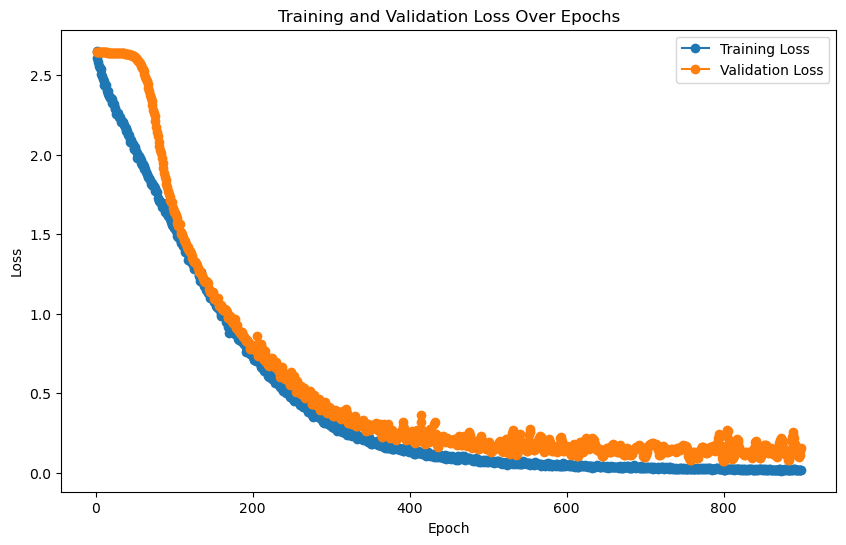

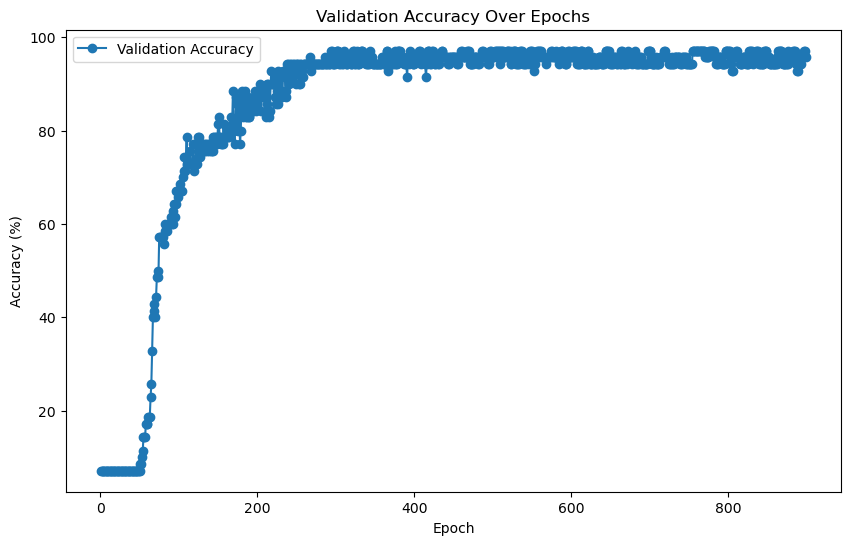


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0647

Final Test Loss: 0.1177, Test Accuracy: 96.58%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)

LOG: Training features shape: (280, 64), Training labels shape: (280,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2898, 64), Test labels shape: (2898,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 72.86%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)
Train reps shape: (280, 64)
Train labels shape: (280,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2898, 64)
Test labels shape: (2898,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7791  |  Val Loss: 2.6683
Validation loss improved from inf to 2.6683.
[Epoch 2/1000] Train Loss: 2.6540  |  Val Loss: 2.6288
Validation loss improved from 2.6683 to 2.6288.
[Epoch 3/1000] Train Loss: 2.6228  |  Val Loss: 2.6118
Validation loss improved from 2.6288 to 2.6118.
[Epoch 4/1000] Train Loss: 2.6103  |  Val Loss: 2.6055
Validation loss improved from 2.6118 to 2.6055.
[Epoch 5/1000] Train Loss: 2.6052  |  Val Loss: 2.5986
Validation loss improved from 2.6055 to 2.5986.
[Epoch 6/1000] Train Loss: 2.5949  |  Val Loss: 2.5867
Validation loss improved from 2.5986 to 2.5867.
[Epoch 7/1000] Train Loss: 2.5857  |  Val Loss: 2.5801
Validation loss improved from 2.5867 to 2.5801.
[Epoch 8/1000] Train Loss: 2.5785  |  Val Loss: 2.5638
Validation loss improved from 2.5801 to 2.5638.
[Epoch 9/1000] Train Loss: 2.5627  |  Val Loss: 2.5491
Validation loss improved from 2.5638 to 2.5491.
[Epoch 10/1000] Train Loss: 2.5497  |  Val Loss: 2.5345
Validation loss impr

[Epoch 15/1000] Train Loss: 2.4598  |  Val Loss: 2.4256
Validation loss improved from 2.4558 to 2.4256.
[Epoch 16/1000] Train Loss: 2.4296  |  Val Loss: 2.3979
Validation loss improved from 2.4256 to 2.3979.
[Epoch 17/1000] Train Loss: 2.4005  |  Val Loss: 2.3704
Validation loss improved from 2.3979 to 2.3704.
[Epoch 18/1000] Train Loss: 2.3694  |  Val Loss: 2.3328
Validation loss improved from 2.3704 to 2.3328.


[Epoch 19/1000] Train Loss: 2.3349  |  Val Loss: 2.2984
Validation loss improved from 2.3328 to 2.2984.
[Epoch 20/1000] Train Loss: 2.3045  |  Val Loss: 2.2607
Validation loss improved from 2.2984 to 2.2607.
[Epoch 21/1000] Train Loss: 2.2751  |  Val Loss: 2.2202
Validation loss improved from 2.2607 to 2.2202.
[Epoch 22/1000] Train Loss: 2.2298  |  Val Loss: 2.1800
Validation loss improved from 2.2202 to 2.1800.
[Epoch 23/1000] Train Loss: 2.1862  |  Val Loss: 2.1416
Validation loss improved from 2.1800 to 2.1416.
[Epoch 24/1000] Train Loss: 2.1545  |  Val Loss: 2.1073
Validation loss improved from 2.1416 to 2.1073.
[Epoch 25/1000] Train Loss: 2.1078  |  Val Loss: 2.0589
Validation loss improved from 2.1073 to 2.0589.
[Epoch 26/1000] Train Loss: 2.0697  |  Val Loss: 2.0242
Validation loss improved from 2.0589 to 2.0242.
[Epoch 27/1000] Train Loss: 2.0378  |  Val Loss: 1.9908
Validation loss improved from 2.0242 to 1.9908.
[Epoch 28/1000] Train Loss: 1.9963  |  Val Loss: 1.9502
Validati

[Epoch 33/1000] Train Loss: 1.8258  |  Val Loss: 1.8245
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 1.8223  |  Val Loss: 1.7593
Validation loss improved from 1.8092 to 1.7593.
[Epoch 35/1000] Train Loss: 1.7796  |  Val Loss: 1.7206
Validation loss improved from 1.7593 to 1.7206.
[Epoch 36/1000] Train Loss: 1.7483  |  Val Loss: 1.7114
Validation loss improved from 1.7206 to 1.7114.


[Epoch 37/1000] Train Loss: 1.7152  |  Val Loss: 1.6947
Validation loss improved from 1.7114 to 1.6947.
[Epoch 38/1000] Train Loss: 1.7107  |  Val Loss: 1.7039
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 1.6814  |  Val Loss: 1.6379
Validation loss improved from 1.6947 to 1.6379.
[Epoch 40/1000] Train Loss: 1.6587  |  Val Loss: 1.6156
Validation loss improved from 1.6379 to 1.6156.
[Epoch 41/1000] Train Loss: 1.6320  |  Val Loss: 1.6072
Validation loss improved from 1.6156 to 1.6072.
[Epoch 42/1000] Train Loss: 1.6108  |  Val Loss: 1.5864
Validation loss improved from 1.6072 to 1.5864.
[Epoch 43/1000] Train Loss: 1.6019  |  Val Loss: 1.6078
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 1.5785  |  Val Loss: 1.5545
Validation loss improved from 1.5864 to 1.5545.
[Epoch 45/1000] Train Loss: 1.5759  |  Val Loss: 1.5521
Validation loss improved from 1.5545 to 1.5521.
[Epoch 46/1000] Train Loss: 1.5550  |  Val Loss: 1.5

[Epoch 53/1000] Train Loss: 1.4656  |  Val Loss: 1.4644
Validation loss improved from 1.4748 to 1.4644.
[Epoch 54/1000] Train Loss: 1.4612  |  Val Loss: 1.4402
Validation loss improved from 1.4644 to 1.4402.
[Epoch 55/1000] Train Loss: 1.4415  |  Val Loss: 1.4641
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 1.4364  |  Val Loss: 1.4651
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 57/1000] Train Loss: 1.4283  |  Val Loss: 1.4193
Validation loss improved from 1.4402 to 1.4193.
[Epoch 58/1000] Train Loss: 1.4160  |  Val Loss: 1.4274
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 1.4132  |  Val Loss: 1.4279
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 1.4162  |  Val Loss: 1.4061
Validation loss improved from 1.4193 to 1.4061.
[Epoch 61/1000] Train Loss: 1.4017  |  Val Loss: 1.4122
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 1.3862

[Epoch 72/1000] Train Loss: 1.3365  |  Val Loss: 1.3645
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 73/1000] Train Loss: 1.3279  |  Val Loss: 1.3615
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 74/1000] Train Loss: 1.3223  |  Val Loss: 1.3417
Validation loss improved from 1.3611 to 1.3417.
[Epoch 75/1000] Train Loss: 1.3302  |  Val Loss: 1.3762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 1.3205  |  Val Loss: 1.3398
Validation loss improved from 1.3417 to 1.3398.
[Epoch 77/1000] Train Loss: 1.3250  |  Val Loss: 1.3509
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 1.3038  |  Val Loss: 1.3464
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 1.3068  |  Val Loss: 1.3579
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 1.3101  |  Val Loss: 1.3569
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train 

[Epoch 91/1000] Train Loss: 1.2977  |  Val Loss: 1.3113
Validation loss improved from 1.3178 to 1.3113.
[Epoch 92/1000] Train Loss: 1.2937  |  Val Loss: 1.3224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 1.2961  |  Val Loss: 1.3804
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 1.3059  |  Val Loss: 1.3301
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 1.2841  |  Val Loss: 1.3212
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 96/1000] Train Loss: 1.2611  |  Val Loss: 1.3087
Validation loss improved from 1.3113 to 1.3087.
[Epoch 97/1000] Train Loss: 1.2730  |  Val Loss: 1.3147
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 1.2639  |  Val Loss: 1.3247
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 1.2592  |  Val Loss: 1.3142
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train

[Epoch 109/1000] Train Loss: 1.2505  |  Val Loss: 1.2974
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 110/1000] Train Loss: 1.2309  |  Val Loss: 1.3232
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 111/1000] Train Loss: 1.2421  |  Val Loss: 1.3463
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 112/1000] Train Loss: 1.2507  |  Val Loss: 1.3509
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 113/1000] Train Loss: 1.2800  |  Val Loss: 1.2969
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 114/1000] Train Loss: 1.2716  |  Val Loss: 1.2873
Validation loss improved from 1.2921 to 1.2873.
[Epoch 115/1000] Train Loss: 1.2330  |  Val Loss: 1.2978
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.2282  |  Val Loss: 1.3609
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 1.2388  |  Val Loss: 1.2794
Validation loss improved from 1.2873 to 1.2794.
[Epoch 118/10

[Epoch 127/1000] Train Loss: 1.2317  |  Val Loss: 1.2817
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 128/1000] Train Loss: 1.2335  |  Val Loss: 1.2924
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 129/1000] Train Loss: 1.2408  |  Val Loss: 1.3127
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 130/1000] Train Loss: 1.2171  |  Val Loss: 1.3225
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 131/1000] Train Loss: 1.2132  |  Val Loss: 1.2992
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 132/1000] Train Loss: 1.2215  |  Val Loss: 1.2593
Validation loss improved from 1.2794 to 1.2593.
[Epoch 133/1000] Train Loss: 1.2075  |  Val Loss: 1.3614
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 134/1000] Train Loss: 1.2452  |  Val Loss: 1.3104
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 135/1000] Train Loss: 1.2076  |  Val Loss: 1.2861
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 145/1000] Train Loss: 1.1857  |  Val Loss: 1.2728
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 146/1000] Train Loss: 1.1903  |  Val Loss: 1.2933
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 147/1000] Train Loss: 1.1865  |  Val Loss: 1.2518
Validation loss improved from 1.2593 to 1.2518.
[Epoch 148/1000] Train Loss: 1.1823  |  Val Loss: 1.2952
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 149/1000] Train Loss: 1.1830  |  Val Loss: 1.2897
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 150/1000] Train Loss: 1.1839  |  Val Loss: 1.2725
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 151/1000] Train Loss: 1.1805  |  Val Loss: 1.2697
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 152/1000] Train Loss: 1.1985  |  Val Loss: 1.2803
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 153/1000] Train Loss: 1.1839  |  Val Loss: 1.3461
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 164/1000] Train Loss: 1.1990  |  Val Loss: 1.2937
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 165/1000] Train Loss: 1.1651  |  Val Loss: 1.2369
Validation loss improved from 1.2518 to 1.2369.
[Epoch 166/1000] Train Loss: 1.1745  |  Val Loss: 1.2720
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 1.1935  |  Val Loss: 1.3975
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 168/1000] Train Loss: 1.2094  |  Val Loss: 1.2553
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 169/1000] Train Loss: 1.1763  |  Val Loss: 1.3423
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 170/1000] Train Loss: 1.1875  |  Val Loss: 1.2598
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 171/1000] Train Loss: 1.1816  |  Val Loss: 1.2464
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 172/1000] Train Loss: 1.1741  |  Val Loss: 1.4241
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 183/1000] Train Loss: 1.1488  |  Val Loss: 1.2704
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 184/1000] Train Loss: 1.1476  |  Val Loss: 1.3367
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 185/1000] Train Loss: 1.1763  |  Val Loss: 1.2329
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 186/1000] Train Loss: 1.1503  |  Val Loss: 1.2766
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 187/1000] Train Loss: 1.1508  |  Val Loss: 1.2554
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 188/1000] Train Loss: 1.1501  |  Val Loss: 1.3731
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 189/1000] Train Loss: 1.1889  |  Val Loss: 1.2362
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 190/1000] Train Loss: 1.1821  |  Val Loss: 1.3251
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 191/1000] Train Loss: 1.2048  |  Val Loss: 1.3138
!! Validation loss did NOT improve !! Patience: 15

[Epoch 202/1000] Train Loss: 1.1444  |  Val Loss: 1.3230
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 203/1000] Train Loss: 1.1494  |  Val Loss: 1.2634
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 204/1000] Train Loss: 1.1646  |  Val Loss: 1.3266
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 205/1000] Train Loss: 1.1303  |  Val Loss: 1.2276
Validation loss improved from 1.2277 to 1.2276.
[Epoch 206/1000] Train Loss: 1.1328  |  Val Loss: 1.2717
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 1.1255  |  Val Loss: 1.2479
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 1.1261  |  Val Loss: 1.2867
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 1.1260  |  Val Loss: 1.2349
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 210/1000] Train Loss: 1.1559  |  Val Loss: 1.3136
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 221/1000] Train Loss: 1.1180  |  Val Loss: 1.2492
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 222/1000] Train Loss: 1.1217  |  Val Loss: 1.2797
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 223/1000] Train Loss: 1.1209  |  Val Loss: 1.2870
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 224/1000] Train Loss: 1.1381  |  Val Loss: 1.2332
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 225/1000] Train Loss: 1.1303  |  Val Loss: 1.3675
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 226/1000] Train Loss: 1.1494  |  Val Loss: 1.2543
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 227/1000] Train Loss: 1.1789  |  Val Loss: 1.3710
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 228/1000] Train Loss: 1.1511  |  Val Loss: 1.2083
Validation loss improved from 1.2261 to 1.2083.
[Epoch 229/1000] Train Loss: 1.1065  |  Val Loss: 1.2789
!! Validation loss did NOT improve !! Patience: 1/100
[Ep

[Epoch 239/1000] Train Loss: 1.0959  |  Val Loss: 1.2893
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 240/1000] Train Loss: 1.0984  |  Val Loss: 1.2365
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 241/1000] Train Loss: 1.0953  |  Val Loss: 1.2218
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 242/1000] Train Loss: 1.1021  |  Val Loss: 1.2533
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 243/1000] Train Loss: 1.0821  |  Val Loss: 1.2774
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 244/1000] Train Loss: 1.0967  |  Val Loss: 1.2449
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 245/1000] Train Loss: 1.0955  |  Val Loss: 1.3206
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 246/1000] Train Loss: 1.0926  |  Val Loss: 1.2290
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 247/1000] Train Loss: 1.1032  |  Val Loss: 1.2171
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 1.0869  |  Val Loss: 1.2357
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 258/1000] Train Loss: 1.0694  |  Val Loss: 1.2976
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 259/1000] Train Loss: 1.0818  |  Val Loss: 1.2458
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 260/1000] Train Loss: 1.0804  |  Val Loss: 1.2731
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 261/1000] Train Loss: 1.0901  |  Val Loss: 1.2388
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 262/1000] Train Loss: 1.0775  |  Val Loss: 1.2085
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 263/1000] Train Loss: 1.1335  |  Val Loss: 1.3897
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 264/1000] Train Loss: 1.0894  |  Val Loss: 1.2053
Validation loss improved from 1.2076 to 1.2053.
[Epoch 265/1000] Train Loss: 1.0556  |  Val Loss: 1.3482
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 275/1000] Train Loss: 1.1139  |  Val Loss: 1.3404
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 276/1000] Train Loss: 1.0818  |  Val Loss: 1.2391
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 277/1000] Train Loss: 1.1186  |  Val Loss: 1.2111
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 278/1000] Train Loss: 1.0912  |  Val Loss: 1.2650
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 279/1000] Train Loss: 1.0546  |  Val Loss: 1.2103
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 280/1000] Train Loss: 1.0511  |  Val Loss: 1.2570
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 281/1000] Train Loss: 1.0508  |  Val Loss: 1.2694
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 282/1000] Train Loss: 1.0555  |  Val Loss: 1.2139
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 283/1000] Train Loss: 1.0656  |  Val Loss: 1.2434
!! Validation loss did NOT improve !! Patience: 1

[Epoch 292/1000] Train Loss: 1.1358  |  Val Loss: 1.2631
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 293/1000] Train Loss: 1.1475  |  Val Loss: 1.2922
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 294/1000] Train Loss: 1.1186  |  Val Loss: 1.2422
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 295/1000] Train Loss: 1.1036  |  Val Loss: 1.2471
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 296/1000] Train Loss: 1.0918  |  Val Loss: 1.2756
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 297/1000] Train Loss: 1.0645  |  Val Loss: 1.2924
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 298/1000] Train Loss: 1.0902  |  Val Loss: 1.2421
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 299/1000] Train Loss: 1.0675  |  Val Loss: 1.2630
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 300/1000] Train Loss: 1.0378  |  Val Loss: 1.1884
Validation loss improved from 1.1969 to 1.1884.

[Epoch 310/1000] Train Loss: 1.0384  |  Val Loss: 1.2165
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 1.0653  |  Val Loss: 1.2381
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 312/1000] Train Loss: 1.0453  |  Val Loss: 1.1845
Validation loss improved from 1.1858 to 1.1845.
[Epoch 313/1000] Train Loss: 1.0714  |  Val Loss: 1.3013
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 314/1000] Train Loss: 1.0451  |  Val Loss: 1.2177
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 315/1000] Train Loss: 1.0326  |  Val Loss: 1.2250
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 316/1000] Train Loss: 1.0147  |  Val Loss: 1.3045
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 317/1000] Train Loss: 1.0374  |  Val Loss: 1.2016
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 318/1000] Train Loss: 1.0828  |  Val Loss: 1.3740
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 328/1000] Train Loss: 1.0311  |  Val Loss: 1.2405
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 329/1000] Train Loss: 1.0260  |  Val Loss: 1.2248
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 330/1000] Train Loss: 1.0185  |  Val Loss: 1.2434
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 331/1000] Train Loss: 1.0113  |  Val Loss: 1.2640
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 332/1000] Train Loss: 1.0513  |  Val Loss: 1.1967
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 333/1000] Train Loss: 1.0195  |  Val Loss: 1.2301
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 334/1000] Train Loss: 1.0063  |  Val Loss: 1.2634
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 335/1000] Train Loss: 1.0496  |  Val Loss: 1.2073
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 336/1000] Train Loss: 1.0243  |  Val Loss: 1.3958
!! Validation loss did NOT improve !! Patience:

[Epoch 348/1000] Train Loss: 0.9820  |  Val Loss: 1.2785
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 349/1000] Train Loss: 1.0541  |  Val Loss: 1.2115
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 350/1000] Train Loss: 1.0057  |  Val Loss: 1.3844
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 351/1000] Train Loss: 1.0593  |  Val Loss: 1.1887
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 352/1000] Train Loss: 1.0169  |  Val Loss: 1.2025
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 353/1000] Train Loss: 1.0361  |  Val Loss: 1.2673
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 354/1000] Train Loss: 1.0310  |  Val Loss: 1.1967
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 355/1000] Train Loss: 1.0191  |  Val Loss: 1.2875
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 356/1000] Train Loss: 0.9909  |  Val Loss: 1.1866
!! Validation loss did NOT improve !! Patience: 

[Epoch 367/1000] Train Loss: 1.0924  |  Val Loss: 1.2378
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 368/1000] Train Loss: 1.0055  |  Val Loss: 1.2514
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 369/1000] Train Loss: 1.0106  |  Val Loss: 1.3514
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 370/1000] Train Loss: 1.0286  |  Val Loss: 1.1829
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 371/1000] Train Loss: 1.0106  |  Val Loss: 1.2665
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 372/1000] Train Loss: 0.9824  |  Val Loss: 1.1915
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 373/1000] Train Loss: 0.9657  |  Val Loss: 1.2709
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 374/1000] Train Loss: 0.9798  |  Val Loss: 1.2147
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 375/1000] Train Loss: 0.9709  |  Val Loss: 1.3027
!! Validation loss did NOT improve !! Patience:

[Epoch 386/1000] Train Loss: 1.0124  |  Val Loss: 1.2345
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 387/1000] Train Loss: 0.9847  |  Val Loss: 1.2484
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 388/1000] Train Loss: 0.9768  |  Val Loss: 1.1922
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 389/1000] Train Loss: 0.9972  |  Val Loss: 1.3731
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 390/1000] Train Loss: 1.0428  |  Val Loss: 1.1714
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 391/1000] Train Loss: 0.9704  |  Val Loss: 1.2284
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 392/1000] Train Loss: 1.0004  |  Val Loss: 1.2408
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 393/1000] Train Loss: 0.9955  |  Val Loss: 1.2428
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 394/1000] Train Loss: 0.9825  |  Val Loss: 1.2028
!! Validation loss did NOT improve !! Patience:

[Epoch 407/1000] Train Loss: 0.9326  |  Val Loss: 1.3073
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 408/1000] Train Loss: 0.9949  |  Val Loss: 1.2021
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 409/1000] Train Loss: 0.9621  |  Val Loss: 1.2946
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 410/1000] Train Loss: 0.9435  |  Val Loss: 1.2525
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 411/1000] Train Loss: 1.0841  |  Val Loss: 1.3841
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 412/1000] Train Loss: 0.9612  |  Val Loss: 1.2128
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 413/1000] Train Loss: 0.9665  |  Val Loss: 1.3363
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 414/1000] Train Loss: 0.9584  |  Val Loss: 1.1895
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 415/1000] Train Loss: 0.9595  |  Val Loss: 1.2023
!! Validation loss did NOT improve !! Patience:

[Epoch 424/1000] Train Loss: 0.9342  |  Val Loss: 1.3425
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 425/1000] Train Loss: 0.9862  |  Val Loss: 1.2345
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 426/1000] Train Loss: 0.9927  |  Val Loss: 1.2403
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 427/1000] Train Loss: 0.9343  |  Val Loss: 1.1973
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 428/1000] Train Loss: 0.9233  |  Val Loss: 1.2804
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 429/1000] Train Loss: 0.9326  |  Val Loss: 1.1721
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 430/1000] Train Loss: 0.9334  |  Val Loss: 1.2851
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 431/1000] Train Loss: 0.9547  |  Val Loss: 1.1935
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 432/1000] Train Loss: 0.9313  |  Val Loss: 1.2190
!! Validation loss did NOT improve !! Patience:

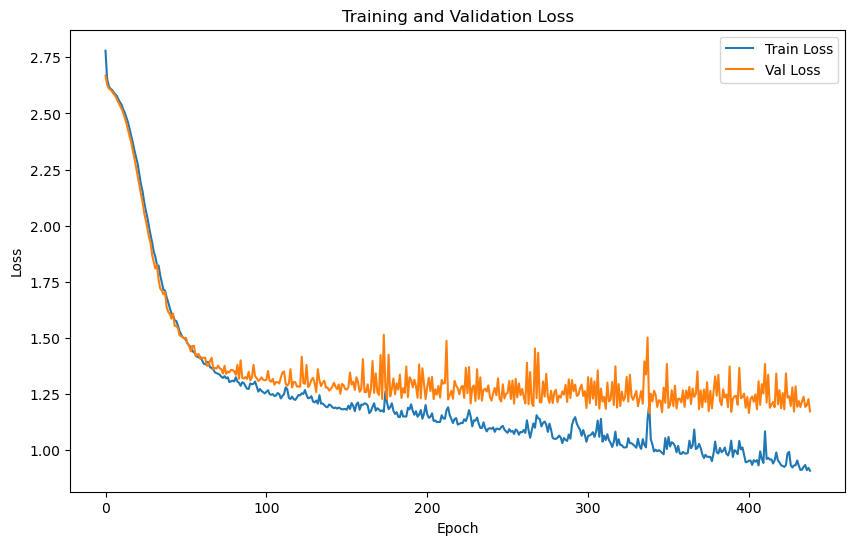

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0983 | Test Accuracy: 52.69%


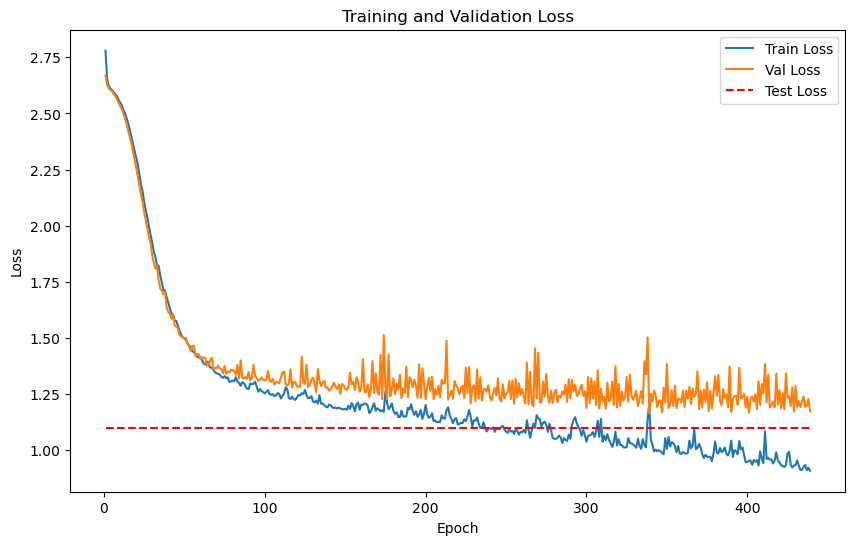

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.3909
Epoch [1/2000], Avg Train Loss: 8.3909
Epoch [1/2000], Avg Val Loss: 3.6736
Validation loss improved from inf to 3.6736. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3708
Epoch [2/2000], Avg Train Loss: 8.3708
Epoch [2/2000], Avg Val Loss: 3.6560
Validation loss improved from 3.6736 to 3.6560. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2225
Epoch [3/2000], Avg Train Loss: 8.2225
Epoch [3/2000], Avg Val Loss: 3.6393
Validation loss improved from 3.6560 to 3.6393. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3124
Epoch [4/2000], Avg Train Loss: 8.3124
Epoch [4/2000], Avg Val Loss: 3.6233
Validation loss improved from 3.6393 to 3.6233. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.0153
Epoch [5/2000], Avg Train Loss: 8.0153
Epoch [5/2000], Avg Val Loss: 3.6079
Validation loss improved from 3.6233 to 3.6079. Saving mode

    Batch [1/1], Train Loss: 7.2285
Epoch [16/2000], Avg Train Loss: 7.2285
Epoch [16/2000], Avg Val Loss: 3.4783
Validation loss improved from 3.4877 to 3.4783. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.2217
Epoch [17/2000], Avg Train Loss: 7.2217
Epoch [17/2000], Avg Val Loss: 3.4693
Validation loss improved from 3.4783 to 3.4693. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.1992
Epoch [18/2000], Avg Train Loss: 7.1992
Epoch [18/2000], Avg Val Loss: 3.4606
Validation loss improved from 3.4693 to 3.4606. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.0861
Epoch [19/2000], Avg Train Loss: 7.0861
Epoch [19/2000], Avg Val Loss: 3.4524
Validation loss improved from 3.4606 to 3.4524. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.0230
Epoch [20/2000], Avg Train Loss: 7.0230
Epoch [20/2000], Avg Val Loss: 3.4444
Validation loss improved from 3.4524 to 3.

Epoch [23/2000], Avg Val Loss: 3.4228
Validation loss improved from 3.4297 to 3.4228. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.6645
Epoch [24/2000], Avg Train Loss: 6.6645
Epoch [24/2000], Avg Val Loss: 3.4163
Validation loss improved from 3.4228 to 3.4163. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7145
Epoch [25/2000], Avg Train Loss: 6.7145
Epoch [25/2000], Avg Val Loss: 3.4101
Validation loss improved from 3.4163 to 3.4101. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.7261
Epoch [26/2000], Avg Train Loss: 6.7261
Epoch [26/2000], Avg Val Loss: 3.4043
Validation loss improved from 3.4101 to 3.4043. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.6846
Epoch [27/2000], Avg Train Loss: 6.6846
Epoch [27/2000], Avg Val Loss: 3.3986
Validation loss improved from 3.4043 to 3.3986. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.2387
Epoch [36/2000], Avg Train Loss: 6.2387
Epoch [36/2000], Avg Val Loss: 3.3578
Validation loss improved from 3.3617 to 3.3578. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.2331
Epoch [37/2000], Avg Train Loss: 6.2331
Epoch [37/2000], Avg Val Loss: 3.3541
Validation loss improved from 3.3578 to 3.3541. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.1635
Epoch [38/2000], Avg Train Loss: 6.1635
Epoch [38/2000], Avg Val Loss: 3.3505
Validation loss improved from 3.3541 to 3.3505. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.1933
Epoch [39/2000], Avg Train Loss: 6.1933
Epoch [39/2000], Avg Val Loss: 3.3472
Validation loss improved from 3.3505 to 3.3472. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.0917
Epoch [40/2000], Avg Train Loss: 6.0917
Epoch [40/2000], Avg Val Loss: 3.3440
Validation loss improved from 3.3472 to 3.

    Batch [1/1], Train Loss: 5.8606
Epoch [51/2000], Avg Train Loss: 5.8606
Epoch [51/2000], Avg Val Loss: 3.3157
Validation loss improved from 3.3179 to 3.3157. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.7977
Epoch [52/2000], Avg Train Loss: 5.7977
Epoch [52/2000], Avg Val Loss: 3.3135
Validation loss improved from 3.3157 to 3.3135. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.8031
Epoch [53/2000], Avg Train Loss: 5.8031
Epoch [53/2000], Avg Val Loss: 3.3113
Validation loss improved from 3.3135 to 3.3113. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.8396
Epoch [54/2000], Avg Train Loss: 5.8396
Epoch [54/2000], Avg Val Loss: 3.3092
Validation loss improved from 3.3113 to 3.3092. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.6910
Epoch [55/2000], Avg Train Loss: 5.6910
Epoch [55/2000], Avg Val Loss: 3.3072
Validation loss improved from 3.3092 to 3.

    Batch [1/1], Train Loss: 5.6356
Epoch [58/2000], Avg Train Loss: 5.6356
Epoch [58/2000], Avg Val Loss: 3.3018
Validation loss improved from 3.3036 to 3.3018. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.7104
Epoch [59/2000], Avg Train Loss: 5.7104
Epoch [59/2000], Avg Val Loss: 3.3001
Validation loss improved from 3.3018 to 3.3001. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.6341
Epoch [60/2000], Avg Train Loss: 5.6341
Epoch [60/2000], Avg Val Loss: 3.2985
Validation loss improved from 3.3001 to 3.2985. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.5632
Epoch [61/2000], Avg Train Loss: 5.5632
Epoch [61/2000], Avg Val Loss: 3.2968
Validation loss improved from 3.2985 to 3.2968. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 5.6052
Epoch [62/2000], Avg Train Loss: 5.6052
Epoch [62/2000], Avg Val Loss: 3.2952
Validation loss improved from 3.2968 to 3.

    Batch [1/1], Train Loss: 5.4282
Epoch [74/2000], Avg Train Loss: 5.4282
Epoch [74/2000], Avg Val Loss: 3.2785
Validation loss improved from 3.2797 to 3.2785. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.3811
Epoch [75/2000], Avg Train Loss: 5.3811
Epoch [75/2000], Avg Val Loss: 3.2773
Validation loss improved from 3.2785 to 3.2773. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.4446
Epoch [76/2000], Avg Train Loss: 5.4446
Epoch [76/2000], Avg Val Loss: 3.2761
Validation loss improved from 3.2773 to 3.2761. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.3808
Epoch [77/2000], Avg Train Loss: 5.3808
Epoch [77/2000], Avg Val Loss: 3.2749
Validation loss improved from 3.2761 to 3.2749. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.3962
Epoch [78/2000], Avg Train Loss: 5.3962
Epoch [78/2000], Avg Val Loss: 3.2738
Validation loss improved from 3.2749 to 3.

Epoch [89/2000], Avg Val Loss: 3.2621
Validation loss improved from 3.2631 to 3.2621. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.2749
Epoch [90/2000], Avg Train Loss: 5.2749
Epoch [90/2000], Avg Val Loss: 3.2611
Validation loss improved from 3.2621 to 3.2611. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.2283
Epoch [91/2000], Avg Train Loss: 5.2283
Epoch [91/2000], Avg Val Loss: 3.2600
Validation loss improved from 3.2611 to 3.2600. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.2647
Epoch [92/2000], Avg Train Loss: 5.2647
Epoch [92/2000], Avg Val Loss: 3.2591
Validation loss improved from 3.2600 to 3.2591. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.2352
Epoch [93/2000], Avg Train Loss: 5.2352
Epoch [93/2000], Avg Val Loss: 3.2581
Validation loss improved from 3.2591 to 3.2581. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0923
Epoch [109/2000], Avg Train Loss: 5.0923
Epoch [109/2000], Avg Val Loss: 3.2426
Validation loss improved from 3.2436 to 3.2426. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.1605
Epoch [110/2000], Avg Train Loss: 5.1605
Epoch [110/2000], Avg Val Loss: 3.2417
Validation loss improved from 3.2426 to 3.2417. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.1444
Epoch [111/2000], Avg Train Loss: 5.1444
Epoch [111/2000], Avg Val Loss: 3.2407
Validation loss improved from 3.2417 to 3.2407. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.1008
Epoch [112/2000], Avg Train Loss: 5.1008
Epoch [112/2000], Avg Val Loss: 3.2398
Validation loss improved from 3.2407 to 3.2398. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.1054
Epoch [113/2000], Avg Train Loss: 5.1054
Epoch [113/2000], Avg Val Loss: 3.2389
Validation loss improved fro

Epoch [124/2000], Avg Val Loss: 3.2292
Validation loss improved from 3.2301 to 3.2292. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.0618
Epoch [125/2000], Avg Train Loss: 5.0618
Epoch [125/2000], Avg Val Loss: 3.2284
Validation loss improved from 3.2292 to 3.2284. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.0643
Epoch [126/2000], Avg Train Loss: 5.0643
Epoch [126/2000], Avg Val Loss: 3.2275
Validation loss improved from 3.2284 to 3.2275. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.0683
Epoch [127/2000], Avg Train Loss: 5.0683
Epoch [127/2000], Avg Val Loss: 3.2266
Validation loss improved from 3.2275 to 3.2266. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 5.0579
Epoch [128/2000], Avg Train Loss: 5.0579
Epoch [128/2000], Avg Val Loss: 3.2257
Validation loss improved from 3.2266 to 3.2257. Saving model...

LOG: Epoch [129/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0318
Epoch [145/2000], Avg Train Loss: 5.0318
Epoch [145/2000], Avg Val Loss: 3.2102
Validation loss improved from 3.2111 to 3.2102. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.9363
Epoch [146/2000], Avg Train Loss: 4.9363
Epoch [146/2000], Avg Val Loss: 3.2092
Validation loss improved from 3.2102 to 3.2092. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.9143
Epoch [147/2000], Avg Train Loss: 4.9143
Epoch [147/2000], Avg Val Loss: 3.2083
Validation loss improved from 3.2092 to 3.2083. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.9312
Epoch [148/2000], Avg Train Loss: 4.9312
Epoch [148/2000], Avg Val Loss: 3.2073
Validation loss improved from 3.2083 to 3.2073. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.9425
Epoch [149/2000], Avg Train Loss: 4.9425
Epoch [149/2000], Avg Val Loss: 3.2064
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8618
Epoch [160/2000], Avg Train Loss: 4.8618
Epoch [160/2000], Avg Val Loss: 3.1956
Validation loss improved from 3.1966 to 3.1956. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.9102
Epoch [161/2000], Avg Train Loss: 4.9102
Epoch [161/2000], Avg Val Loss: 3.1946
Validation loss improved from 3.1956 to 3.1946. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.8667
Epoch [162/2000], Avg Train Loss: 4.8667
Epoch [162/2000], Avg Val Loss: 3.1936
Validation loss improved from 3.1946 to 3.1936. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.8624
Epoch [163/2000], Avg Train Loss: 4.8624
Epoch [163/2000], Avg Val Loss: 3.1926
Validation loss improved from 3.1936 to 3.1926. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.8808
Epoch [164/2000], Avg Train Loss: 4.8808
Epoch [164/2000], Avg Val Loss: 3.1916
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8867
Epoch [180/2000], Avg Train Loss: 4.8867
Epoch [180/2000], Avg Val Loss: 3.1752
Validation loss improved from 3.1762 to 3.1752. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.8671
Epoch [181/2000], Avg Train Loss: 4.8671
Epoch [181/2000], Avg Val Loss: 3.1741
Validation loss improved from 3.1752 to 3.1741. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.8284
Epoch [182/2000], Avg Train Loss: 4.8284
Epoch [182/2000], Avg Val Loss: 3.1731
Validation loss improved from 3.1741 to 3.1731. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.8357
Epoch [183/2000], Avg Train Loss: 4.8357
Epoch [183/2000], Avg Val Loss: 3.1721
Validation loss improved from 3.1731 to 3.1721. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.9081
Epoch [184/2000], Avg Train Loss: 4.9081
Epoch [184/2000], Avg Val Loss: 3.1710
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8176
Epoch [193/2000], Avg Train Loss: 4.8176
Epoch [193/2000], Avg Val Loss: 3.1617
Validation loss improved from 3.1628 to 3.1617. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.8030
Epoch [194/2000], Avg Train Loss: 4.8030
Epoch [194/2000], Avg Val Loss: 3.1607
Validation loss improved from 3.1617 to 3.1607. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.7978
Epoch [195/2000], Avg Train Loss: 4.7978
Epoch [195/2000], Avg Val Loss: 3.1596
Validation loss improved from 3.1607 to 3.1596. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.8071
Epoch [196/2000], Avg Train Loss: 4.8071
Epoch [196/2000], Avg Val Loss: 3.1586
Validation loss improved from 3.1596 to 3.1586. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 4.8278
Epoch [197/2000], Avg Train Loss: 4.8278
Epoch [197/2000], Avg Val Loss: 3.1576
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7436
Epoch [216/2000], Avg Train Loss: 4.7436
Epoch [216/2000], Avg Val Loss: 3.1372
Validation loss improved from 3.1383 to 3.1372. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.7869
Epoch [217/2000], Avg Train Loss: 4.7869
Epoch [217/2000], Avg Val Loss: 3.1360
Validation loss improved from 3.1372 to 3.1360. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.7443
Epoch [218/2000], Avg Train Loss: 4.7443
Epoch [218/2000], Avg Val Loss: 3.1348
Validation loss improved from 3.1360 to 3.1348. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.7371
Epoch [219/2000], Avg Train Loss: 4.7371
Epoch [219/2000], Avg Val Loss: 3.1336
Validation loss improved from 3.1348 to 3.1336. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.7369
Epoch [220/2000], Avg Train Loss: 4.7369
Epoch [220/2000], Avg Val Loss: 3.1324
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7406
Epoch [229/2000], Avg Train Loss: 4.7406
Epoch [229/2000], Avg Val Loss: 3.1214
Validation loss improved from 3.1226 to 3.1214. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.6741
Epoch [230/2000], Avg Train Loss: 4.6741
Epoch [230/2000], Avg Val Loss: 3.1201
Validation loss improved from 3.1214 to 3.1201. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.7218
Epoch [231/2000], Avg Train Loss: 4.7218
Epoch [231/2000], Avg Val Loss: 3.1189
Validation loss improved from 3.1201 to 3.1189. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.6994
Epoch [232/2000], Avg Train Loss: 4.6994
Epoch [232/2000], Avg Val Loss: 3.1176
Validation loss improved from 3.1189 to 3.1176. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.7656
Epoch [233/2000], Avg Train Loss: 4.7656
Epoch [233/2000], Avg Val Loss: 3.1164
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6651
Epoch [252/2000], Avg Train Loss: 4.6651
Epoch [252/2000], Avg Val Loss: 3.0935
Validation loss improved from 3.0947 to 3.0935. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.7157
Epoch [253/2000], Avg Train Loss: 4.7157
Epoch [253/2000], Avg Val Loss: 3.0922
Validation loss improved from 3.0935 to 3.0922. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.6352
Epoch [254/2000], Avg Train Loss: 4.6352
Epoch [254/2000], Avg Val Loss: 3.0910
Validation loss improved from 3.0922 to 3.0910. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.6758
Epoch [255/2000], Avg Train Loss: 4.6758
Epoch [255/2000], Avg Val Loss: 3.0898
Validation loss improved from 3.0910 to 3.0898. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.6816
Epoch [256/2000], Avg Train Loss: 4.6816
Epoch [256/2000], Avg Val Loss: 3.0886
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6546
Epoch [265/2000], Avg Train Loss: 4.6546
Epoch [265/2000], Avg Val Loss: 3.0772
Validation loss improved from 3.0785 to 3.0772. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.6717
Epoch [266/2000], Avg Train Loss: 4.6717
Epoch [266/2000], Avg Val Loss: 3.0759
Validation loss improved from 3.0772 to 3.0759. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.6393
Epoch [267/2000], Avg Train Loss: 4.6393
Epoch [267/2000], Avg Val Loss: 3.0747
Validation loss improved from 3.0759 to 3.0747. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.6572
Epoch [268/2000], Avg Train Loss: 4.6572
Epoch [268/2000], Avg Val Loss: 3.0734
Validation loss improved from 3.0747 to 3.0734. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 4.6537
Epoch [269/2000], Avg Train Loss: 4.6537
Epoch [269/2000], Avg Val Loss: 3.0721
Validation loss improved fro

Epoch [287/2000], Avg Val Loss: 3.0482
Validation loss improved from 3.0496 to 3.0482. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.6289
Epoch [288/2000], Avg Train Loss: 4.6289
Epoch [288/2000], Avg Val Loss: 3.0468
Validation loss improved from 3.0482 to 3.0468. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.6025
Epoch [289/2000], Avg Train Loss: 4.6025
Epoch [289/2000], Avg Val Loss: 3.0454
Validation loss improved from 3.0468 to 3.0454. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.5661
Epoch [290/2000], Avg Train Loss: 4.5661
Epoch [290/2000], Avg Val Loss: 3.0439
Validation loss improved from 3.0454 to 3.0439. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.6142
Epoch [291/2000], Avg Train Loss: 4.6142
Epoch [291/2000], Avg Val Loss: 3.0425
Validation loss improved from 3.0439 to 3.0425. Saving model...

LOG: Epoch [292/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5995
Epoch [299/2000], Avg Train Loss: 4.5995
Epoch [299/2000], Avg Val Loss: 3.0311
Validation loss improved from 3.0325 to 3.0311. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.5787
Epoch [300/2000], Avg Train Loss: 4.5787
Epoch [300/2000], Avg Val Loss: 3.0297
Validation loss improved from 3.0311 to 3.0297. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.5943
Epoch [301/2000], Avg Train Loss: 4.5943
Epoch [301/2000], Avg Val Loss: 3.0283
Validation loss improved from 3.0297 to 3.0283. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.5440
Epoch [302/2000], Avg Train Loss: 4.5440
Epoch [302/2000], Avg Val Loss: 3.0269
Validation loss improved from 3.0283 to 3.0269. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.5973
Epoch [303/2000], Avg Train Loss: 4.5973
Epoch [303/2000], Avg Val Loss: 3.0255
Validation loss improved fro

Epoch [321/2000], Avg Val Loss: 3.0007
Validation loss improved from 3.0021 to 3.0007. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.5143
Epoch [322/2000], Avg Train Loss: 4.5143
Epoch [322/2000], Avg Val Loss: 2.9993
Validation loss improved from 3.0007 to 2.9993. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 4.5314
Epoch [323/2000], Avg Train Loss: 4.5314
Epoch [323/2000], Avg Val Loss: 2.9979
Validation loss improved from 2.9993 to 2.9979. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 4.5933
Epoch [324/2000], Avg Train Loss: 4.5933
Epoch [324/2000], Avg Val Loss: 2.9964
Validation loss improved from 2.9979 to 2.9964. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 4.5686
Epoch [325/2000], Avg Train Loss: 4.5686
Epoch [325/2000], Avg Val Loss: 2.9950
Validation loss improved from 2.9964 to 2.9950. Saving model...

LOG: Epoch [326/2000] - Training
    Bat

Epoch [335/2000], Avg Val Loss: 2.9807
Validation loss improved from 2.9822 to 2.9807. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.5101
Epoch [336/2000], Avg Train Loss: 4.5101
Epoch [336/2000], Avg Val Loss: 2.9793
Validation loss improved from 2.9807 to 2.9793. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.4826
Epoch [337/2000], Avg Train Loss: 4.4826
Epoch [337/2000], Avg Val Loss: 2.9779
Validation loss improved from 2.9793 to 2.9779. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.4660
Epoch [338/2000], Avg Train Loss: 4.4660
Epoch [338/2000], Avg Val Loss: 2.9764
Validation loss improved from 2.9779 to 2.9764. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.4933
Epoch [339/2000], Avg Train Loss: 4.4933
Epoch [339/2000], Avg Val Loss: 2.9750
Validation loss improved from 2.9764 to 2.9750. Saving model...

LOG: Epoch [340/2000] - Training
    Bat

Epoch [354/2000], Avg Val Loss: 2.9536
Validation loss improved from 2.9551 to 2.9536. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.4458
Epoch [355/2000], Avg Train Loss: 4.4458
Epoch [355/2000], Avg Val Loss: 2.9521
Validation loss improved from 2.9536 to 2.9521. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.4852
Epoch [356/2000], Avg Train Loss: 4.4852
Epoch [356/2000], Avg Val Loss: 2.9505
Validation loss improved from 2.9521 to 2.9505. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 4.5016
Epoch [357/2000], Avg Train Loss: 4.5016
Epoch [357/2000], Avg Val Loss: 2.9490
Validation loss improved from 2.9505 to 2.9490. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.4894
Epoch [358/2000], Avg Train Loss: 4.4894
Epoch [358/2000], Avg Val Loss: 2.9474
Validation loss improved from 2.9490 to 2.9474. Saving model...

LOG: Epoch [359/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4728
Epoch [370/2000], Avg Train Loss: 4.4728
Epoch [370/2000], Avg Val Loss: 2.9294
Validation loss improved from 2.9310 to 2.9294. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 4.4718
Epoch [371/2000], Avg Train Loss: 4.4718
Epoch [371/2000], Avg Val Loss: 2.9279
Validation loss improved from 2.9294 to 2.9279. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.4307
Epoch [372/2000], Avg Train Loss: 4.4307
Epoch [372/2000], Avg Val Loss: 2.9263
Validation loss improved from 2.9279 to 2.9263. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.4562
Epoch [373/2000], Avg Train Loss: 4.4562
Epoch [373/2000], Avg Val Loss: 2.9246
Validation loss improved from 2.9263 to 2.9246. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.4845
Epoch [374/2000], Avg Train Loss: 4.4845
Epoch [374/2000], Avg Val Loss: 2.9230
Validation loss improved fro

Epoch [389/2000], Avg Val Loss: 2.8996
Validation loss improved from 2.9011 to 2.8996. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.4584
Epoch [390/2000], Avg Train Loss: 4.4584
Epoch [390/2000], Avg Val Loss: 2.8982
Validation loss improved from 2.8996 to 2.8982. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.4253
Epoch [391/2000], Avg Train Loss: 4.4253
Epoch [391/2000], Avg Val Loss: 2.8966
Validation loss improved from 2.8982 to 2.8966. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.3910
Epoch [392/2000], Avg Train Loss: 4.3910
Epoch [392/2000], Avg Val Loss: 2.8951
Validation loss improved from 2.8966 to 2.8951. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.4470
Epoch [393/2000], Avg Train Loss: 4.4470
Epoch [393/2000], Avg Val Loss: 2.8936
Validation loss improved from 2.8951 to 2.8936. Saving model...

LOG: Epoch [394/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3912
Epoch [405/2000], Avg Train Loss: 4.3912
Epoch [405/2000], Avg Val Loss: 2.8769
Validation loss improved from 2.8782 to 2.8769. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 4.3907
Epoch [406/2000], Avg Train Loss: 4.3907
Epoch [406/2000], Avg Val Loss: 2.8756
Validation loss improved from 2.8769 to 2.8756. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 4.3925
Epoch [407/2000], Avg Train Loss: 4.3925
Epoch [407/2000], Avg Val Loss: 2.8743
Validation loss improved from 2.8756 to 2.8743. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 4.3964
Epoch [408/2000], Avg Train Loss: 4.3964
Epoch [408/2000], Avg Val Loss: 2.8730
Validation loss improved from 2.8743 to 2.8730. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.3433
Epoch [409/2000], Avg Train Loss: 4.3433
Epoch [409/2000], Avg Val Loss: 2.8717
Validation loss improved fro

Epoch [425/2000], Avg Val Loss: 2.8489
Validation loss improved from 2.8504 to 2.8489. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.3614
Epoch [426/2000], Avg Train Loss: 4.3614
Epoch [426/2000], Avg Val Loss: 2.8474
Validation loss improved from 2.8489 to 2.8474. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.3685
Epoch [427/2000], Avg Train Loss: 4.3685
Epoch [427/2000], Avg Val Loss: 2.8459
Validation loss improved from 2.8474 to 2.8459. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.3326
Epoch [428/2000], Avg Train Loss: 4.3326
Epoch [428/2000], Avg Val Loss: 2.8444
Validation loss improved from 2.8459 to 2.8444. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.3775
Epoch [429/2000], Avg Train Loss: 4.3775
Epoch [429/2000], Avg Val Loss: 2.8430
Validation loss improved from 2.8444 to 2.8430. Saving model...

LOG: Epoch [430/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3835
Epoch [440/2000], Avg Train Loss: 4.3835
Epoch [440/2000], Avg Val Loss: 2.8272
Validation loss improved from 2.8286 to 2.8272. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.3039
Epoch [441/2000], Avg Train Loss: 4.3039
Epoch [441/2000], Avg Val Loss: 2.8258
Validation loss improved from 2.8272 to 2.8258. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.3529
Epoch [442/2000], Avg Train Loss: 4.3529
Epoch [442/2000], Avg Val Loss: 2.8244
Validation loss improved from 2.8258 to 2.8244. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.3295
Epoch [443/2000], Avg Train Loss: 4.3295
Epoch [443/2000], Avg Val Loss: 2.8231
Validation loss improved from 2.8244 to 2.8231. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.3514
Epoch [444/2000], Avg Train Loss: 4.3514
Epoch [444/2000], Avg Val Loss: 2.8217
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3069
Epoch [460/2000], Avg Train Loss: 4.3069
Epoch [460/2000], Avg Val Loss: 2.8004
Validation loss improved from 2.8018 to 2.8004. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.2858
Epoch [461/2000], Avg Train Loss: 4.2858
Epoch [461/2000], Avg Val Loss: 2.7990
Validation loss improved from 2.8004 to 2.7990. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.2799
Epoch [462/2000], Avg Train Loss: 4.2799
Epoch [462/2000], Avg Val Loss: 2.7975
Validation loss improved from 2.7990 to 2.7975. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.3001
Epoch [463/2000], Avg Train Loss: 4.3001
Epoch [463/2000], Avg Val Loss: 2.7962
Validation loss improved from 2.7975 to 2.7962. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 4.3226
Epoch [464/2000], Avg Train Loss: 4.3226
Epoch [464/2000], Avg Val Loss: 2.7948
Validation loss improved fro

Epoch [477/2000], Avg Val Loss: 2.7773
Validation loss improved from 2.7786 to 2.7773. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.2706
Epoch [478/2000], Avg Train Loss: 4.2706
Epoch [478/2000], Avg Val Loss: 2.7760
Validation loss improved from 2.7773 to 2.7760. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.2584
Epoch [479/2000], Avg Train Loss: 4.2584
Epoch [479/2000], Avg Val Loss: 2.7747
Validation loss improved from 2.7760 to 2.7747. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.2633
Epoch [480/2000], Avg Train Loss: 4.2633
Epoch [480/2000], Avg Val Loss: 2.7735
Validation loss improved from 2.7747 to 2.7735. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.2968
Epoch [481/2000], Avg Train Loss: 4.2968
Epoch [481/2000], Avg Val Loss: 2.7723
Validation loss improved from 2.7735 to 2.7723. Saving model...

LOG: Epoch [482/2000] - Training
    Bat

Epoch [492/2000], Avg Val Loss: 2.7594
Validation loss improved from 2.7605 to 2.7594. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.2398
Epoch [493/2000], Avg Train Loss: 4.2398
Epoch [493/2000], Avg Val Loss: 2.7583
Validation loss improved from 2.7594 to 2.7583. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.2467
Epoch [494/2000], Avg Train Loss: 4.2467
Epoch [494/2000], Avg Val Loss: 2.7572
Validation loss improved from 2.7583 to 2.7572. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.2322
Epoch [495/2000], Avg Train Loss: 4.2322
Epoch [495/2000], Avg Val Loss: 2.7561
Validation loss improved from 2.7572 to 2.7561. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.2384
Epoch [496/2000], Avg Train Loss: 4.2384
Epoch [496/2000], Avg Val Loss: 2.7551
Validation loss improved from 2.7561 to 2.7551. Saving model...

LOG: Epoch [497/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2121
Epoch [512/2000], Avg Train Loss: 4.2121
Epoch [512/2000], Avg Val Loss: 2.7383
Validation loss improved from 2.7394 to 2.7383. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 4.1949
Epoch [513/2000], Avg Train Loss: 4.1949
Epoch [513/2000], Avg Val Loss: 2.7373
Validation loss improved from 2.7383 to 2.7373. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.1818
Epoch [514/2000], Avg Train Loss: 4.1818
Epoch [514/2000], Avg Val Loss: 2.7363
Validation loss improved from 2.7373 to 2.7363. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.2190
Epoch [515/2000], Avg Train Loss: 4.2190
Epoch [515/2000], Avg Val Loss: 2.7352
Validation loss improved from 2.7363 to 2.7352. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.1875
Epoch [516/2000], Avg Train Loss: 4.1875
Epoch [516/2000], Avg Val Loss: 2.7342
Validation loss improved fro

Epoch [527/2000], Avg Val Loss: 2.7234
Validation loss improved from 2.7243 to 2.7234. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.1793
Epoch [528/2000], Avg Train Loss: 4.1793
Epoch [528/2000], Avg Val Loss: 2.7224
Validation loss improved from 2.7234 to 2.7224. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.1963
Epoch [529/2000], Avg Train Loss: 4.1963
Epoch [529/2000], Avg Val Loss: 2.7215
Validation loss improved from 2.7224 to 2.7215. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.1917
Epoch [530/2000], Avg Train Loss: 4.1917
Epoch [530/2000], Avg Val Loss: 2.7206
Validation loss improved from 2.7215 to 2.7206. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.1730
Epoch [531/2000], Avg Train Loss: 4.1730
Epoch [531/2000], Avg Val Loss: 2.7196
Validation loss improved from 2.7206 to 2.7196. Saving model...

LOG: Epoch [532/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1492
Epoch [548/2000], Avg Train Loss: 4.1492
Epoch [548/2000], Avg Val Loss: 2.7047
Validation loss improved from 2.7056 to 2.7047. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.1999
Epoch [549/2000], Avg Train Loss: 4.1999
Epoch [549/2000], Avg Val Loss: 2.7038
Validation loss improved from 2.7047 to 2.7038. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.1935
Epoch [550/2000], Avg Train Loss: 4.1935
Epoch [550/2000], Avg Val Loss: 2.7030
Validation loss improved from 2.7038 to 2.7030. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.2243
Epoch [551/2000], Avg Train Loss: 4.2243
Epoch [551/2000], Avg Val Loss: 2.7022
Validation loss improved from 2.7030 to 2.7022. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.1831
Epoch [552/2000], Avg Train Loss: 4.1831
Epoch [552/2000], Avg Val Loss: 2.7013
Validation loss improved fro

Epoch [564/2000], Avg Val Loss: 2.6916
Validation loss improved from 2.6924 to 2.6916. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.1641
Epoch [565/2000], Avg Train Loss: 4.1641
Epoch [565/2000], Avg Val Loss: 2.6909
Validation loss improved from 2.6916 to 2.6909. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.1793
Epoch [566/2000], Avg Train Loss: 4.1793
Epoch [566/2000], Avg Val Loss: 2.6902
Validation loss improved from 2.6909 to 2.6902. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.1822
Epoch [567/2000], Avg Train Loss: 4.1822
Epoch [567/2000], Avg Val Loss: 2.6894
Validation loss improved from 2.6902 to 2.6894. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.1035
Epoch [568/2000], Avg Train Loss: 4.1035
Epoch [568/2000], Avg Val Loss: 2.6886
Validation loss improved from 2.6894 to 2.6886. Saving model...

LOG: Epoch [569/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1120
Epoch [581/2000], Avg Train Loss: 4.1120
Epoch [581/2000], Avg Val Loss: 2.6799
Validation loss improved from 2.6804 to 2.6799. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.1150
Epoch [582/2000], Avg Train Loss: 4.1150
Epoch [582/2000], Avg Val Loss: 2.6793
Validation loss improved from 2.6799 to 2.6793. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.1577
Epoch [583/2000], Avg Train Loss: 4.1577
Epoch [583/2000], Avg Val Loss: 2.6788
Validation loss improved from 2.6793 to 2.6788. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.1155
Epoch [584/2000], Avg Train Loss: 4.1155
Epoch [584/2000], Avg Val Loss: 2.6783
Validation loss improved from 2.6788 to 2.6783. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 4.1391
Epoch [585/2000], Avg Train Loss: 4.1391
Epoch [585/2000], Avg Val Loss: 2.6778
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1368
Epoch [598/2000], Avg Train Loss: 4.1368
Epoch [598/2000], Avg Val Loss: 2.6708
Validation loss improved from 2.6713 to 2.6708. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 4.1061
Epoch [599/2000], Avg Train Loss: 4.1061
Epoch [599/2000], Avg Val Loss: 2.6703
Validation loss improved from 2.6708 to 2.6703. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 4.1122
Epoch [600/2000], Avg Train Loss: 4.1122
Epoch [600/2000], Avg Val Loss: 2.6697
Validation loss improved from 2.6703 to 2.6697. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 4.0883
Epoch [601/2000], Avg Train Loss: 4.0883
Epoch [601/2000], Avg Val Loss: 2.6691
Validation loss improved from 2.6697 to 2.6691. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 4.1295
Epoch [602/2000], Avg Train Loss: 4.1295
Epoch [602/2000], Avg Val Loss: 2.6685
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1012
Epoch [615/2000], Avg Train Loss: 4.1012
Epoch [615/2000], Avg Val Loss: 2.6619
Validation loss improved from 2.6624 to 2.6619. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.0872
Epoch [616/2000], Avg Train Loss: 4.0872
Epoch [616/2000], Avg Val Loss: 2.6615
Validation loss improved from 2.6619 to 2.6615. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.0901
Epoch [617/2000], Avg Train Loss: 4.0901
Epoch [617/2000], Avg Val Loss: 2.6611
Validation loss improved from 2.6615 to 2.6611. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.0943
Epoch [618/2000], Avg Train Loss: 4.0943
Epoch [618/2000], Avg Val Loss: 2.6607
Validation loss improved from 2.6611 to 2.6607. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.1041
Epoch [619/2000], Avg Train Loss: 4.1041
Epoch [619/2000], Avg Val Loss: 2.6603
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0912
Epoch [631/2000], Avg Train Loss: 4.0912
Epoch [631/2000], Avg Val Loss: 2.6534
Validation loss improved from 2.6541 to 2.6534. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.1004
Epoch [632/2000], Avg Train Loss: 4.1004
Epoch [632/2000], Avg Val Loss: 2.6527
Validation loss improved from 2.6534 to 2.6527. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.0709
Epoch [633/2000], Avg Train Loss: 4.0709
Epoch [633/2000], Avg Val Loss: 2.6520
Validation loss improved from 2.6527 to 2.6520. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.0791
Epoch [634/2000], Avg Train Loss: 4.0791
Epoch [634/2000], Avg Val Loss: 2.6512
Validation loss improved from 2.6520 to 2.6512. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.1324
Epoch [635/2000], Avg Train Loss: 4.1324
Epoch [635/2000], Avg Val Loss: 2.6505
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0733
Epoch [646/2000], Avg Train Loss: 4.0733
Epoch [646/2000], Avg Val Loss: 2.6426
Validation loss improved from 2.6433 to 2.6426. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 4.0857
Epoch [647/2000], Avg Train Loss: 4.0857
Epoch [647/2000], Avg Val Loss: 2.6419
Validation loss improved from 2.6426 to 2.6419. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 3.9904
Epoch [648/2000], Avg Train Loss: 3.9904
Epoch [648/2000], Avg Val Loss: 2.6413
Validation loss improved from 2.6419 to 2.6413. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 4.0205
Epoch [649/2000], Avg Train Loss: 4.0205
Epoch [649/2000], Avg Val Loss: 2.6407
Validation loss improved from 2.6413 to 2.6407. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 4.0480
Epoch [650/2000], Avg Train Loss: 4.0480
Epoch [650/2000], Avg Val Loss: 2.6400
Validation loss improved fro

Epoch [661/2000], Avg Val Loss: 2.6357
Validation loss improved from 2.6360 to 2.6357. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 4.0481
Epoch [662/2000], Avg Train Loss: 4.0481
Epoch [662/2000], Avg Val Loss: 2.6353
Validation loss improved from 2.6357 to 2.6353. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.0090
Epoch [663/2000], Avg Train Loss: 4.0090
Epoch [663/2000], Avg Val Loss: 2.6349
Validation loss improved from 2.6353 to 2.6349. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.0301
Epoch [664/2000], Avg Train Loss: 4.0301
Epoch [664/2000], Avg Val Loss: 2.6345
Validation loss improved from 2.6349 to 2.6345. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.0459
Epoch [665/2000], Avg Train Loss: 4.0459
Epoch [665/2000], Avg Val Loss: 2.6341
Validation loss improved from 2.6345 to 2.6341. Saving model...

LOG: Epoch [666/2000] - Training
    Bat

Epoch [680/2000], Avg Val Loss: 2.6263
Validation loss improved from 2.6269 to 2.6263. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 4.0464
Epoch [681/2000], Avg Train Loss: 4.0464
Epoch [681/2000], Avg Val Loss: 2.6258
Validation loss improved from 2.6263 to 2.6258. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.9821
Epoch [682/2000], Avg Train Loss: 3.9821
Epoch [682/2000], Avg Val Loss: 2.6253
Validation loss improved from 2.6258 to 2.6253. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.0274
Epoch [683/2000], Avg Train Loss: 4.0274
Epoch [683/2000], Avg Val Loss: 2.6249
Validation loss improved from 2.6253 to 2.6249. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.9952
Epoch [684/2000], Avg Train Loss: 3.9952
Epoch [684/2000], Avg Val Loss: 2.6245
Validation loss improved from 2.6249 to 2.6245. Saving model...

LOG: Epoch [685/2000] - Training
    Bat

Epoch [694/2000], Avg Val Loss: 2.6198
Validation loss improved from 2.6202 to 2.6198. Saving model...

LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 3.9754
Epoch [695/2000], Avg Train Loss: 3.9754
Epoch [695/2000], Avg Val Loss: 2.6195
Validation loss improved from 2.6198 to 2.6195. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.0186
Epoch [696/2000], Avg Train Loss: 4.0186
Epoch [696/2000], Avg Val Loss: 2.6192
Validation loss improved from 2.6195 to 2.6192. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 3.9987
Epoch [697/2000], Avg Train Loss: 3.9987
Epoch [697/2000], Avg Val Loss: 2.6190
Validation loss improved from 2.6192 to 2.6190. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.0100
Epoch [698/2000], Avg Train Loss: 4.0100
Epoch [698/2000], Avg Val Loss: 2.6188
Validation loss improved from 2.6190 to 2.6188. Saving model...

LOG: Epoch [699/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0356
Epoch [712/2000], Avg Train Loss: 4.0356
Epoch [712/2000], Avg Val Loss: 2.6131
Validation loss improved from 2.6135 to 2.6131. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.9900
Epoch [713/2000], Avg Train Loss: 3.9900
Epoch [713/2000], Avg Val Loss: 2.6127
Validation loss improved from 2.6131 to 2.6127. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.9717
Epoch [714/2000], Avg Train Loss: 3.9717
Epoch [714/2000], Avg Val Loss: 2.6124
Validation loss improved from 2.6127 to 2.6124. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.9985
Epoch [715/2000], Avg Train Loss: 3.9985
Epoch [715/2000], Avg Val Loss: 2.6122
Validation loss improved from 2.6124 to 2.6122. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 4.0056
Epoch [716/2000], Avg Train Loss: 4.0056
Epoch [716/2000], Avg Val Loss: 2.6120
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9999
Epoch [723/2000], Avg Train Loss: 3.9999


Epoch [723/2000], Avg Val Loss: 2.6114
Validation loss improved from 2.6115 to 2.6114. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.9547
Epoch [724/2000], Avg Train Loss: 3.9547
Epoch [724/2000], Avg Val Loss: 2.6113
Validation loss improved from 2.6114 to 2.6113. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.9815
Epoch [725/2000], Avg Train Loss: 3.9815
Epoch [725/2000], Avg Val Loss: 2.6112
Validation loss improved from 2.6113 to 2.6112. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.9832
Epoch [726/2000], Avg Train Loss: 3.9832
Epoch [726/2000], Avg Val Loss: 2.6111
Validation loss improved from 2.6112 to 2.6111. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.9977
Epoch [727/2000], Avg Train Loss: 3.9977
Epoch [727/2000], Avg Val Loss: 2.6110
Validation loss improved from 2.6111 to 2.6110. Saving model...

LOG: Epoch [728/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9610
Epoch [755/2000], Avg Train Loss: 3.9610
Epoch [755/2000], Avg Val Loss: 2.6000
Validation loss improved from 2.6004 to 2.6000. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.9353
Epoch [756/2000], Avg Train Loss: 3.9353
Epoch [756/2000], Avg Val Loss: 2.5996
Validation loss improved from 2.6000 to 2.5996. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.9695
Epoch [757/2000], Avg Train Loss: 3.9695
Epoch [757/2000], Avg Val Loss: 2.5992
Validation loss improved from 2.5996 to 2.5992. Saving model...

LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 3.9535
Epoch [758/2000], Avg Train Loss: 3.9535
Epoch [758/2000], Avg Val Loss: 2.5988
Validation loss improved from 2.5992 to 2.5988. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.9099
Epoch [759/2000], Avg Train Loss: 3.9099
Epoch [759/2000], Avg Val Loss: 2.5983
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9217
Epoch [787/2000], Avg Train Loss: 3.9217
Epoch [787/2000], Avg Val Loss: 2.5900
Validation loss improved from 2.5903 to 2.5900. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.9129
Epoch [788/2000], Avg Train Loss: 3.9129
Epoch [788/2000], Avg Val Loss: 2.5897
Validation loss improved from 2.5900 to 2.5897. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.9392
Epoch [789/2000], Avg Train Loss: 3.9392
Epoch [789/2000], Avg Val Loss: 2.5895
Validation loss improved from 2.5897 to 2.5895. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.9054
Epoch [790/2000], Avg Train Loss: 3.9054
Epoch [790/2000], Avg Val Loss: 2.5894
Validation loss improved from 2.5895 to 2.5894. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.9619
Epoch [791/2000], Avg Train Loss: 3.9619
Epoch [791/2000], Avg Val Loss: 2.5893
Validation loss improved fro

Epoch [820/2000], Avg Val Loss: 2.5814
Validation loss improved from 2.5817 to 2.5814. Saving model...

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 3.9081
Epoch [821/2000], Avg Train Loss: 3.9081
Epoch [821/2000], Avg Val Loss: 2.5810
Validation loss improved from 2.5814 to 2.5810. Saving model...

LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 3.9446
Epoch [822/2000], Avg Train Loss: 3.9446
Epoch [822/2000], Avg Val Loss: 2.5808
Validation loss improved from 2.5810 to 2.5808. Saving model...

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 3.9093
Epoch [823/2000], Avg Train Loss: 3.9093
Epoch [823/2000], Avg Val Loss: 2.5805
Validation loss improved from 2.5808 to 2.5805. Saving model...

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 3.8883
Epoch [824/2000], Avg Train Loss: 3.8883
Epoch [824/2000], Avg Val Loss: 2.5802
Validation loss improved from 2.5805 to 2.5802. Saving model...

LOG: Epoch [825/2000] - Training
    Bat

Epoch [850/2000], Avg Val Loss: 2.5752
Validation loss improved from 2.5753 to 2.5752. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.8607
Epoch [851/2000], Avg Train Loss: 3.8607
Epoch [851/2000], Avg Val Loss: 2.5751
Validation loss improved from 2.5752 to 2.5751. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.8544
Epoch [852/2000], Avg Train Loss: 3.8544
Epoch [852/2000], Avg Val Loss: 2.5750
Validation loss improved from 2.5751 to 2.5750. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.8941
Epoch [853/2000], Avg Train Loss: 3.8941
Epoch [853/2000], Avg Val Loss: 2.5749
Validation loss improved from 2.5750 to 2.5749. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.8490
Epoch [854/2000], Avg Train Loss: 3.8490
Epoch [854/2000], Avg Val Loss: 2.5748
Validation loss improved from 2.5749 to 2.5748. Saving model...

LOG: Epoch [855/2000] - Training
    Bat

Epoch [883/2000], Avg Val Loss: 2.5682
Validation loss improved from 2.5686 to 2.5682. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 3.8327
Epoch [884/2000], Avg Train Loss: 3.8327
Epoch [884/2000], Avg Val Loss: 2.5678
Validation loss improved from 2.5682 to 2.5678. Saving model...

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.8614
Epoch [885/2000], Avg Train Loss: 3.8614
Epoch [885/2000], Avg Val Loss: 2.5674
Validation loss improved from 2.5678 to 2.5674. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.8709
Epoch [886/2000], Avg Train Loss: 3.8709
Epoch [886/2000], Avg Val Loss: 2.5670
Validation loss improved from 2.5674 to 2.5670. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.8630
Epoch [887/2000], Avg Train Loss: 3.8630
Epoch [887/2000], Avg Val Loss: 2.5667
Validation loss improved from 2.5670 to 2.5667. Saving model...

LOG: Epoch [888/2000] - Training
    Bat

Epoch [915/2000], Avg Val Loss: 2.5627
Validation loss improved from 2.5629 to 2.5627. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.8428
Epoch [916/2000], Avg Train Loss: 3.8428
Epoch [916/2000], Avg Val Loss: 2.5625
Validation loss improved from 2.5627 to 2.5625. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.7957
Epoch [917/2000], Avg Train Loss: 3.7957
Epoch [917/2000], Avg Val Loss: 2.5624
Validation loss improved from 2.5625 to 2.5624. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 3.8488
Epoch [918/2000], Avg Train Loss: 3.8488
Epoch [918/2000], Avg Val Loss: 2.5623
Validation loss improved from 2.5624 to 2.5623. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 3.8037
Epoch [919/2000], Avg Train Loss: 3.8037
Epoch [919/2000], Avg Val Loss: 2.5623
Validation loss did not improve. Patience: 1/100

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train

Epoch [948/2000], Avg Val Loss: 2.5599
Validation loss improved from 2.5599 to 2.5599. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 3.7996
Epoch [949/2000], Avg Train Loss: 3.7996
Epoch [949/2000], Avg Val Loss: 2.5597
Validation loss improved from 2.5599 to 2.5597. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 3.8309
Epoch [950/2000], Avg Train Loss: 3.8309
Epoch [950/2000], Avg Val Loss: 2.5596
Validation loss improved from 2.5597 to 2.5596. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 3.7762
Epoch [951/2000], Avg Train Loss: 3.7762
Epoch [951/2000], Avg Val Loss: 2.5594
Validation loss improved from 2.5596 to 2.5594. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 3.7728
Epoch [952/2000], Avg Train Loss: 3.7728
Epoch [952/2000], Avg Val Loss: 2.5593
Validation loss improved from 2.5594 to 2.5593. Saving model...

LOG: Epoch [953/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7488
Epoch [982/2000], Avg Train Loss: 3.7488
Epoch [982/2000], Avg Val Loss: 2.5566
Validation loss improved from 2.5568 to 2.5566. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 3.7721
Epoch [983/2000], Avg Train Loss: 3.7721
Epoch [983/2000], Avg Val Loss: 2.5564
Validation loss improved from 2.5566 to 2.5564. Saving model...

LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 3.8096
Epoch [984/2000], Avg Train Loss: 3.8096
Epoch [984/2000], Avg Val Loss: 2.5563
Validation loss improved from 2.5564 to 2.5563. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.7675
Epoch [985/2000], Avg Train Loss: 3.7675
Epoch [985/2000], Avg Val Loss: 2.5561
Validation loss improved from 2.5563 to 2.5561. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.8102
Epoch [986/2000], Avg Train Loss: 3.8102
Epoch [986/2000], Avg Val Loss: 2.5559
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7458
Epoch [1016/2000], Avg Train Loss: 3.7458
Epoch [1016/2000], Avg Val Loss: 2.5523
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1017/2000] - Training
    Batch [1/1], Train Loss: 3.7608
Epoch [1017/2000], Avg Train Loss: 3.7608
Epoch [1017/2000], Avg Val Loss: 2.5524
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 3.7708
Epoch [1018/2000], Avg Train Loss: 3.7708
Epoch [1018/2000], Avg Val Loss: 2.5524
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 3.7539
Epoch [1019/2000], Avg Train Loss: 3.7539
Epoch [1019/2000], Avg Val Loss: 2.5525
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 3.7579
Epoch [1020/2000], Avg Train Loss: 3.7579
Epoch [1020/2000], Avg Val Loss: 2.5526
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1021/2000] -

    Batch [1/1], Train Loss: 3.7595
Epoch [1050/2000], Avg Train Loss: 3.7595
Epoch [1050/2000], Avg Val Loss: 2.5522
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 3.7170
Epoch [1051/2000], Avg Train Loss: 3.7170
Epoch [1051/2000], Avg Val Loss: 2.5522
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 3.7722
Epoch [1052/2000], Avg Train Loss: 3.7722
Epoch [1052/2000], Avg Val Loss: 2.5523
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 3.7405
Epoch [1053/2000], Avg Train Loss: 3.7405
Epoch [1053/2000], Avg Val Loss: 2.5524
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 3.7455
Epoch [1054/2000], Avg Train Loss: 3.7455
Epoch [1054/2000], Avg Val Loss: 2.5523
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1055/200

    Batch [1/1], Train Loss: 3.6805
Epoch [1083/2000], Avg Train Loss: 3.6805
Epoch [1083/2000], Avg Val Loss: 2.5487
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 3.7184
Epoch [1084/2000], Avg Train Loss: 3.7184
Epoch [1084/2000], Avg Val Loss: 2.5488
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 3.7630
Epoch [1085/2000], Avg Train Loss: 3.7630
Epoch [1085/2000], Avg Val Loss: 2.5489
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 3.7407
Epoch [1086/2000], Avg Train Loss: 3.7407
Epoch [1086/2000], Avg Val Loss: 2.5489
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 3.7122
Epoch [1087/2000], Avg Train Loss: 3.7122
Epoch [1087/2000], Avg Val Loss: 2.5490
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1088/2000] -

Epoch [1116/2000], Avg Val Loss: 2.5518
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 3.7317
Epoch [1117/2000], Avg Train Loss: 3.7317
Epoch [1117/2000], Avg Val Loss: 2.5519
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 3.7339
Epoch [1118/2000], Avg Train Loss: 3.7339
Epoch [1118/2000], Avg Val Loss: 2.5520
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 3.7195
Epoch [1119/2000], Avg Train Loss: 3.7195
Epoch [1119/2000], Avg Val Loss: 2.5520
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 3.6966
Epoch [1120/2000], Avg Train Loss: 3.6966
Epoch [1120/2000], Avg Val Loss: 2.5520
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 3.6793
Epoch [1121/2000], Avg Trai

    Batch [1/1], Train Loss: 3.6716
Epoch [1149/2000], Avg Train Loss: 3.6716
Epoch [1149/2000], Avg Val Loss: 2.5480
Validation loss improved from 2.5481 to 2.5480. Saving model...

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 3.6698
Epoch [1150/2000], Avg Train Loss: 3.6698
Epoch [1150/2000], Avg Val Loss: 2.5481
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 3.6652
Epoch [1151/2000], Avg Train Loss: 3.6652
Epoch [1151/2000], Avg Val Loss: 2.5480
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 3.6904
Epoch [1152/2000], Avg Train Loss: 3.6904
Epoch [1152/2000], Avg Val Loss: 2.5480
Validation loss improved from 2.5480 to 2.5480. Saving model...

LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 3.6509
Epoch [1153/2000], Avg Train Loss: 3.6509
Epoch [1153/2000], Avg Val Loss: 2.5478
Validation loss improved from 2.5480 to 2.54

Epoch [1180/2000], Avg Val Loss: 2.5449
Validation loss improved from 2.5449 to 2.5449. Saving model...

LOG: Epoch [1181/2000] - Training
    Batch [1/1], Train Loss: 3.6685
Epoch [1181/2000], Avg Train Loss: 3.6685
Epoch [1181/2000], Avg Val Loss: 2.5448
Validation loss improved from 2.5449 to 2.5448. Saving model...

LOG: Epoch [1182/2000] - Training
    Batch [1/1], Train Loss: 3.7077
Epoch [1182/2000], Avg Train Loss: 3.7077
Epoch [1182/2000], Avg Val Loss: 2.5447
Validation loss improved from 2.5448 to 2.5447. Saving model...

LOG: Epoch [1183/2000] - Training
    Batch [1/1], Train Loss: 3.6746
Epoch [1183/2000], Avg Train Loss: 3.6746
Epoch [1183/2000], Avg Val Loss: 2.5447
Validation loss improved from 2.5447 to 2.5447. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 3.7015
Epoch [1184/2000], Avg Train Loss: 3.7015
Epoch [1184/2000], Avg Val Loss: 2.5447
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1185/2000] - Training
    Batc

Epoch [1212/2000], Avg Val Loss: 2.5445
Validation loss improved from 2.5446 to 2.5445. Saving model...

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 3.6276
Epoch [1213/2000], Avg Train Loss: 3.6276
Epoch [1213/2000], Avg Val Loss: 2.5443
Validation loss improved from 2.5445 to 2.5443. Saving model...

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 3.6557
Epoch [1214/2000], Avg Train Loss: 3.6557
Epoch [1214/2000], Avg Val Loss: 2.5443
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 3.6525
Epoch [1215/2000], Avg Train Loss: 3.6525
Epoch [1215/2000], Avg Val Loss: 2.5443
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.6787
Epoch [1216/2000], Avg Train Loss: 3.6787
Epoch [1216/2000], Avg Val Loss: 2.5443
Validation loss improved from 2.5443 to 2.5443. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 3.6259
Epoch [1242/2000], Avg Train Loss: 3.6259
Epoch [1242/2000], Avg Val Loss: 2.5436
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 3.6387
Epoch [1243/2000], Avg Train Loss: 3.6387
Epoch [1243/2000], Avg Val Loss: 2.5437
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 3.7030
Epoch [1244/2000], Avg Train Loss: 3.7030
Epoch [1244/2000], Avg Val Loss: 2.5438
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 3.6568
Epoch [1245/2000], Avg Train Loss: 3.6568
Epoch [1245/2000], Avg Val Loss: 2.5440
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1246/2000] - Training
    Batch [1/1], Train Loss: 3.6334
Epoch [1246/2000], Avg Train Loss: 3.6334
Epoch [1246/2000], Avg Val Loss: 2.5442
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1247/2000] -

    Batch [1/1], Train Loss: 3.6180
Epoch [1275/2000], Avg Train Loss: 3.6180
Epoch [1275/2000], Avg Val Loss: 2.5465
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 3.6263
Epoch [1276/2000], Avg Train Loss: 3.6263
Epoch [1276/2000], Avg Val Loss: 2.5467
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1277/2000] - Training
    Batch [1/1], Train Loss: 3.6170
Epoch [1277/2000], Avg Train Loss: 3.6170
Epoch [1277/2000], Avg Val Loss: 2.5467
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 3.6086
Epoch [1278/2000], Avg Train Loss: 3.6086
Epoch [1278/2000], Avg Val Loss: 2.5468
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 3.6413
Epoch [1279/2000], Avg Train Loss: 3.6413
Epoch [1279/2000], Avg Val Loss: 2.5469
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1280/20

    Batch [1/1], Train Loss: 3.5842
Epoch [1307/2000], Avg Train Loss: 3.5842
Epoch [1307/2000], Avg Val Loss: 2.5448
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 3.6098
Epoch [1308/2000], Avg Train Loss: 3.6098
Epoch [1308/2000], Avg Val Loss: 2.5447
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 3.6301
Epoch [1309/2000], Avg Train Loss: 3.6301
Epoch [1309/2000], Avg Val Loss: 2.5446
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 3.6072
Epoch [1310/2000], Avg Train Loss: 3.6072
Epoch [1310/2000], Avg Val Loss: 2.5447
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 3.6335
Epoch [1311/2000], Avg Train Loss: 3.6335
Epoch [1311/2000], Avg Val Loss: 2.5448
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1312/20

    Batch [1/1], Train Loss: 3.6136
Epoch [1341/2000], Avg Train Loss: 3.6136
Epoch [1341/2000], Avg Val Loss: 2.5386
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 3.6023
Epoch [1342/2000], Avg Train Loss: 3.6023
Epoch [1342/2000], Avg Val Loss: 2.5386
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 3.5996
Epoch [1343/2000], Avg Train Loss: 3.5996
Epoch [1343/2000], Avg Val Loss: 2.5388
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 3.5863
Epoch [1344/2000], Avg Train Loss: 3.5863
Epoch [1344/2000], Avg Val Loss: 2.5388
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 3.5756
Epoch [1345/2000], Avg Train Loss: 3.5756
Epoch [1345/2000], Avg Val Loss: 2.5388
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1346/2000] -

Epoch [1374/2000], Avg Val Loss: 2.5457
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 3.6203
Epoch [1375/2000], Avg Train Loss: 3.6203
Epoch [1375/2000], Avg Val Loss: 2.5457
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 3.5790
Epoch [1376/2000], Avg Train Loss: 3.5790
Epoch [1376/2000], Avg Val Loss: 2.5456
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1377/2000] - Training
    Batch [1/1], Train Loss: 3.5741
Epoch [1377/2000], Avg Train Loss: 3.5741
Epoch [1377/2000], Avg Val Loss: 2.5453
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1378/2000] - Training
    Batch [1/1], Train Loss: 3.5798
Epoch [1378/2000], Avg Train Loss: 3.5798
Epoch [1378/2000], Avg Val Loss: 2.5449
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 3.5685
Epoch [1379/2000], Avg Trai

Epoch [1408/2000], Avg Val Loss: 2.5386
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 3.5817
Epoch [1409/2000], Avg Train Loss: 3.5817
Epoch [1409/2000], Avg Val Loss: 2.5388
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 3.5622
Epoch [1410/2000], Avg Train Loss: 3.5622
Epoch [1410/2000], Avg Val Loss: 2.5389
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 3.5545
Epoch [1411/2000], Avg Train Loss: 3.5545
Epoch [1411/2000], Avg Val Loss: 2.5389
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 3.5743
Epoch [1412/2000], Avg Train Loss: 3.5743
Epoch [1412/2000], Avg Val Loss: 2.5390
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 3.5531
Epoch [1413/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.5721
Epoch [1442/2000], Avg Train Loss: 3.5721
Epoch [1442/2000], Avg Val Loss: 2.5369
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 3.5668
Epoch [1443/2000], Avg Train Loss: 3.5668
Epoch [1443/2000], Avg Val Loss: 2.5373
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 3.5668
Epoch [1444/2000], Avg Train Loss: 3.5668
Epoch [1444/2000], Avg Val Loss: 2.5376
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 3.5570
Epoch [1445/2000], Avg Train Loss: 3.5570
Epoch [1445/2000], Avg Val Loss: 2.5378
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 3.5778
Epoch [1446/2000], Avg Train Loss: 3.5778
Epoch [1446/2000], Avg Val Loss: 2.5381
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1447/2000] -

    Batch [1/1], Train Loss: 3.4986
Epoch [1475/2000], Avg Train Loss: 3.4986
Epoch [1475/2000], Avg Val Loss: 2.5369
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 3.5519
Epoch [1476/2000], Avg Train Loss: 3.5519
Epoch [1476/2000], Avg Val Loss: 2.5365
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 3.5595
Epoch [1477/2000], Avg Train Loss: 3.5595
Epoch [1477/2000], Avg Val Loss: 2.5361
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 3.5110
Epoch [1478/2000], Avg Train Loss: 3.5110
Epoch [1478/2000], Avg Val Loss: 2.5357
Validation loss improved from 2.5360 to 2.5357. Saving model...

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 3.5498
Epoch [1479/2000], Avg Train Loss: 3.5498
Epoch [1479/2000], Avg Val Loss: 2.5354
Validation loss improved from 2.5357 to 2.5354. Saving m

    Batch [1/1], Train Loss: 3.5237
Epoch [1508/2000], Avg Train Loss: 3.5237
Epoch [1508/2000], Avg Val Loss: 2.5411
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 3.5077
Epoch [1509/2000], Avg Train Loss: 3.5077
Epoch [1509/2000], Avg Val Loss: 2.5409
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 3.5072
Epoch [1510/2000], Avg Train Loss: 3.5072
Epoch [1510/2000], Avg Val Loss: 2.5406
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 3.5186
Epoch [1511/2000], Avg Train Loss: 3.5186
Epoch [1511/2000], Avg Val Loss: 2.5404
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 3.5094
Epoch [1512/2000], Avg Train Loss: 3.5094
Epoch [1512/2000], Avg Val Loss: 2.5399
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1513/20

Epoch [1539/2000], Avg Val Loss: 2.5302
Validation loss improved from 2.5304 to 2.5302. Saving model...

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 3.5048
Epoch [1540/2000], Avg Train Loss: 3.5048
Epoch [1540/2000], Avg Val Loss: 2.5301
Validation loss improved from 2.5302 to 2.5301. Saving model...

LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 3.5034
Epoch [1541/2000], Avg Train Loss: 3.5034
Epoch [1541/2000], Avg Val Loss: 2.5302
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 3.5154
Epoch [1542/2000], Avg Train Loss: 3.5154
Epoch [1542/2000], Avg Val Loss: 2.5305
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 3.4957
Epoch [1543/2000], Avg Train Loss: 3.4957
Epoch [1543/2000], Avg Val Loss: 2.5307
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 3.4750
Ep

    Batch [1/1], Train Loss: 3.4951
Epoch [1573/2000], Avg Train Loss: 3.4951
Epoch [1573/2000], Avg Val Loss: 2.5361
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 3.4671
Epoch [1574/2000], Avg Train Loss: 3.4671
Epoch [1574/2000], Avg Val Loss: 2.5362
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 3.4945
Epoch [1575/2000], Avg Train Loss: 3.4945
Epoch [1575/2000], Avg Val Loss: 2.5363
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 3.4665
Epoch [1576/2000], Avg Train Loss: 3.4665
Epoch [1576/2000], Avg Val Loss: 2.5363
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 3.4797
Epoch [1577/2000], Avg Train Loss: 3.4797
Epoch [1577/2000], Avg Val Loss: 2.5363
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1578/20

    Batch [1/1], Train Loss: 3.4512
Epoch [1606/2000], Avg Train Loss: 3.4512
Epoch [1606/2000], Avg Val Loss: 2.5338
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 3.4915
Epoch [1607/2000], Avg Train Loss: 3.4915
Epoch [1607/2000], Avg Val Loss: 2.5337
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 3.5105
Epoch [1608/2000], Avg Train Loss: 3.5105
Epoch [1608/2000], Avg Val Loss: 2.5338
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1609/2000] - Training
    Batch [1/1], Train Loss: 3.4672
Epoch [1609/2000], Avg Train Loss: 3.4672
Epoch [1609/2000], Avg Val Loss: 2.5338
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 3.4658
Epoch [1610/2000], Avg Train Loss: 3.4658
Epoch [1610/2000], Avg Val Loss: 2.5337
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1611/20

    Batch [1/1], Train Loss: 3.4721
Epoch [1640/2000], Avg Train Loss: 3.4721
Epoch [1640/2000], Avg Val Loss: 2.5257
Validation loss improved from 2.5257 to 2.5257. Saving model...

LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 3.4485
Epoch [1641/2000], Avg Train Loss: 3.4485
Epoch [1641/2000], Avg Val Loss: 2.5256
Validation loss improved from 2.5257 to 2.5256. Saving model...

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 3.4480
Epoch [1642/2000], Avg Train Loss: 3.4480
Epoch [1642/2000], Avg Val Loss: 2.5254
Validation loss improved from 2.5256 to 2.5254. Saving model...

LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 3.4490
Epoch [1643/2000], Avg Train Loss: 3.4490
Epoch [1643/2000], Avg Val Loss: 2.5252
Validation loss improved from 2.5254 to 2.5252. Saving model...

LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 3.4812
Epoch [1644/2000], Avg Train Loss: 3.4812
Epoch [1644/2000], Avg Val Loss: 2.5251
Validation los

Epoch [1672/2000], Avg Val Loss: 2.5274
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1673/2000] - Training
    Batch [1/1], Train Loss: 3.4722
Epoch [1673/2000], Avg Train Loss: 3.4722
Epoch [1673/2000], Avg Val Loss: 2.5274
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1674/2000] - Training
    Batch [1/1], Train Loss: 3.4631
Epoch [1674/2000], Avg Train Loss: 3.4631
Epoch [1674/2000], Avg Val Loss: 2.5273
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1675/2000] - Training
    Batch [1/1], Train Loss: 3.4746
Epoch [1675/2000], Avg Train Loss: 3.4746
Epoch [1675/2000], Avg Val Loss: 2.5270
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 3.4731
Epoch [1676/2000], Avg Train Loss: 3.4731
Epoch [1676/2000], Avg Val Loss: 2.5266
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 3.4908
Epoch [1677/2000], Avg Trai

Epoch [1705/2000], Avg Val Loss: 2.5257
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 3.4531
Epoch [1706/2000], Avg Train Loss: 3.4531
Epoch [1706/2000], Avg Val Loss: 2.5254
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 3.4522
Epoch [1707/2000], Avg Train Loss: 3.4522
Epoch [1707/2000], Avg Val Loss: 2.5251
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 3.4644
Epoch [1708/2000], Avg Train Loss: 3.4644
Epoch [1708/2000], Avg Val Loss: 2.5246
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 3.4466
Epoch [1709/2000], Avg Train Loss: 3.4466
Epoch [1709/2000], Avg Val Loss: 2.5242
Validation loss improved from 2.5245 to 2.5242. Saving model...

LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 3.4508
Epoch [1710/2

    Batch [1/1], Train Loss: 3.4540
Epoch [1739/2000], Avg Train Loss: 3.4540
Epoch [1739/2000], Avg Val Loss: 2.5179
Validation loss improved from 2.5182 to 2.5179. Saving model...

LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 3.4616
Epoch [1740/2000], Avg Train Loss: 3.4616
Epoch [1740/2000], Avg Val Loss: 2.5175
Validation loss improved from 2.5179 to 2.5175. Saving model...

LOG: Epoch [1741/2000] - Training
    Batch [1/1], Train Loss: 3.4374
Epoch [1741/2000], Avg Train Loss: 3.4374
Epoch [1741/2000], Avg Val Loss: 2.5170
Validation loss improved from 2.5175 to 2.5170. Saving model...

LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 3.4212
Epoch [1742/2000], Avg Train Loss: 3.4212
Epoch [1742/2000], Avg Val Loss: 2.5165
Validation loss improved from 2.5170 to 2.5165. Saving model...

LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 3.4094
Epoch [1743/2000], Avg Train Loss: 3.4094
Epoch [1743/2000], Avg Val Loss: 2.5162
Validation los

Epoch [1769/2000], Avg Val Loss: 2.5136
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1770/2000] - Training
    Batch [1/1], Train Loss: 3.3946
Epoch [1770/2000], Avg Train Loss: 3.3946
Epoch [1770/2000], Avg Val Loss: 2.5138
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1771/2000] - Training
    Batch [1/1], Train Loss: 3.4238
Epoch [1771/2000], Avg Train Loss: 3.4238
Epoch [1771/2000], Avg Val Loss: 2.5140
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1772/2000] - Training
    Batch [1/1], Train Loss: 3.4861
Epoch [1772/2000], Avg Train Loss: 3.4861
Epoch [1772/2000], Avg Val Loss: 2.5141
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1773/2000] - Training
    Batch [1/1], Train Loss: 3.4070
Epoch [1773/2000], Avg Train Loss: 3.4070
Epoch [1773/2000], Avg Val Loss: 2.5143
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1774/2000] - Training
    Batch [1/1], Train Loss: 3.4426
Epoch [1774/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.3815
Epoch [1801/2000], Avg Train Loss: 3.3815
Epoch [1801/2000], Avg Val Loss: 2.5075
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 3.3975
Epoch [1802/2000], Avg Train Loss: 3.3975
Epoch [1802/2000], Avg Val Loss: 2.5078
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1803/2000] - Training
    Batch [1/1], Train Loss: 3.4425
Epoch [1803/2000], Avg Train Loss: 3.4425
Epoch [1803/2000], Avg Val Loss: 2.5082
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1804/2000] - Training
    Batch [1/1], Train Loss: 3.4326
Epoch [1804/2000], Avg Train Loss: 3.4326
Epoch [1804/2000], Avg Val Loss: 2.5085
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1805/2000] - Training
    Batch [1/1], Train Loss: 3.3975
Epoch [1805/2000], Avg Train Loss: 3.3975
Epoch [1805/2000], Avg Val Loss: 2.5090
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1806/2000] -

    Batch [1/1], Train Loss: 3.4102
Epoch [1832/2000], Avg Train Loss: 3.4102
Epoch [1832/2000], Avg Val Loss: 2.5155
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1833/2000] - Training
    Batch [1/1], Train Loss: 3.4261
Epoch [1833/2000], Avg Train Loss: 3.4261
Epoch [1833/2000], Avg Val Loss: 2.5154
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 3.4133
Epoch [1834/2000], Avg Train Loss: 3.4133
Epoch [1834/2000], Avg Val Loss: 2.5152
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1835/2000] - Training
    Batch [1/1], Train Loss: 3.4004
Epoch [1835/2000], Avg Train Loss: 3.4004
Epoch [1835/2000], Avg Val Loss: 2.5149
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 3.4311
Epoch [1836/2000], Avg Train Loss: 3.4311
Epoch [1836/2000], Avg Val Loss: 2.5146
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1837/20

    Batch [1/1], Train Loss: 3.3937
Epoch [1862/2000], Avg Train Loss: 3.3937
Epoch [1862/2000], Avg Val Loss: 2.5095
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1863/2000] - Training
    Batch [1/1], Train Loss: 3.4103
Epoch [1863/2000], Avg Train Loss: 3.4103
Epoch [1863/2000], Avg Val Loss: 2.5089
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 3.4167
Epoch [1864/2000], Avg Train Loss: 3.4167
Epoch [1864/2000], Avg Val Loss: 2.5084
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1865/2000] - Training
    Batch [1/1], Train Loss: 3.4162
Epoch [1865/2000], Avg Train Loss: 3.4162
Epoch [1865/2000], Avg Val Loss: 2.5079
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1866/2000] - Training
    Batch [1/1], Train Loss: 3.4350
Epoch [1866/2000], Avg Train Loss: 3.4350
Epoch [1866/2000], Avg Val Loss: 2.5074
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1867/20

    Batch [1/1], Train Loss: 3.3857
Epoch [1891/2000], Avg Train Loss: 3.3857
Epoch [1891/2000], Avg Val Loss: 2.5054
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 3.4054
Epoch [1892/2000], Avg Train Loss: 3.4054
Epoch [1892/2000], Avg Val Loss: 2.5058
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1893/2000] - Training
    Batch [1/1], Train Loss: 3.4311
Epoch [1893/2000], Avg Train Loss: 3.4311
Epoch [1893/2000], Avg Val Loss: 2.5061
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1894/2000] - Training
    Batch [1/1], Train Loss: 3.3954
Epoch [1894/2000], Avg Train Loss: 3.3954
Epoch [1894/2000], Avg Val Loss: 2.5064
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 3.3992
Epoch [1895/2000], Avg Train Loss: 3.3992
Epoch [1895/2000], Avg Val Loss: 2.5069
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1896/2000]

    Batch [1/1], Train Loss: 3.3759
Epoch [1923/2000], Avg Train Loss: 3.3759
Epoch [1923/2000], Avg Val Loss: 2.5075
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 3.3759
Epoch [1924/2000], Avg Train Loss: 3.3759
Epoch [1924/2000], Avg Val Loss: 2.5072
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 3.3919
Epoch [1925/2000], Avg Train Loss: 3.3919
Epoch [1925/2000], Avg Val Loss: 2.5069
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 3.3783
Epoch [1926/2000], Avg Train Loss: 3.3783
Epoch [1926/2000], Avg Val Loss: 2.5071
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 3.4164
Epoch [1927/2000], Avg Train Loss: 3.4164
Epoch [1927/2000], Avg Val Loss: 2.5070
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1928/20

    Batch [1/1], Train Loss: 3.3536
Epoch [1953/2000], Avg Train Loss: 3.3536
Epoch [1953/2000], Avg Val Loss: 2.5074
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1954/2000] - Training
    Batch [1/1], Train Loss: 3.4115
Epoch [1954/2000], Avg Train Loss: 3.4115
Epoch [1954/2000], Avg Val Loss: 2.5068
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1955/2000] - Training
    Batch [1/1], Train Loss: 3.3733
Epoch [1955/2000], Avg Train Loss: 3.3733
Epoch [1955/2000], Avg Val Loss: 2.5064
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1956/2000] - Training
    Batch [1/1], Train Loss: 3.3640
Epoch [1956/2000], Avg Train Loss: 3.3640
Epoch [1956/2000], Avg Val Loss: 2.5060
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1957/2000] - Training
    Batch [1/1], Train Loss: 3.3942
Epoch [1957/2000], Avg Train Loss: 3.3942
Epoch [1957/2000], Avg Val Loss: 2.5058
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1958/20

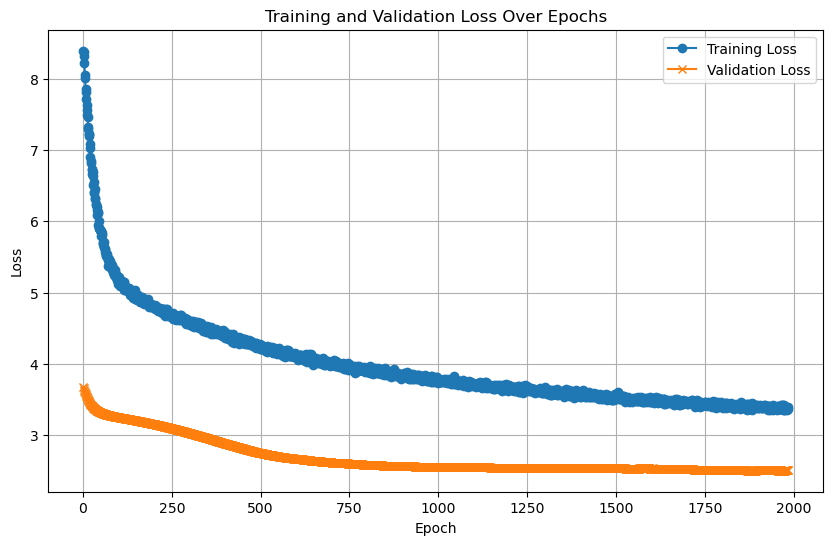

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 6.4508

Test Loss: 5.5464


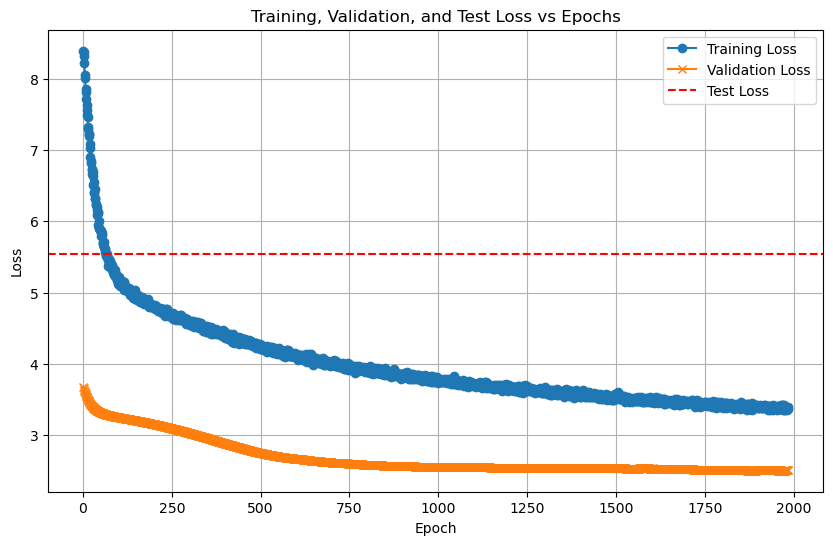

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 81.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       0.60      0.60      0.60         5
           9       0.71      1.00      0.83         5
          10       0.62      1.00      0.77         5
          11       0.67      0.80      0.73         5
          12       0.75      0.60      0.67         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8501  |  Val Loss: 2.8211
Validation loss improved from inf to 2.8211.
[Epoch 2/1000] Train Loss: 2.8106  |  Val Loss: 2.7861
Validation loss improved from 2.8211 to 2.7861.
[Epoch 3/1000] Train Loss: 2.7752  |  Val Loss: 2.7517
Validation loss improved from 2.7861 to 2.7517.
[Epoch 4/1000] Train Loss: 2.7406  |  Val Loss: 2.7184
Validation loss improved from 2.7517 to 2.7184.
[Epoch 5/1000] Train Loss: 2.7054  |  Val Loss: 2.6895
Validation loss improved from 2.7184 to 2.6895.
[Epoch 6/1000] Train Loss: 2.6761  |  Val Loss: 2.6623
Validation loss improved from 2.6895 to 2.6623.
[Epoch 7/1000] Train Loss: 2.6473  |  Val Loss: 2.6376
Validation loss improved from 2.6623 to 2.6376.
[Epoch 8/1000] Train Loss: 2.6210  |  Val Loss: 2.6145
Validation loss improved from 2.6376 to 2.6145.


[Epoch 9/1000] Train Loss: 2.5960  |  Val Loss: 2.5933
Validation loss improved from 2.6145 to 2.5933.
[Epoch 10/1000] Train Loss: 2.5740  |  Val Loss: 2.5729
Validation loss improved from 2.5933 to 2.5729.
[Epoch 11/1000] Train Loss: 2.5529  |  Val Loss: 2.5529
Validation loss improved from 2.5729 to 2.5529.
[Epoch 12/1000] Train Loss: 2.5316  |  Val Loss: 2.5341
Validation loss improved from 2.5529 to 2.5341.
[Epoch 13/1000] Train Loss: 2.5102  |  Val Loss: 2.5165
Validation loss improved from 2.5341 to 2.5165.
[Epoch 14/1000] Train Loss: 2.4913  |  Val Loss: 2.4990
Validation loss improved from 2.5165 to 2.4990.


[Epoch 15/1000] Train Loss: 2.4720  |  Val Loss: 2.4825
Validation loss improved from 2.4990 to 2.4825.
[Epoch 16/1000] Train Loss: 2.4544  |  Val Loss: 2.4644
Validation loss improved from 2.4825 to 2.4644.
[Epoch 17/1000] Train Loss: 2.4353  |  Val Loss: 2.4446
Validation loss improved from 2.4644 to 2.4446.
[Epoch 18/1000] Train Loss: 2.4152  |  Val Loss: 2.4263
Validation loss improved from 2.4446 to 2.4263.


[Epoch 19/1000] Train Loss: 2.3946  |  Val Loss: 2.4095
Validation loss improved from 2.4263 to 2.4095.
[Epoch 20/1000] Train Loss: 2.3765  |  Val Loss: 2.3925
Validation loss improved from 2.4095 to 2.3925.
[Epoch 21/1000] Train Loss: 2.3575  |  Val Loss: 2.3763
Validation loss improved from 2.3925 to 2.3763.
[Epoch 22/1000] Train Loss: 2.3399  |  Val Loss: 2.3603
Validation loss improved from 2.3763 to 2.3603.
[Epoch 23/1000] Train Loss: 2.3225  |  Val Loss: 2.3451
Validation loss improved from 2.3603 to 2.3451.
[Epoch 24/1000] Train Loss: 2.3059  |  Val Loss: 2.3305
Validation loss improved from 2.3451 to 2.3305.
[Epoch 25/1000] Train Loss: 2.2896  |  Val Loss: 2.3159
Validation loss improved from 2.3305 to 2.3159.


[Epoch 26/1000] Train Loss: 2.2725  |  Val Loss: 2.3016
Validation loss improved from 2.3159 to 2.3016.
[Epoch 27/1000] Train Loss: 2.2564  |  Val Loss: 2.2873
Validation loss improved from 2.3016 to 2.2873.
[Epoch 28/1000] Train Loss: 2.2395  |  Val Loss: 2.2732
Validation loss improved from 2.2873 to 2.2732.
[Epoch 29/1000] Train Loss: 2.2233  |  Val Loss: 2.2593
Validation loss improved from 2.2732 to 2.2593.
[Epoch 30/1000] Train Loss: 2.2064  |  Val Loss: 2.2453
Validation loss improved from 2.2593 to 2.2453.
[Epoch 31/1000] Train Loss: 2.1899  |  Val Loss: 2.2311
Validation loss improved from 2.2453 to 2.2311.
[Epoch 32/1000] Train Loss: 2.1736  |  Val Loss: 2.2169
Validation loss improved from 2.2311 to 2.2169.
[Epoch 33/1000] Train Loss: 2.1567  |  Val Loss: 2.2028
Validation loss improved from 2.2169 to 2.2028.


[Epoch 34/1000] Train Loss: 2.1399  |  Val Loss: 2.1886
Validation loss improved from 2.2028 to 2.1886.
[Epoch 35/1000] Train Loss: 2.1229  |  Val Loss: 2.1740
Validation loss improved from 2.1886 to 2.1740.
[Epoch 36/1000] Train Loss: 2.1057  |  Val Loss: 2.1590
Validation loss improved from 2.1740 to 2.1590.
[Epoch 37/1000] Train Loss: 2.0878  |  Val Loss: 2.1437
Validation loss improved from 2.1590 to 2.1437.


[Epoch 38/1000] Train Loss: 2.0700  |  Val Loss: 2.1279
Validation loss improved from 2.1437 to 2.1279.
[Epoch 39/1000] Train Loss: 2.0518  |  Val Loss: 2.1120
Validation loss improved from 2.1279 to 2.1120.
[Epoch 40/1000] Train Loss: 2.0331  |  Val Loss: 2.0961
Validation loss improved from 2.1120 to 2.0961.
[Epoch 41/1000] Train Loss: 2.0146  |  Val Loss: 2.0799
Validation loss improved from 2.0961 to 2.0799.
[Epoch 42/1000] Train Loss: 1.9959  |  Val Loss: 2.0635
Validation loss improved from 2.0799 to 2.0635.


[Epoch 43/1000] Train Loss: 1.9773  |  Val Loss: 2.0468
Validation loss improved from 2.0635 to 2.0468.
[Epoch 44/1000] Train Loss: 1.9582  |  Val Loss: 2.0302
Validation loss improved from 2.0468 to 2.0302.
[Epoch 45/1000] Train Loss: 1.9392  |  Val Loss: 2.0137
Validation loss improved from 2.0302 to 2.0137.
[Epoch 46/1000] Train Loss: 1.9203  |  Val Loss: 1.9967
Validation loss improved from 2.0137 to 1.9967.
[Epoch 47/1000] Train Loss: 1.9010  |  Val Loss: 1.9793
Validation loss improved from 1.9967 to 1.9793.
[Epoch 48/1000] Train Loss: 1.8813  |  Val Loss: 1.9622
Validation loss improved from 1.9793 to 1.9622.
[Epoch 49/1000] Train Loss: 1.8617  |  Val Loss: 1.9449
Validation loss improved from 1.9622 to 1.9449.
[Epoch 50/1000] Train Loss: 1.8422  |  Val Loss: 1.9275
Validation loss improved from 1.9449 to 1.9275.
[Epoch 51/1000] Train Loss: 1.8226  |  Val Loss: 1.9102
Validation loss improved from 1.9275 to 1.9102.


[Epoch 52/1000] Train Loss: 1.8026  |  Val Loss: 1.8929
Validation loss improved from 1.9102 to 1.8929.
[Epoch 53/1000] Train Loss: 1.7830  |  Val Loss: 1.8758
Validation loss improved from 1.8929 to 1.8758.
[Epoch 54/1000] Train Loss: 1.7630  |  Val Loss: 1.8585
Validation loss improved from 1.8758 to 1.8585.
[Epoch 55/1000] Train Loss: 1.7434  |  Val Loss: 1.8408
Validation loss improved from 1.8585 to 1.8408.
[Epoch 56/1000] Train Loss: 1.7230  |  Val Loss: 1.8232
Validation loss improved from 1.8408 to 1.8232.


[Epoch 57/1000] Train Loss: 1.7026  |  Val Loss: 1.8057
Validation loss improved from 1.8232 to 1.8057.
[Epoch 58/1000] Train Loss: 1.6822  |  Val Loss: 1.7882
Validation loss improved from 1.8057 to 1.7882.
[Epoch 59/1000] Train Loss: 1.6615  |  Val Loss: 1.7708
Validation loss improved from 1.7882 to 1.7708.


[Epoch 60/1000] Train Loss: 1.6405  |  Val Loss: 1.7535
Validation loss improved from 1.7708 to 1.7535.
[Epoch 61/1000] Train Loss: 1.6202  |  Val Loss: 1.7358
Validation loss improved from 1.7535 to 1.7358.
[Epoch 62/1000] Train Loss: 1.5987  |  Val Loss: 1.7176
Validation loss improved from 1.7358 to 1.7176.
[Epoch 63/1000] Train Loss: 1.5774  |  Val Loss: 1.6994
Validation loss improved from 1.7176 to 1.6994.
[Epoch 64/1000] Train Loss: 1.5565  |  Val Loss: 1.6810
Validation loss improved from 1.6994 to 1.6810.
[Epoch 65/1000] Train Loss: 1.5349  |  Val Loss: 1.6628
Validation loss improved from 1.6810 to 1.6628.
[Epoch 66/1000] Train Loss: 1.5138  |  Val Loss: 1.6443
Validation loss improved from 1.6628 to 1.6443.
[Epoch 67/1000] Train Loss: 1.4927  |  Val Loss: 1.6259
Validation loss improved from 1.6443 to 1.6259.
[Epoch 68/1000] Train Loss: 1.4713  |  Val Loss: 1.6076
Validation loss improved from 1.6259 to 1.6076.


[Epoch 69/1000] Train Loss: 1.4502  |  Val Loss: 1.5893
Validation loss improved from 1.6076 to 1.5893.
[Epoch 70/1000] Train Loss: 1.4291  |  Val Loss: 1.5710
Validation loss improved from 1.5893 to 1.5710.
[Epoch 71/1000] Train Loss: 1.4079  |  Val Loss: 1.5525
Validation loss improved from 1.5710 to 1.5525.
[Epoch 72/1000] Train Loss: 1.3862  |  Val Loss: 1.5344
Validation loss improved from 1.5525 to 1.5344.
[Epoch 73/1000] Train Loss: 1.3650  |  Val Loss: 1.5164
Validation loss improved from 1.5344 to 1.5164.
[Epoch 74/1000] Train Loss: 1.3437  |  Val Loss: 1.4981
Validation loss improved from 1.5164 to 1.4981.
[Epoch 75/1000] Train Loss: 1.3228  |  Val Loss: 1.4800
Validation loss improved from 1.4981 to 1.4800.


[Epoch 76/1000] Train Loss: 1.3017  |  Val Loss: 1.4623
Validation loss improved from 1.4800 to 1.4623.


[Epoch 77/1000] Train Loss: 1.2810  |  Val Loss: 1.4444
Validation loss improved from 1.4623 to 1.4444.
[Epoch 78/1000] Train Loss: 1.2607  |  Val Loss: 1.4267
Validation loss improved from 1.4444 to 1.4267.
[Epoch 79/1000] Train Loss: 1.2402  |  Val Loss: 1.4094
Validation loss improved from 1.4267 to 1.4094.
[Epoch 80/1000] Train Loss: 1.2202  |  Val Loss: 1.3920
Validation loss improved from 1.4094 to 1.3920.
[Epoch 81/1000] Train Loss: 1.2003  |  Val Loss: 1.3748
Validation loss improved from 1.3920 to 1.3748.
[Epoch 82/1000] Train Loss: 1.1805  |  Val Loss: 1.3580
Validation loss improved from 1.3748 to 1.3580.
[Epoch 83/1000] Train Loss: 1.1610  |  Val Loss: 1.3414
Validation loss improved from 1.3580 to 1.3414.
[Epoch 84/1000] Train Loss: 1.1423  |  Val Loss: 1.3249
Validation loss improved from 1.3414 to 1.3249.
[Epoch 85/1000] Train Loss: 1.1228  |  Val Loss: 1.3090
Validation loss improved from 1.3249 to 1.3090.


[Epoch 86/1000] Train Loss: 1.1038  |  Val Loss: 1.2934
Validation loss improved from 1.3090 to 1.2934.
[Epoch 87/1000] Train Loss: 1.0856  |  Val Loss: 1.2775
Validation loss improved from 1.2934 to 1.2775.
[Epoch 88/1000] Train Loss: 1.0673  |  Val Loss: 1.2624
Validation loss improved from 1.2775 to 1.2624.
[Epoch 89/1000] Train Loss: 1.0490  |  Val Loss: 1.2479
Validation loss improved from 1.2624 to 1.2479.
[Epoch 90/1000] Train Loss: 1.0312  |  Val Loss: 1.2335
Validation loss improved from 1.2479 to 1.2335.
[Epoch 91/1000] Train Loss: 1.0139  |  Val Loss: 1.2192
Validation loss improved from 1.2335 to 1.2192.
[Epoch 92/1000] Train Loss: 0.9968  |  Val Loss: 1.2048
Validation loss improved from 1.2192 to 1.2048.
[Epoch 93/1000] Train Loss: 0.9797  |  Val Loss: 1.1907
Validation loss improved from 1.2048 to 1.1907.


[Epoch 94/1000] Train Loss: 0.9629  |  Val Loss: 1.1768
Validation loss improved from 1.1907 to 1.1768.
[Epoch 95/1000] Train Loss: 0.9464  |  Val Loss: 1.1635
Validation loss improved from 1.1768 to 1.1635.
[Epoch 96/1000] Train Loss: 0.9303  |  Val Loss: 1.1503
Validation loss improved from 1.1635 to 1.1503.
[Epoch 97/1000] Train Loss: 0.9144  |  Val Loss: 1.1377
Validation loss improved from 1.1503 to 1.1377.
[Epoch 98/1000] Train Loss: 0.8987  |  Val Loss: 1.1256
Validation loss improved from 1.1377 to 1.1256.
[Epoch 99/1000] Train Loss: 0.8834  |  Val Loss: 1.1132
Validation loss improved from 1.1256 to 1.1132.
[Epoch 100/1000] Train Loss: 0.8677  |  Val Loss: 1.1016
Validation loss improved from 1.1132 to 1.1016.
[Epoch 101/1000] Train Loss: 0.8529  |  Val Loss: 1.0898
Validation loss improved from 1.1016 to 1.0898.
[Epoch 102/1000] Train Loss: 0.8381  |  Val Loss: 1.0783
Validation loss improved from 1.0898 to 1.0783.
[Epoch 103/1000] Train Loss: 0.8238  |  Val Loss: 1.0666
Vali

[Epoch 104/1000] Train Loss: 0.8094  |  Val Loss: 1.0553
Validation loss improved from 1.0666 to 1.0553.
[Epoch 105/1000] Train Loss: 0.7954  |  Val Loss: 1.0443
Validation loss improved from 1.0553 to 1.0443.
[Epoch 106/1000] Train Loss: 0.7815  |  Val Loss: 1.0336
Validation loss improved from 1.0443 to 1.0336.
[Epoch 107/1000] Train Loss: 0.7679  |  Val Loss: 1.0231
Validation loss improved from 1.0336 to 1.0231.
[Epoch 108/1000] Train Loss: 0.7547  |  Val Loss: 1.0132
Validation loss improved from 1.0231 to 1.0132.
[Epoch 109/1000] Train Loss: 0.7417  |  Val Loss: 1.0037
Validation loss improved from 1.0132 to 1.0037.
[Epoch 110/1000] Train Loss: 0.7290  |  Val Loss: 0.9946
Validation loss improved from 1.0037 to 0.9946.
[Epoch 111/1000] Train Loss: 0.7163  |  Val Loss: 0.9852
Validation loss improved from 0.9946 to 0.9852.
[Epoch 112/1000] Train Loss: 0.7037  |  Val Loss: 0.9770
Validation loss improved from 0.9852 to 0.9770.


[Epoch 113/1000] Train Loss: 0.6917  |  Val Loss: 0.9687
Validation loss improved from 0.9770 to 0.9687.
[Epoch 114/1000] Train Loss: 0.6800  |  Val Loss: 0.9593
Validation loss improved from 0.9687 to 0.9593.
[Epoch 115/1000] Train Loss: 0.6681  |  Val Loss: 0.9498
Validation loss improved from 0.9593 to 0.9498.
[Epoch 116/1000] Train Loss: 0.6564  |  Val Loss: 0.9408
Validation loss improved from 0.9498 to 0.9408.
[Epoch 117/1000] Train Loss: 0.6453  |  Val Loss: 0.9319
Validation loss improved from 0.9408 to 0.9319.
[Epoch 118/1000] Train Loss: 0.6343  |  Val Loss: 0.9225
Validation loss improved from 0.9319 to 0.9225.
[Epoch 119/1000] Train Loss: 0.6233  |  Val Loss: 0.9140
Validation loss improved from 0.9225 to 0.9140.
[Epoch 120/1000] Train Loss: 0.6126  |  Val Loss: 0.9063
Validation loss improved from 0.9140 to 0.9063.


[Epoch 121/1000] Train Loss: 0.6021  |  Val Loss: 0.8987
Validation loss improved from 0.9063 to 0.8987.
[Epoch 122/1000] Train Loss: 0.5917  |  Val Loss: 0.8912
Validation loss improved from 0.8987 to 0.8912.
[Epoch 123/1000] Train Loss: 0.5816  |  Val Loss: 0.8842
Validation loss improved from 0.8912 to 0.8842.
[Epoch 124/1000] Train Loss: 0.5717  |  Val Loss: 0.8776
Validation loss improved from 0.8842 to 0.8776.
[Epoch 125/1000] Train Loss: 0.5619  |  Val Loss: 0.8710
Validation loss improved from 0.8776 to 0.8710.
[Epoch 126/1000] Train Loss: 0.5524  |  Val Loss: 0.8638
Validation loss improved from 0.8710 to 0.8638.
[Epoch 127/1000] Train Loss: 0.5427  |  Val Loss: 0.8570
Validation loss improved from 0.8638 to 0.8570.
[Epoch 128/1000] Train Loss: 0.5336  |  Val Loss: 0.8507
Validation loss improved from 0.8570 to 0.8507.
[Epoch 129/1000] Train Loss: 0.5243  |  Val Loss: 0.8444
Validation loss improved from 0.8507 to 0.8444.


[Epoch 130/1000] Train Loss: 0.5156  |  Val Loss: 0.8380
Validation loss improved from 0.8444 to 0.8380.
[Epoch 131/1000] Train Loss: 0.5067  |  Val Loss: 0.8323
Validation loss improved from 0.8380 to 0.8323.
[Epoch 132/1000] Train Loss: 0.4982  |  Val Loss: 0.8265
Validation loss improved from 0.8323 to 0.8265.
[Epoch 133/1000] Train Loss: 0.4899  |  Val Loss: 0.8206
Validation loss improved from 0.8265 to 0.8206.
[Epoch 134/1000] Train Loss: 0.4813  |  Val Loss: 0.8155
Validation loss improved from 0.8206 to 0.8155.
[Epoch 135/1000] Train Loss: 0.4735  |  Val Loss: 0.8102
Validation loss improved from 0.8155 to 0.8102.
[Epoch 136/1000] Train Loss: 0.4656  |  Val Loss: 0.8056
Validation loss improved from 0.8102 to 0.8056.
[Epoch 137/1000] Train Loss: 0.4579  |  Val Loss: 0.8003
Validation loss improved from 0.8056 to 0.8003.
[Epoch 138/1000] Train Loss: 0.4501  |  Val Loss: 0.7950
Validation loss improved from 0.8003 to 0.7950.


[Epoch 139/1000] Train Loss: 0.4423  |  Val Loss: 0.7900
Validation loss improved from 0.7950 to 0.7900.
[Epoch 140/1000] Train Loss: 0.4350  |  Val Loss: 0.7847
Validation loss improved from 0.7900 to 0.7847.
[Epoch 141/1000] Train Loss: 0.4274  |  Val Loss: 0.7795
Validation loss improved from 0.7847 to 0.7795.
[Epoch 142/1000] Train Loss: 0.4202  |  Val Loss: 0.7739
Validation loss improved from 0.7795 to 0.7739.
[Epoch 143/1000] Train Loss: 0.4131  |  Val Loss: 0.7685
Validation loss improved from 0.7739 to 0.7685.
[Epoch 144/1000] Train Loss: 0.4062  |  Val Loss: 0.7633
Validation loss improved from 0.7685 to 0.7633.
[Epoch 145/1000] Train Loss: 0.3991  |  Val Loss: 0.7600
Validation loss improved from 0.7633 to 0.7600.
[Epoch 146/1000] Train Loss: 0.3924  |  Val Loss: 0.7563
Validation loss improved from 0.7600 to 0.7563.
[Epoch 147/1000] Train Loss: 0.3857  |  Val Loss: 0.7523
Validation loss improved from 0.7563 to 0.7523.


[Epoch 148/1000] Train Loss: 0.3792  |  Val Loss: 0.7477
Validation loss improved from 0.7523 to 0.7477.
[Epoch 149/1000] Train Loss: 0.3726  |  Val Loss: 0.7427
Validation loss improved from 0.7477 to 0.7427.
[Epoch 150/1000] Train Loss: 0.3663  |  Val Loss: 0.7377
Validation loss improved from 0.7427 to 0.7377.
[Epoch 151/1000] Train Loss: 0.3602  |  Val Loss: 0.7324
Validation loss improved from 0.7377 to 0.7324.
[Epoch 152/1000] Train Loss: 0.3543  |  Val Loss: 0.7266
Validation loss improved from 0.7324 to 0.7266.
[Epoch 153/1000] Train Loss: 0.3482  |  Val Loss: 0.7222
Validation loss improved from 0.7266 to 0.7222.
[Epoch 154/1000] Train Loss: 0.3426  |  Val Loss: 0.7186
Validation loss improved from 0.7222 to 0.7186.
[Epoch 155/1000] Train Loss: 0.3368  |  Val Loss: 0.7149
Validation loss improved from 0.7186 to 0.7149.
[Epoch 156/1000] Train Loss: 0.3314  |  Val Loss: 0.7101
Validation loss improved from 0.7149 to 0.7101.


[Epoch 157/1000] Train Loss: 0.3261  |  Val Loss: 0.7062
Validation loss improved from 0.7101 to 0.7062.
[Epoch 158/1000] Train Loss: 0.3204  |  Val Loss: 0.7028
Validation loss improved from 0.7062 to 0.7028.
[Epoch 159/1000] Train Loss: 0.3153  |  Val Loss: 0.6998
Validation loss improved from 0.7028 to 0.6998.
[Epoch 160/1000] Train Loss: 0.3098  |  Val Loss: 0.6979
Validation loss improved from 0.6998 to 0.6979.
[Epoch 161/1000] Train Loss: 0.3049  |  Val Loss: 0.6948
Validation loss improved from 0.6979 to 0.6948.
[Epoch 162/1000] Train Loss: 0.2998  |  Val Loss: 0.6915
Validation loss improved from 0.6948 to 0.6915.
[Epoch 163/1000] Train Loss: 0.2948  |  Val Loss: 0.6866
Validation loss improved from 0.6915 to 0.6866.
[Epoch 164/1000] Train Loss: 0.2899  |  Val Loss: 0.6829
Validation loss improved from 0.6866 to 0.6829.
[Epoch 165/1000] Train Loss: 0.2852  |  Val Loss: 0.6789
Validation loss improved from 0.6829 to 0.6789.
[Epoch 166/1000] Train Loss: 0.2806  |  Val Loss: 0.675

[Epoch 168/1000] Train Loss: 0.2715  |  Val Loss: 0.6688
Validation loss improved from 0.6724 to 0.6688.
[Epoch 169/1000] Train Loss: 0.2672  |  Val Loss: 0.6669
Validation loss improved from 0.6688 to 0.6669.
[Epoch 170/1000] Train Loss: 0.2629  |  Val Loss: 0.6639
Validation loss improved from 0.6669 to 0.6639.
[Epoch 171/1000] Train Loss: 0.2585  |  Val Loss: 0.6620
Validation loss improved from 0.6639 to 0.6620.
[Epoch 172/1000] Train Loss: 0.2543  |  Val Loss: 0.6599
Validation loss improved from 0.6620 to 0.6599.
[Epoch 173/1000] Train Loss: 0.2503  |  Val Loss: 0.6580
Validation loss improved from 0.6599 to 0.6580.


[Epoch 174/1000] Train Loss: 0.2465  |  Val Loss: 0.6549
Validation loss improved from 0.6580 to 0.6549.
[Epoch 175/1000] Train Loss: 0.2424  |  Val Loss: 0.6528
Validation loss improved from 0.6549 to 0.6528.
[Epoch 176/1000] Train Loss: 0.2386  |  Val Loss: 0.6511
Validation loss improved from 0.6528 to 0.6511.
[Epoch 177/1000] Train Loss: 0.2349  |  Val Loss: 0.6486
Validation loss improved from 0.6511 to 0.6486.
[Epoch 178/1000] Train Loss: 0.2309  |  Val Loss: 0.6467
Validation loss improved from 0.6486 to 0.6467.
[Epoch 179/1000] Train Loss: 0.2275  |  Val Loss: 0.6449
Validation loss improved from 0.6467 to 0.6449.
[Epoch 180/1000] Train Loss: 0.2236  |  Val Loss: 0.6432
Validation loss improved from 0.6449 to 0.6432.
[Epoch 181/1000] Train Loss: 0.2201  |  Val Loss: 0.6406
Validation loss improved from 0.6432 to 0.6406.
[Epoch 182/1000] Train Loss: 0.2167  |  Val Loss: 0.6378
Validation loss improved from 0.6406 to 0.6378.
[Epoch 183/1000] Train Loss: 0.2133  |  Val Loss: 0.635

[Epoch 187/1000] Train Loss: 0.1999  |  Val Loss: 0.6264
Validation loss improved from 0.6287 to 0.6264.
[Epoch 188/1000] Train Loss: 0.1966  |  Val Loss: 0.6251
Validation loss improved from 0.6264 to 0.6251.
[Epoch 189/1000] Train Loss: 0.1935  |  Val Loss: 0.6247
Validation loss improved from 0.6251 to 0.6247.
[Epoch 190/1000] Train Loss: 0.1901  |  Val Loss: 0.6227
Validation loss improved from 0.6247 to 0.6227.
[Epoch 191/1000] Train Loss: 0.1869  |  Val Loss: 0.6208
Validation loss improved from 0.6227 to 0.6208.


[Epoch 192/1000] Train Loss: 0.1837  |  Val Loss: 0.6191
Validation loss improved from 0.6208 to 0.6191.
[Epoch 193/1000] Train Loss: 0.1805  |  Val Loss: 0.6182
Validation loss improved from 0.6191 to 0.6182.
[Epoch 194/1000] Train Loss: 0.1774  |  Val Loss: 0.6166
Validation loss improved from 0.6182 to 0.6166.
[Epoch 195/1000] Train Loss: 0.1744  |  Val Loss: 0.6154
Validation loss improved from 0.6166 to 0.6154.
[Epoch 196/1000] Train Loss: 0.1712  |  Val Loss: 0.6157
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 197/1000] Train Loss: 0.1681  |  Val Loss: 0.6153
Validation loss improved from 0.6154 to 0.6153.
[Epoch 198/1000] Train Loss: 0.1652  |  Val Loss: 0.6144
Validation loss improved from 0.6153 to 0.6144.
[Epoch 199/1000] Train Loss: 0.1622  |  Val Loss: 0.6129
Validation loss improved from 0.6144 to 0.6129.
[Epoch 200/1000] Train Loss: 0.1593  |  Val Loss: 0.6111
Validation loss improved from 0.6129 to 0.6111.
[Epoch 201/1000] Train Loss: 0.1564  |  Val Loss:

[Epoch 205/1000] Train Loss: 0.1460  |  Val Loss: 0.6016
Validation loss improved from 0.6023 to 0.6016.
[Epoch 206/1000] Train Loss: 0.1437  |  Val Loss: 0.6038
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 0.1409  |  Val Loss: 0.6032
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 0.1387  |  Val Loss: 0.6017
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 0.1366  |  Val Loss: 0.6001
Validation loss improved from 0.6016 to 0.6001.


[Epoch 210/1000] Train Loss: 0.1343  |  Val Loss: 0.5980
Validation loss improved from 0.6001 to 0.5980.
[Epoch 211/1000] Train Loss: 0.1321  |  Val Loss: 0.5968
Validation loss improved from 0.5980 to 0.5968.
[Epoch 212/1000] Train Loss: 0.1300  |  Val Loss: 0.5953
Validation loss improved from 0.5968 to 0.5953.
[Epoch 213/1000] Train Loss: 0.1279  |  Val Loss: 0.5937
Validation loss improved from 0.5953 to 0.5937.
[Epoch 214/1000] Train Loss: 0.1260  |  Val Loss: 0.5918
Validation loss improved from 0.5937 to 0.5918.
[Epoch 215/1000] Train Loss: 0.1242  |  Val Loss: 0.5912
Validation loss improved from 0.5918 to 0.5912.
[Epoch 216/1000] Train Loss: 0.1223  |  Val Loss: 0.5910
Validation loss improved from 0.5912 to 0.5910.
[Epoch 217/1000] Train Loss: 0.1204  |  Val Loss: 0.5913
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 218/1000] Train Loss: 0.1186  |  Val Loss: 0.5913
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 219/1000] Train Loss: 0.1167  |  Val

[Epoch 222/1000] Train Loss: 0.1120  |  Val Loss: 0.5917
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 223/1000] Train Loss: 0.1102  |  Val Loss: 0.5896
Validation loss improved from 0.5910 to 0.5896.
[Epoch 224/1000] Train Loss: 0.1086  |  Val Loss: 0.5877
Validation loss improved from 0.5896 to 0.5877.
[Epoch 225/1000] Train Loss: 0.1071  |  Val Loss: 0.5862
Validation loss improved from 0.5877 to 0.5862.
[Epoch 226/1000] Train Loss: 0.1055  |  Val Loss: 0.5846
Validation loss improved from 0.5862 to 0.5846.


[Epoch 227/1000] Train Loss: 0.1041  |  Val Loss: 0.5832
Validation loss improved from 0.5846 to 0.5832.
[Epoch 228/1000] Train Loss: 0.1026  |  Val Loss: 0.5830
Validation loss improved from 0.5832 to 0.5830.
[Epoch 229/1000] Train Loss: 0.1011  |  Val Loss: 0.5823
Validation loss improved from 0.5830 to 0.5823.
[Epoch 230/1000] Train Loss: 0.0998  |  Val Loss: 0.5823
Validation loss improved from 0.5823 to 0.5823.
[Epoch 231/1000] Train Loss: 0.0986  |  Val Loss: 0.5794
Validation loss improved from 0.5823 to 0.5794.
[Epoch 232/1000] Train Loss: 0.0973  |  Val Loss: 0.5790
Validation loss improved from 0.5794 to 0.5790.
[Epoch 233/1000] Train Loss: 0.0959  |  Val Loss: 0.5785
Validation loss improved from 0.5790 to 0.5785.
[Epoch 234/1000] Train Loss: 0.0945  |  Val Loss: 0.5784
Validation loss improved from 0.5785 to 0.5784.
[Epoch 235/1000] Train Loss: 0.0933  |  Val Loss: 0.5799
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 0.0921  |  Val Loss:

[Epoch 241/1000] Train Loss: 0.0864  |  Val Loss: 0.5799
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 242/1000] Train Loss: 0.0852  |  Val Loss: 0.5783
Validation loss improved from 0.5784 to 0.5783.
[Epoch 243/1000] Train Loss: 0.0841  |  Val Loss: 0.5760
Validation loss improved from 0.5783 to 0.5760.


[Epoch 244/1000] Train Loss: 0.0831  |  Val Loss: 0.5755
Validation loss improved from 0.5760 to 0.5755.
[Epoch 245/1000] Train Loss: 0.0821  |  Val Loss: 0.5755
Validation loss improved from 0.5755 to 0.5755.
[Epoch 246/1000] Train Loss: 0.0810  |  Val Loss: 0.5763
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 0.0801  |  Val Loss: 0.5773
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 248/1000] Train Loss: 0.0791  |  Val Loss: 0.5754
Validation loss improved from 0.5755 to 0.5754.
[Epoch 249/1000] Train Loss: 0.0781  |  Val Loss: 0.5749
Validation loss improved from 0.5754 to 0.5749.
[Epoch 250/1000] Train Loss: 0.0775  |  Val Loss: 0.5747
Validation loss improved from 0.5749 to 0.5747.
[Epoch 251/1000] Train Loss: 0.0764  |  Val Loss: 0.5760
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.0755  |  Val Loss: 0.5769
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.

[Epoch 258/1000] Train Loss: 0.0703  |  Val Loss: 0.5802
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 259/1000] Train Loss: 0.0694  |  Val Loss: 0.5801
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 260/1000] Train Loss: 0.0688  |  Val Loss: 0.5825
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 261/1000] Train Loss: 0.0679  |  Val Loss: 0.5801
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 262/1000] Train Loss: 0.0673  |  Val Loss: 0.5788
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 263/1000] Train Loss: 0.0665  |  Val Loss: 0.5828
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 264/1000] Train Loss: 0.0657  |  Val Loss: 0.5846
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 265/1000] Train Loss: 0.0650  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 266/1000] Train Loss: 0.0642  |  Val Loss: 0.5839
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 267/1000] Train Loss: 0.0635  |  Val Loss: 0.5838
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 268/1000] Train Loss: 0.0627  |  Val Loss: 0.5827
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 269/1000] Train Loss: 0.0621  |  Val Loss: 0.5807
!! Validation loss did NOT improve !! Patience:

[Epoch 277/1000] Train Loss: 0.0570  |  Val Loss: 0.5807
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 278/1000] Train Loss: 0.0563  |  Val Loss: 0.5839
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 279/1000] Train Loss: 0.0558  |  Val Loss: 0.5849
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 280/1000] Train Loss: 0.0553  |  Val Loss: 0.5852
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 281/1000] Train Loss: 0.0547  |  Val Loss: 0.5847
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 282/1000] Train Loss: 0.0541  |  Val Loss: 0.5829
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 283/1000] Train Loss: 0.0540  |  Val Loss: 0.5795
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 284/1000] Train Loss: 0.0530  |  Val Loss: 0.5814
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 285/1000] Train Loss: 0.0526  |  Val Loss: 0.5838
!! Validation loss did NOT improve !! Patience:

[Epoch 295/1000] Train Loss: 0.0476  |  Val Loss: 0.5819
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 296/1000] Train Loss: 0.0473  |  Val Loss: 0.5822
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 297/1000] Train Loss: 0.0468  |  Val Loss: 0.5831
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 298/1000] Train Loss: 0.0463  |  Val Loss: 0.5842
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 299/1000] Train Loss: 0.0458  |  Val Loss: 0.5852
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 300/1000] Train Loss: 0.0454  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 301/1000] Train Loss: 0.0450  |  Val Loss: 0.5873
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 302/1000] Train Loss: 0.0446  |  Val Loss: 0.5883
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 303/1000] Train Loss: 0.0443  |  Val Loss: 0.5894
!! Validation loss did NOT improve !! Patience:

[Epoch 314/1000] Train Loss: 0.0401  |  Val Loss: 0.5892
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 315/1000] Train Loss: 0.0398  |  Val Loss: 0.5899
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 316/1000] Train Loss: 0.0395  |  Val Loss: 0.5895
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 317/1000] Train Loss: 0.0392  |  Val Loss: 0.5913
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 318/1000] Train Loss: 0.0387  |  Val Loss: 0.5925
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 319/1000] Train Loss: 0.0384  |  Val Loss: 0.5927
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 320/1000] Train Loss: 0.0383  |  Val Loss: 0.5900
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 321/1000] Train Loss: 0.0377  |  Val Loss: 0.5926
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 322/1000] Train Loss: 0.0374  |  Val Loss: 0.5938
!! Validation loss did NOT improve !! Patience:

[Epoch 331/1000] Train Loss: 0.0351  |  Val Loss: 0.5912
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 332/1000] Train Loss: 0.0349  |  Val Loss: 0.5926
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 333/1000] Train Loss: 0.0345  |  Val Loss: 0.5952
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 334/1000] Train Loss: 0.0342  |  Val Loss: 0.5988
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 335/1000] Train Loss: 0.0337  |  Val Loss: 0.6007
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 336/1000] Train Loss: 0.0334  |  Val Loss: 0.6010
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 337/1000] Train Loss: 0.0332  |  Val Loss: 0.6009
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 338/1000] Train Loss: 0.0329  |  Val Loss: 0.6049
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 339/1000] Train Loss: 0.0328  |  Val Loss: 0.6082
!! Validation loss did NOT improve !! Patience:

[Epoch 349/1000] Train Loss: 0.0304  |  Val Loss: 0.5991
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 350/1000] Train Loss: 0.0301  |  Val Loss: 0.6008
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 350 !!
No improvement for 100 epochs.


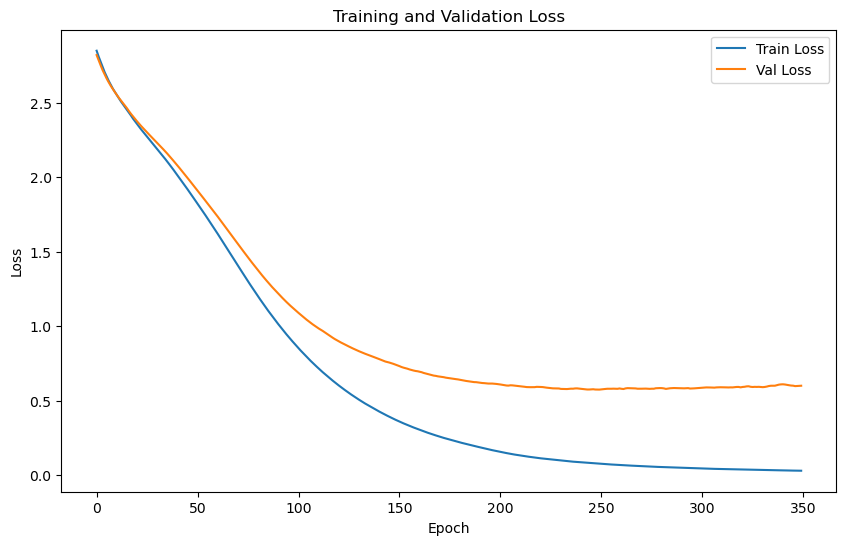

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.4024 | Test Accuracy: 88.68%


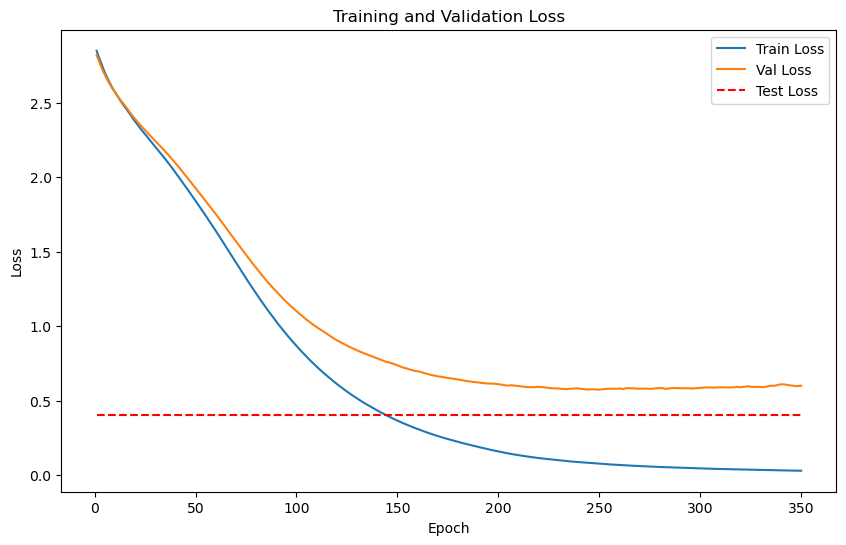

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.1759
Epoch [1/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.3241

Validation loss improved from inf to 0.3241. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.1772
Epoch [2/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.1784
Epoch [3/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.3248

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.1793
Epoch [4/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.3249

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4838
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.1791
Epoch [5/2000], Avg Train Loss: 0.4838, Avg Val Loss: 0.3248

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.1787
Epoch [6/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.3245

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.1787
Epoch [7/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.3243

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.1786
Epoch [8/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.3240

Validation loss improved from 0.3241 to 0.3240. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.1782
Epoch [9/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3234

Validation loss improved from 0.3240 to 0.3234. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.1766
Epoch [10/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.3223

Validation loss improved from 0.3234 to 0.3223. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.1745
Epoch [11/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.3210

Validation loss improved from 0.3223 to 0.3210. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.1705
Epoch [12/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.3188

Validation loss improved from 0.3210 to 0.3188. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.1684
Epoch [13/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3177

Validation loss improved from 0.3188 to 0.3177. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.1690
Epoch [14/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.1671
Epoch [15/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.3167

Validation loss improved from 0.3177 to 0.3167. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.1634
Epoch [16/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.3145

Validation loss improved from 0.3167 to 0.3145. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.1608
Epoch [17/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.3129

Validation loss improved from 0.3145 to 0.3129. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.1571
Epoch [18/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.3105

Validation loss improved from 0.3129 to 0.3105. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.1516
Epoch [19/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.3073

Validation loss improved from 0.3105 to 0.3073. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.1461
Epoch [20/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.3037

Validation loss improved from 0.3073 to 0.3037. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.1405
Epoch [21/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.2993

Validation loss improved from 0.3037 to 0.2993. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.1348
Epoch [22/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.2954

Validation loss improved from 0.2993 to 0.2954. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.1296
Epoch [23/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.2916

Validation loss improved from 0.2954 to 0.2916. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.1249
Epoch [24/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.2886

Validation loss improved from 0.2916 to 0.2886. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.1213
Epoch [25/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.2862

Validation loss improved from 0.2886 to 0.2862. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.1193
Epoch [26/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.2849

Validation loss improved from 0.2862 to 0.2849. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.1178
Epoch [27/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.2839

Validation loss improved from 0.2849 to 0.2839. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.1166
Epoch [28/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.2830

Validation loss improved from 0.2839 to 0.2830. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.1159
Epoch [29/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.2824

Validation loss improved from 0.2830 to 0.2824. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.1154
Epoch [30/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.2822

Validation loss improved from 0.2824 to 0.2822. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.1150
Epoch [31/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.1146
Epoch [32/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.2822

Validation loss improved from 0.2822 to 0.2822. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.1144
Epoch [33/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.2821

Validation loss improved from 0.2822 to 0.2821. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.1143
Epoch [34/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.1145
Epoch [35/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.1147
Epoch [36/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.1148
Epoch [37/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.2825

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.1150
Epoch [38/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.2824

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.1151
Epoch [39/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.2823

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.1153
Epoch [40/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.1153
Epoch [41/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.2820

Validation loss improved from 0.2821 to 0.2820. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.1153
Epoch [42/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.2818

Validation loss improved from 0.2820 to 0.2818. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.1154
Epoch [43/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.2816

Validation loss improved from 0.2818 to 0.2816. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4473
    Batch [2/2], Val Loss: 0.1156
Epoch [44/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4468
    Batch [2/2], Val Loss: 0.1158
Epoch [45/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.2813

Validation loss improved from 0.2815 to 0.2813. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.1159
Epoch [46/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.2811

Validation loss improved from 0.2813 to 0.2811. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4456
    Batch [2/2], Val Loss: 0.1161
Epoch [47/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.2809

Validation loss improved from 0.2811 to 0.2809. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.1163
Epoch [48/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.2806

Validation loss improved from 0.2809 to 0.2806. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4443
    Batch [2/2], Val Loss: 0.1165
Epoch [49/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.2804

Validation loss improved from 0.2806 to 0.2804. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.1165
Epoch [50/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.2801

Validation loss improved from 0.2804 to 0.2801. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.1165
Epoch [51/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.2798

Validation loss improved from 0.2801 to 0.2798. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.1166
Epoch [52/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.2795

Validation loss improved from 0.2798 to 0.2795. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.1166
Epoch [53/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.2793

Validation loss improved from 0.2795 to 0.2793. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.1167
Epoch [54/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.2791

Validation loss improved from 0.2793 to 0.2791. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4412
    Batch [2/2], Val Loss: 0.1168
Epoch [55/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.2790

Validation loss improved from 0.2791 to 0.2790. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.1168
Epoch [56/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.2788

Validation loss improved from 0.2790 to 0.2788. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.1168
Epoch [57/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.2787

Validation loss improved from 0.2788 to 0.2787. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.1170
Epoch [58/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.2786

Validation loss improved from 0.2787 to 0.2786. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.1171
Epoch [59/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.2785

Validation loss improved from 0.2786 to 0.2785. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.1171
Epoch [60/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.2783

Validation loss improved from 0.2785 to 0.2783. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.1171
Epoch [61/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.2781

Validation loss improved from 0.2783 to 0.2781. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.1171
Epoch [62/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2778

Validation loss improved from 0.2781 to 0.2778. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.1172
Epoch [63/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.2773

Validation loss improved from 0.2778 to 0.2773. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.1171
Epoch [64/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.2769

Validation loss improved from 0.2773 to 0.2769. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.1171
Epoch [65/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2764

Validation loss improved from 0.2769 to 0.2764. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.1174
Epoch [66/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.2760

Validation loss improved from 0.2764 to 0.2760. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1179
Epoch [67/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.2760

Validation loss improved from 0.2760 to 0.2760. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.1186
Epoch [68/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.2760

Validation loss improved from 0.2760 to 0.2760. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4330
    Batch [2/2], Val Loss: 0.1192
Epoch [69/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2761

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4328
    Batch [2/2], Val Loss: 0.1199
Epoch [70/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2763

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1205
Epoch [71/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2765

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1211
Epoch [72/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2768

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1218
Epoch [73/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.2771

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.1224
Epoch [74/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2773

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.1229
Epoch [75/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.2775

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.1232
Epoch [76/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.1234
Epoch [77/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2777

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.1235
Epoch [78/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1237
Epoch [79/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2781

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.1238
Epoch [80/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2782

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.1237
Epoch [81/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2782

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.1233
Epoch [82/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.1230
Epoch [83/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2776

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.1226
Epoch [84/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2772

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.1218
Epoch [85/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2765

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1210
Epoch [86/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.2758

Validation loss improved from 0.2760 to 0.2758. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.1202
Epoch [87/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2751

Validation loss improved from 0.2758 to 0.2751. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.1193
Epoch [88/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.2742

Validation loss improved from 0.2751 to 0.2742. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.1187
Epoch [89/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2735

Validation loss improved from 0.2742 to 0.2735. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.1178
Epoch [90/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2727

Validation loss improved from 0.2735 to 0.2727. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.1168
Epoch [91/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2719

Validation loss improved from 0.2727 to 0.2719. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1158
Epoch [92/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2711

Validation loss improved from 0.2719 to 0.2711. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1151
Epoch [93/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2705

Validation loss improved from 0.2711 to 0.2705. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1144
Epoch [94/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2697

Validation loss improved from 0.2705 to 0.2697. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1136
Epoch [95/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2689

Validation loss improved from 0.2697 to 0.2689. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1130
Epoch [96/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2683

Validation loss improved from 0.2689 to 0.2683. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.1124
Epoch [97/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2677

Validation loss improved from 0.2683 to 0.2677. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.1119
Epoch [98/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.2670

Validation loss improved from 0.2677 to 0.2670. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.1112
Epoch [99/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2660

Validation loss improved from 0.2670 to 0.2660. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1108
Epoch [100/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2653

Validation loss improved from 0.2660 to 0.2653. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.1102
Epoch [101/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2644

Validation loss improved from 0.2653 to 0.2644. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.1096
Epoch [102/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2637

Validation loss improved from 0.2644 to 0.2637. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.1089
Epoch [103/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2630

Validation loss improved from 0.2637 to 0.2630. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.1083
Epoch [104/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2624

Validation loss improved from 0.2630 to 0.2624. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.1081
Epoch [105/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2620

Validation loss improved from 0.2624 to 0.2620. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.1080
Epoch [106/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2617

Validation loss improved from 0.2620 to 0.2617. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1081
Epoch [107/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1083
Epoch [108/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2617

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4152
    Batch [2/2], Val Loss: 0.1085
Epoch [109/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.1084
Epoch [110/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.1082
Epoch [111/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2614

Validation loss improved from 0.2616 to 0.2614. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1080
Epoch [112/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2611

Validation loss improved from 0.2614 to 0.2611. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.1079
Epoch [113/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2608

Validation loss improved from 0.2611 to 0.2608. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.1074
Epoch [114/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2604

Validation loss improved from 0.2608 to 0.2604. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.1069
Epoch [115/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2600

Validation loss improved from 0.2604 to 0.2600. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.1063
Epoch [116/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2597

Validation loss improved from 0.2600 to 0.2597. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1057
Epoch [117/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2592

Validation loss improved from 0.2597 to 0.2592. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.1053
Epoch [118/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2590

Validation loss improved from 0.2592 to 0.2590. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.1048
Epoch [119/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2585

Validation loss improved from 0.2590 to 0.2585. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.1042
Epoch [120/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2579

Validation loss improved from 0.2585 to 0.2579. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.1034
Epoch [121/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2573

Validation loss improved from 0.2579 to 0.2573. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.1027
Epoch [122/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2568

Validation loss improved from 0.2573 to 0.2568. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.1022
Epoch [123/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2565

Validation loss improved from 0.2568 to 0.2565. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.1016
Epoch [124/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2562

Validation loss improved from 0.2565 to 0.2562. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.1014
Epoch [125/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.1013
Epoch [126/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.1009
Epoch [127/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2559

Validation loss improved from 0.2561 to 0.2559. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.1007
Epoch [128/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2556

Validation loss improved from 0.2559 to 0.2556. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.1005
Epoch [129/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2554

Validation loss improved from 0.2556 to 0.2554. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.1008
Epoch [130/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.1009
Epoch [131/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.1011
Epoch [132/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.1013
Epoch [133/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.1014
Epoch [134/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2554

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.1016
Epoch [135/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2551

Validation loss improved from 0.2554 to 0.2551. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.1017
Epoch [136/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2548

Validation loss improved from 0.2551 to 0.2548. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1020
Epoch [137/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.1023
Epoch [138/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2543

Validation loss improved from 0.2547 to 0.2543. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.1024
Epoch [139/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2539

Validation loss improved from 0.2543 to 0.2539. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.1026
Epoch [140/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2535

Validation loss improved from 0.2539 to 0.2535. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.1027
Epoch [141/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2532

Validation loss improved from 0.2535 to 0.2532. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.1027
Epoch [142/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2530

Validation loss improved from 0.2532 to 0.2530. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.1028
Epoch [143/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.1029
Epoch [144/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2527

Validation loss improved from 0.2529 to 0.2527. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.1029
Epoch [145/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.2525

Validation loss improved from 0.2527 to 0.2525. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.1027
Epoch [146/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2522

Validation loss improved from 0.2525 to 0.2522. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.1026
Epoch [147/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2519

Validation loss improved from 0.2522 to 0.2519. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4008
    Batch [2/2], Val Loss: 0.1023
Epoch [148/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2515

Validation loss improved from 0.2519 to 0.2515. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.1019
Epoch [149/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2513

Validation loss improved from 0.2515 to 0.2513. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.1014
Epoch [150/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2511

Validation loss improved from 0.2513 to 0.2511. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.1008
Epoch [151/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2507

Validation loss improved from 0.2511 to 0.2507. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.1000
Epoch [152/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2505

Validation loss improved from 0.2507 to 0.2505. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4009
    Batch [2/2], Val Loss: 0.0989
Epoch [153/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2499

Validation loss improved from 0.2505 to 0.2499. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3961
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.0979
Epoch [154/2000], Avg Train Loss: 0.3961, Avg Val Loss: 0.2492

Validation loss improved from 0.2499 to 0.2492. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0973
Epoch [155/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2486

Validation loss improved from 0.2492 to 0.2486. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.0968
Epoch [156/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2479

Validation loss improved from 0.2486 to 0.2479. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.0963
Epoch [157/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2472

Validation loss improved from 0.2479 to 0.2472. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0959
Epoch [158/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2467

Validation loss improved from 0.2472 to 0.2467. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0953
Epoch [159/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2461

Validation loss improved from 0.2467 to 0.2461. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.0950
Epoch [160/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2457

Validation loss improved from 0.2461 to 0.2457. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0947
Epoch [161/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2454

Validation loss improved from 0.2457 to 0.2454. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0943
Epoch [162/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2452

Validation loss improved from 0.2454 to 0.2452. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0939
Epoch [163/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2450

Validation loss improved from 0.2452 to 0.2450. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.3960
    Batch [2/2], Val Loss: 0.0936
Epoch [164/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2448

Validation loss improved from 0.2450 to 0.2448. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.0938
Epoch [165/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3953
    Batch [2/2], Val Loss: 0.0943
Epoch [166/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0950
Epoch [167/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3948
    Batch [2/2], Val Loss: 0.0953
Epoch [168/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.0953
Epoch [169/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.0952
Epoch [170/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.0951
Epoch [171/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.0946
Epoch [172/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2443

Validation loss improved from 0.2447 to 0.2443. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3804
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.0939
Epoch [173/2000], Avg Train Loss: 0.3804, Avg Val Loss: 0.2434

Validation loss improved from 0.2443 to 0.2434. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3918
    Batch [2/2], Val Loss: 0.0933
Epoch [174/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2426

Validation loss improved from 0.2434 to 0.2426. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.0930
Epoch [175/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2420

Validation loss improved from 0.2426 to 0.2420. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.0928
Epoch [176/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2414

Validation loss improved from 0.2420 to 0.2414. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.0925
Epoch [177/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2409

Validation loss improved from 0.2414 to 0.2409. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0921
Epoch [178/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2402

Validation loss improved from 0.2409 to 0.2402. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0915
Epoch [179/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2395

Validation loss improved from 0.2402 to 0.2395. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0910
Epoch [180/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2391

Validation loss improved from 0.2395 to 0.2391. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0907
Epoch [181/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2388

Validation loss improved from 0.2391 to 0.2388. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0901
Epoch [182/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2385

Validation loss improved from 0.2388 to 0.2385. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3868
    Batch [2/2], Val Loss: 0.0899
Epoch [183/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.0898
Epoch [184/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.2382

Validation loss improved from 0.2384 to 0.2382. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0897
Epoch [185/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2381

Validation loss improved from 0.2382 to 0.2381. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.0897
Epoch [186/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0896
Epoch [187/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2383

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0898
Epoch [188/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2385

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0898
Epoch [189/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2385

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.0902
Epoch [190/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2388

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0906
Epoch [191/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0909
Epoch [192/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2390

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0912
Epoch [193/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.0915
Epoch [194/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2395

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0914
Epoch [195/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0914
Epoch [196/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0915
Epoch [197/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.0916
Epoch [198/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2394

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0918
Epoch [199/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2397

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.0918
Epoch [200/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.0922
Epoch [201/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.0924
Epoch [202/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2404

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.0923
Epoch [203/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2404

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.0920
Epoch [204/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2402

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.0913
Epoch [205/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2396

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0907
Epoch [206/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2391

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.0897
Epoch [207/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2386

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0889
Epoch [208/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2381

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.0881
Epoch [209/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2374

Validation loss improved from 0.2381 to 0.2374. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.0870
Epoch [210/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2362

Validation loss improved from 0.2374 to 0.2362. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.0861
Epoch [211/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2351

Validation loss improved from 0.2362 to 0.2351. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.0853
Epoch [212/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2341

Validation loss improved from 0.2351 to 0.2341. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3811
    Batch [2/2], Val Loss: 0.0844
Epoch [213/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2328

Validation loss improved from 0.2341 to 0.2328. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.0839
Epoch [214/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2318

Validation loss improved from 0.2328 to 0.2318. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.0834
Epoch [215/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2311

Validation loss improved from 0.2318 to 0.2311. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.0832
Epoch [216/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2310

Validation loss improved from 0.2311 to 0.2310. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.0831
Epoch [217/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.0832
Epoch [218/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.0835
Epoch [219/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2310

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.0839
Epoch [220/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.0844
Epoch [221/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3795
    Batch [2/2], Val Loss: 0.0848
Epoch [222/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.0849
Epoch [223/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2324

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.0851
Epoch [224/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.0853
Epoch [225/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3832
    Batch [2/2], Val Loss: 0.0855
Epoch [226/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.0857
Epoch [227/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.0860
Epoch [228/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0861
Epoch [229/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.0857
Epoch [230/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.0853
Epoch [231/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2355

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.0849
Epoch [232/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.0843
Epoch [233/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.0839
Epoch [234/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2331

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.0836
Epoch [235/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2325

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.0834
Epoch [236/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.0833
Epoch [237/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.0830
Epoch [238/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2314

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3794
    Batch [2/2], Val Loss: 0.0830
Epoch [239/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.0832
Epoch [240/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.0836
Epoch [241/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3812
    Batch [2/2], Val Loss: 0.0838
Epoch [242/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2325

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.0834
Epoch [243/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2314

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.0831
Epoch [244/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.2303

Validation loss improved from 0.2309 to 0.2303. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.0828
Epoch [245/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2293

Validation loss improved from 0.2303 to 0.2293. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.0825
Epoch [246/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2284

Validation loss improved from 0.2293 to 0.2284. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.0823
Epoch [247/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2276

Validation loss improved from 0.2284 to 0.2276. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3716
    Batch [2/2], Val Loss: 0.0822
Epoch [248/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2269

Validation loss improved from 0.2276 to 0.2269. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.0821
Epoch [249/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.2263

Validation loss improved from 0.2269 to 0.2263. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.0820
Epoch [250/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2257

Validation loss improved from 0.2263 to 0.2257. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.0819
Epoch [251/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2252

Validation loss improved from 0.2257 to 0.2252. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.0818
Epoch [252/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.2248

Validation loss improved from 0.2252 to 0.2248. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.0816
Epoch [253/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2245

Validation loss improved from 0.2248 to 0.2245. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.0815
Epoch [254/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2242

Validation loss improved from 0.2245 to 0.2242. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.0814
Epoch [255/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2239

Validation loss improved from 0.2242 to 0.2239. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.0813
Epoch [256/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2236

Validation loss improved from 0.2239 to 0.2236. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.0812
Epoch [257/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2234

Validation loss improved from 0.2236 to 0.2234. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.0811
Epoch [258/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2231

Validation loss improved from 0.2234 to 0.2231. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.0810
Epoch [259/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.0809
Epoch [260/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2227

Validation loss improved from 0.2229 to 0.2227. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.0808
Epoch [261/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.0808
Epoch [262/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0807
Epoch [263/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2225

Validation loss improved from 0.2225 to 0.2225. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.0807
Epoch [264/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2224

Validation loss improved from 0.2225 to 0.2224. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0806
Epoch [265/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0806
Epoch [266/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2223

Validation loss improved from 0.2224 to 0.2223. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.0806
Epoch [267/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2223

Validation loss improved from 0.2223 to 0.2223. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0805
Epoch [268/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2223

Validation loss improved from 0.2223 to 0.2223. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0805
Epoch [269/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2222

Validation loss improved from 0.2223 to 0.2222. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0805
Epoch [270/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2222

Validation loss improved from 0.2222 to 0.2222. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.0804
Epoch [271/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2222

Validation loss improved from 0.2222 to 0.2222. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.0804
Epoch [272/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2222

Validation loss improved from 0.2222 to 0.2222. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.0804
Epoch [273/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2221

Validation loss improved from 0.2222 to 0.2221. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.0804
Epoch [274/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.0804
Epoch [275/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2221

Validation loss improved from 0.2221 to 0.2221. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.0803
Epoch [276/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2220

Validation loss improved from 0.2221 to 0.2220. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.0803
Epoch [277/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0803
Epoch [278/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2220

Validation loss improved from 0.2220 to 0.2220. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0802
Epoch [279/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2219

Validation loss improved from 0.2220 to 0.2219. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.0802
Epoch [280/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2219

Validation loss improved from 0.2219 to 0.2219. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.0802
Epoch [281/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2219

Validation loss improved from 0.2219 to 0.2219. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.0802
Epoch [282/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2219

Validation loss improved from 0.2219 to 0.2219. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.0802
Epoch [283/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2218

Validation loss improved from 0.2219 to 0.2218. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0803
Epoch [284/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.2218

Validation loss improved from 0.2218 to 0.2218. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0803
Epoch [285/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2218

Validation loss improved from 0.2218 to 0.2218. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.0803
Epoch [286/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2218

Validation loss improved from 0.2218 to 0.2218. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.0803
Epoch [287/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2217

Validation loss improved from 0.2218 to 0.2217. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.0803
Epoch [288/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2217

Validation loss improved from 0.2217 to 0.2217. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [289/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2217

Validation loss improved from 0.2217 to 0.2217. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0803
Epoch [290/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2216

Validation loss improved from 0.2217 to 0.2216. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0803
Epoch [291/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2216

Validation loss improved from 0.2216 to 0.2216. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0804
Epoch [292/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2216

Validation loss improved from 0.2216 to 0.2216. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0804
Epoch [293/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0804
Epoch [294/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0805
Epoch [295/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0805
Epoch [296/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0805
Epoch [297/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.0805
Epoch [298/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.0806
Epoch [299/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.0806
Epoch [300/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2216

Validation loss improved from 0.2216 to 0.2216. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0806
Epoch [301/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2215

Validation loss improved from 0.2216 to 0.2215. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [302/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2215

Validation loss improved from 0.2215 to 0.2215. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [303/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2215

Validation loss improved from 0.2215 to 0.2215. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [304/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [305/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [306/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [307/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0806
Epoch [308/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0807
Epoch [309/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0806
Epoch [310/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0806
Epoch [311/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2215

Validation loss improved from 0.2215 to 0.2215. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0806
Epoch [312/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2215

Validation loss improved from 0.2215 to 0.2215. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0806
Epoch [313/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2214

Validation loss improved from 0.2215 to 0.2214. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0806
Epoch [314/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2214

Validation loss improved from 0.2214 to 0.2214. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0805
Epoch [315/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2214

Validation loss improved from 0.2214 to 0.2214. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0805
Epoch [316/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2214

Validation loss improved from 0.2214 to 0.2214. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0805
Epoch [317/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2214

Validation loss improved from 0.2214 to 0.2214. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0805
Epoch [318/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2213

Validation loss improved from 0.2214 to 0.2213. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0804
Epoch [319/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2213

Validation loss improved from 0.2213 to 0.2213. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0804
Epoch [320/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2213

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0804
Epoch [321/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2213

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0804
Epoch [322/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0804
Epoch [323/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0804
Epoch [324/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0805
Epoch [325/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0805
Epoch [326/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0805
Epoch [327/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.0804
Epoch [328/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.0804
Epoch [329/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0804
Epoch [330/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0803
Epoch [331/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [332/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [333/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [334/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [335/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [336/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [337/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.0803
Epoch [338/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0803
Epoch [339/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.0802
Epoch [340/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.0802
Epoch [341/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.0802
Epoch [342/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.0802
Epoch [343/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.0802
Epoch [344/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2213

Validation loss improved from 0.2213 to 0.2213. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.0802
Epoch [345/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2212

Validation loss improved from 0.2213 to 0.2212. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.0802
Epoch [346/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2212

Validation loss improved from 0.2212 to 0.2212. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3621
    Batch [2/2], Val Loss: 0.0802
Epoch [347/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2211

Validation loss improved from 0.2212 to 0.2211. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.0802
Epoch [348/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2211

Validation loss improved from 0.2211 to 0.2211. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.0802
Epoch [349/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2210

Validation loss improved from 0.2211 to 0.2210. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.0802
Epoch [350/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2210

Validation loss improved from 0.2210 to 0.2210. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.0802
Epoch [351/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2210

Validation loss improved from 0.2210 to 0.2210. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.0803
Epoch [352/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2210

Validation loss improved from 0.2210 to 0.2210. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [353/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2209

Validation loss improved from 0.2210 to 0.2209. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [354/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [355/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [356/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [357/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [358/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2209

Validation loss improved from 0.2209 to 0.2209. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [359/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [360/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.0803
Epoch [361/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2209

Validation loss improved from 0.2209 to 0.2209. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0802
Epoch [362/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2209

Validation loss improved from 0.2209 to 0.2209. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0802
Epoch [363/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2209

Validation loss improved from 0.2209 to 0.2209. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0802
Epoch [364/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2209

Validation loss improved from 0.2209 to 0.2209. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0802
Epoch [365/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2208

Validation loss improved from 0.2209 to 0.2208. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0801
Epoch [366/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2208

Validation loss improved from 0.2208 to 0.2208. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0801
Epoch [367/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2208

Validation loss improved from 0.2208 to 0.2208. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0801
Epoch [368/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2208

Validation loss improved from 0.2208 to 0.2208. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.0801
Epoch [369/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2208

Validation loss improved from 0.2208 to 0.2208. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0800
Epoch [370/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2207

Validation loss improved from 0.2208 to 0.2207. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0799
Epoch [371/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2207

Validation loss improved from 0.2207 to 0.2207. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.0799
Epoch [372/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2206

Validation loss improved from 0.2207 to 0.2206. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0798
Epoch [373/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2206

Validation loss improved from 0.2206 to 0.2206. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3613
    Batch [2/2], Val Loss: 0.0798
Epoch [374/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2205

Validation loss improved from 0.2206 to 0.2205. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0798
Epoch [375/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2205

Validation loss improved from 0.2205 to 0.2205. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.0798
Epoch [376/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2205

Validation loss improved from 0.2205 to 0.2205. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0798
Epoch [377/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2205

Validation loss improved from 0.2205 to 0.2205. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.0798
Epoch [378/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2204

Validation loss improved from 0.2205 to 0.2204. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0798
Epoch [379/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0799
Epoch [380/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0799
Epoch [381/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0800
Epoch [382/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0801
Epoch [383/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0802
Epoch [384/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0802
Epoch [385/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0803
Epoch [386/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0803
Epoch [387/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.0804
Epoch [388/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0804
Epoch [389/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0804
Epoch [390/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.0804
Epoch [391/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [392/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [393/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [394/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [395/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [396/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [397/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [398/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [399/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0804
Epoch [400/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0803
Epoch [401/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0803
Epoch [402/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0803
Epoch [403/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0803
Epoch [404/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0803
Epoch [405/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.0803
Epoch [406/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0803
Epoch [407/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0803
Epoch [408/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0803
Epoch [409/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.0803
Epoch [410/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0803
Epoch [411/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0803
Epoch [412/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0803
Epoch [413/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0803
Epoch [414/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.0803
Epoch [415/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [416/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [417/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [418/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [419/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [420/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [421/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [422/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.0803
Epoch [423/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [424/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [425/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [426/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [427/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [428/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [429/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [430/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2203

Validation loss improved from 0.2204 to 0.2203. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [431/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [432/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [433/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [434/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.0803
Epoch [435/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [436/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [437/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [438/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [439/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [440/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [441/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [442/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [443/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [444/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [445/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [446/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [447/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [448/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [449/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [450/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.0803
Epoch [451/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [452/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [453/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [454/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [455/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [456/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [457/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [458/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [459/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [460/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [461/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [462/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [463/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [464/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [465/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [466/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [467/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [468/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2203 to 0.2202. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [469/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [470/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [471/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [472/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [473/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [474/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [475/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [476/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [477/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [478/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [479/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [480/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [481/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [482/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [483/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [484/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [485/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [486/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [487/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [488/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0803
Epoch [489/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [490/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [491/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [492/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [493/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [494/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [495/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [496/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [497/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [498/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [499/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [500/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [501/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [502/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [503/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [504/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [505/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [506/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [507/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [508/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [509/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [510/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [511/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [512/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [513/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [514/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [515/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [516/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [517/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [518/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [519/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [520/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [521/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [522/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [523/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [524/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [525/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [526/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [527/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [528/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [529/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [530/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [531/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [532/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [533/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [534/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [535/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [536/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [537/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [538/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [539/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [540/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [541/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [542/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [543/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [544/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [545/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [546/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [547/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [548/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [549/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [550/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [551/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [552/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [553/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [554/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [555/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [556/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [557/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [558/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [559/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [560/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [561/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [562/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [563/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [564/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [565/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [566/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [567/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [568/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [569/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [570/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [571/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [572/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [573/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [574/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [575/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [576/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [577/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [578/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [579/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [580/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [581/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [582/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [583/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [584/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [585/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [586/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [587/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [588/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [589/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [590/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [591/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [592/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [593/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [594/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [595/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [596/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [597/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [598/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [599/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [600/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [601/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [602/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [603/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [604/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [605/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [606/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [607/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [608/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [609/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [610/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [611/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [612/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [613/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [614/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [615/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [616/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [617/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [618/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [619/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [620/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [621/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [622/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [623/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [624/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [625/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [626/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [627/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [628/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [629/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [630/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [631/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [632/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [633/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [634/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [635/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [636/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [637/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [638/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [639/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [640/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [641/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [642/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [643/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [644/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [645/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [646/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [647/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [648/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [649/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [650/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [651/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [652/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [653/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [654/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [655/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [656/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [657/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [658/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [659/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [660/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [661/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [662/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [663/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [664/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [665/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [666/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [667/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [668/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [669/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [670/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [671/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [672/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [673/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [674/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [675/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [676/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [677/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [678/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [679/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [680/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [681/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [682/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [683/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [684/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [685/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [686/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [687/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [688/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [689/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [690/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [691/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [692/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [693/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [694/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [695/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [696/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [697/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [698/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [699/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [700/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [701/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [702/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [703/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [704/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [705/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [706/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [707/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [708/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [709/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [710/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [711/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [712/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [713/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [714/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [715/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [716/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [717/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [718/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [719/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [720/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [721/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [722/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [723/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [724/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [725/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [726/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [727/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [728/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [729/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [730/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [731/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [732/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [733/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [734/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [735/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [736/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [737/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [738/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [739/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [740/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [741/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [742/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [743/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [744/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [745/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [746/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [747/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [748/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [749/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [750/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [751/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [752/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [753/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [754/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [755/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [756/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [757/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [758/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [759/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [760/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [761/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [762/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [763/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [764/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [765/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [766/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [767/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [768/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [769/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [770/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [771/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [772/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [773/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [774/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [775/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [776/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [777/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [778/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [779/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [780/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [781/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [782/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [783/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [784/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [785/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [786/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [787/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [788/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [789/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [790/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [791/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [792/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [793/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [794/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [795/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [796/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [797/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [798/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [799/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [800/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [801/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [802/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [803/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [804/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [805/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [806/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [807/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [808/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [809/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [810/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [811/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [812/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [813/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [814/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [815/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [816/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [817/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [818/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [819/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [820/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [821/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [822/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [823/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [824/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [825/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [826/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [827/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [828/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [829/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [830/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [831/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [832/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [833/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [834/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [835/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [836/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [837/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [838/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [839/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [840/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [841/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [842/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [843/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [844/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [845/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [846/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [847/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [848/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [849/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [850/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [851/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [852/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [853/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [854/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [855/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [856/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [857/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [858/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [859/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [860/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [861/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [862/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [863/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [864/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [865/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [866/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [867/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [868/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [869/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [870/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [871/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [872/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [873/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [874/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [875/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [876/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [877/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [878/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [879/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [880/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [881/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [882/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [883/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [884/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [885/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [886/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [887/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [888/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [889/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [890/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [891/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [892/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [893/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [894/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [895/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [896/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [897/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [898/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [899/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [900/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [901/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [902/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [903/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [904/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [905/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [906/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [907/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [908/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [909/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [910/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [911/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [912/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [913/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [914/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [915/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [916/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [917/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [918/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [919/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [920/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [921/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [922/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [923/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [924/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [925/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [926/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [927/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [928/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [929/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [930/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [931/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [932/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [933/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [934/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [935/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [936/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [937/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [938/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [939/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [940/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [941/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [942/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [943/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [944/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [945/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [946/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [947/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [948/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [949/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [950/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [951/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [952/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [953/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [954/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [955/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [956/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [957/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [958/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [959/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [960/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [961/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [962/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [963/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [964/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [965/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [966/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [967/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [968/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [969/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [970/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [971/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [972/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [973/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [974/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [975/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [976/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [977/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [978/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [979/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [980/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [981/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [982/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [983/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [984/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [985/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [986/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [987/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [988/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [989/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [990/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [991/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [992/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [993/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [994/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [995/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [996/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [997/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [998/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [999/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1000/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1001/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1002/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1003/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1004/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1005/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1006/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1007/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1008/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1009/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1010/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1011/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1012/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1013/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1014/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1015/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1016/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1017/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1018/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1019/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1020/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1021/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1022/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1023/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1024/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1025/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1026/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1027/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1028/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1029/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1030/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1031/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1032/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1033/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1034/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1035/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1036/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1037/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1038/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1039/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1040/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1041/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1042/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1043/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1044/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1045/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1046/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1047/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1048/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1049/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1050/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1051/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1052/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1053/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1054/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1055/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1056/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1057/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1058/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1059/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1060/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1061/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1062/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1063/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1064/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1065/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1066/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1067/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1068/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1069/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1070/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1071/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1072/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1073/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1074/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1075/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1076/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1077/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1078/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1079/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1080/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1081/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1082/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1083/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1084/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1085/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1086/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1087/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1088/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1089/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1090/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1091/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1092/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1093/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1094/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1095/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1096/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1097/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1098/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1099/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1100/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1101/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1102/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1103/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1104/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1105/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1106/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1107/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1108/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1109/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1110/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1111/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1112/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1113/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1114/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1115/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1116/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1117/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1118/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1119/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1120/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1121/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1122/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1123/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1124/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1125/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1126/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1127/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1128/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1129/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1130/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1131/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1132/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1133/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1134/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1135/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1136/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1137/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1138/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1139/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1140/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1141/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1142/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1143/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1144/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1145/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1146/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1147/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1148/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1149/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1150/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1151/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1152/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1153/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1154/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1155/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1156/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1157/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1158/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1159/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1160/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1161/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1162/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1163/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1164/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1165/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1166/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1167/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1168/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1169/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1170/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1171/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1172/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1173/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1174/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1175/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1176/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1177/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1178/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1179/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1180/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1181/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1182/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1183/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1184/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1185/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1186/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1187/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1188/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1189/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1190/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1191/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1192/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1193/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1194/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1195/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1196/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1197/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1198/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1199/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1200/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1201/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1202/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1203/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1204/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1205/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1206/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1207/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1208/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1209/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1210/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1211/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1212/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1213/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1214/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1215/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1216/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1217/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1218/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1219/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1220/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1221/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1222/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1223/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1224/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1225/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1226/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1227/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1228/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1229/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1230/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1231/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1232/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1233/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1234/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1235/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1236/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1237/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1238/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1239/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1240/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1241/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1242/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1243/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1244/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1245/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1246/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1247/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1248/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1249/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1250/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1251/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1252/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1253/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1254/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1255/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1256/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1257/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1258/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1259/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1260/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1261/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1262/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1263/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1264/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1265/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1266/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1267/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1268/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1269/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1270/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1271/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1272/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1273/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1274/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1275/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1276/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1277/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1278/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1279/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1280/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1281/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1282/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1283/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1284/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1285/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1286/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1287/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1288/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1289/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1290/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1291/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1292/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1293/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1294/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1295/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1296/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1297/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1298/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1299/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1300/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1301/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1302/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1303/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1304/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1305/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1306/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1307/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1308/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1309/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1310/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1311/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1312/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1313/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1314/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1315/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1316/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1317/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1318/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1319/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1320/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1321/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1322/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1323/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1324/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1325/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1326/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1327/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1328/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1329/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1330/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1331/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1332/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1333/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1334/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1335/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1336/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1337/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1338/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1339/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1340/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1341/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1342/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1343/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1344/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1345/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1346/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1347/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1348/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1349/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1350/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1351/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1352/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1353/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1354/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1355/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1356/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1357/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1358/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1359/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1360/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1361/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1362/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1363/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1364/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1365/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1366/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1367/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1368/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1369/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1370/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1371/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1372/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1373/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1374/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1375/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1376/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1377/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1378/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1379/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1380/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1381/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1382/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1383/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1384/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1385/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1386/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1387/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1388/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1389/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1390/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1391/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1392/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1393/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1394/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1395/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1396/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1397/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1398/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1399/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1400/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1401/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1402/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1403/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1404/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1405/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1406/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1407/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1408/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1409/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1410/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1411/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1412/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1413/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1414/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1415/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1416/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1417/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1418/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1419/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1420/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1421/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1422/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1423/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1424/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1425/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1426/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1427/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1428/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1429/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1430/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1431/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1432/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1433/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1434/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1435/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1436/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1437/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1438/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1439/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1440/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1441/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1442/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1443/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1444/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1445/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1446/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1447/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1448/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1449/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1450/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1451/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1452/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1453/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1454/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1455/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1456/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1457/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1458/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1459/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1460/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1461/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1462/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1463/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1464/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1465/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1466/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1467/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1468/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1469/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1470/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1471/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1472/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1473/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1474/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1475/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1476/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1477/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1478/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1479/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1480/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1481/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1482/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1483/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1484/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1485/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1486/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1487/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1488/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1489/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1490/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1491/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1492/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1493/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1494/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1495/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1496/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1497/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1498/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1499/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1500/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1501/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1502/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1503/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1504/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1505/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1506/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1507/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1508/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1509/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1510/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1511/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1512/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1513/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1514/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1515/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1516/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1517/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1518/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1519/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1520/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1521/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1522/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1523/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1524/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1525/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1526/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1527/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1528/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1529/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1530/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1531/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1532/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1533/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1534/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1535/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1536/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1537/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1538/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1539/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1540/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1541/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1542/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1543/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1544/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1545/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1546/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1547/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1548/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1549/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1550/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1551/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1552/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1553/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1554/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1555/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1556/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1557/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1558/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1559/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1560/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1561/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1562/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1563/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1564/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1565/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1566/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1567/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1568/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1569/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1570/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1571/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1572/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1573/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1574/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1575/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1576/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1577/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1578/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1579/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1580/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1581/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1582/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1583/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1584/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1585/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1586/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1587/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1588/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1589/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1590/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1591/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1592/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1593/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1594/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1595/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1596/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1597/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1598/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1599/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1600/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1601/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1602/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1603/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1604/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1605/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1606/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1607/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1608/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1609/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1610/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1611/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1612/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1613/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1614/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1615/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1616/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1617/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1618/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1619/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1620/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1621/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1622/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1623/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1624/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1625/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1626/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1627/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1628/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1629/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1630/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1631/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1632/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1633/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1634/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1635/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1636/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1637/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1638/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1639/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1640/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1641/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1642/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1643/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1644/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1645/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1646/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1647/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1648/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1649/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1650/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1651/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1652/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1653/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1654/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1655/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1656/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1657/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1658/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1659/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1660/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1661/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1662/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1663/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1664/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1665/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1666/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1667/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1668/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1669/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1670/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1671/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1672/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1673/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1674/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1675/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1676/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1677/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1678/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1679/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1680/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1681/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1682/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1683/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1684/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1685/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1686/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1687/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1688/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1689/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1690/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1691/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1692/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1693/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1694/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1695/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1696/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1697/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1698/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1699/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1700/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1701/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1702/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1703/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1704/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1705/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1706/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1707/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1708/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1709/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1710/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1711/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1712/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1713/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1714/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1715/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1716/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1717/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1718/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1719/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1720/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1721/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1722/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1723/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1724/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1725/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1726/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1727/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1728/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1729/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1730/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1731/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1732/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1733/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1734/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1735/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1736/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1737/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1738/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1739/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1740/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1741/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1742/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1743/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1744/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1745/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1746/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1747/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1748/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1749/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1750/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1751/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1752/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1753/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1754/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1755/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1756/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1757/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1758/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1759/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1760/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1761/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1762/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1763/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1764/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1765/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1766/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1767/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1768/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1769/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1770/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1771/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1772/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1773/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1774/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1775/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1776/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1777/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1778/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1779/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1780/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1781/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1782/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1783/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1784/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1785/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1786/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1787/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1788/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1789/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1790/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1791/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1792/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1793/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1794/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1795/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1796/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1797/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1798/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1799/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1800/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1801/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1802/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1803/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1804/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1805/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1806/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1807/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1808/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1809/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1810/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1811/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1812/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1813/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1814/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1815/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1816/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1817/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1818/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1819/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1820/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1821/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1822/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1823/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1824/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1825/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1826/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1827/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1828/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1829/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1830/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1831/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1832/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1833/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1834/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1835/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1836/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1837/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1838/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1839/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1840/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1841/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1842/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1843/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1844/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1845/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1846/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1847/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1848/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1849/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1850/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1851/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1852/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1853/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1854/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1855/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1856/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1857/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1858/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1859/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1860/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1861/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1862/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1863/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1864/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1865/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1866/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1867/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1868/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1869/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1870/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1871/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1872/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1873/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1874/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1875/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1876/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1877/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1878/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1879/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1880/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1881/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1882/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1883/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1884/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1885/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1886/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1887/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1888/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1889/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1890/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1891/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1892/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1893/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1894/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1895/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1896/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1897/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1898/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1899/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1900/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1901/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1902/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1903/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1904/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1905/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1906/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1907/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1908/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1909/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1910/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1911/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1912/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1913/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1914/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1915/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1916/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1917/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1918/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1919/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1920/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1921/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1922/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1923/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1924/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1925/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1926/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1927/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1928/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1929/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1930/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1931/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1932/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1933/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1934/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1935/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1936/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1937/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1938/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1939/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1940/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1941/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1942/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1943/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1944/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1945/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1946/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1947/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1948/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1949/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1950/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1951/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1952/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1953/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1954/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1955/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1956/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1957/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1958/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1959/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1960/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1961/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1962/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1963/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1964/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1965/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1966/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1967/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1968/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1969/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1970/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1971/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1972/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1973/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1974/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1975/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1976/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1977/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1978/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1979/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.3440
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1980/2000], Avg Train Loss: 0.3440, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1981/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1982/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1983/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1984/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1985/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1986/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1987/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1988/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1989/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1990/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1991/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1992/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1993/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1994/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2202

Validation loss improved from 0.2202 to 0.2202. Saving model...
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1995/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1996/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1997/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1998/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [1999/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.0802
Epoch [2000/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.2202

!! Validation loss did NOT improve !! Patience: 6/100


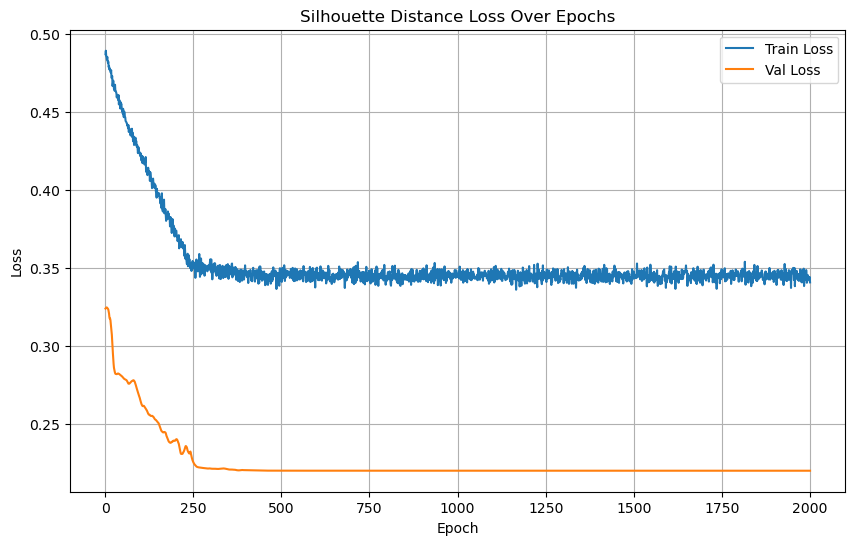

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/46], Loss: 0.1832
Test Batch [20/46], Loss: 0.2159


Test Batch [30/46], Loss: 0.2961
Test Batch [40/46], Loss: 0.2399

Test Loss: 0.2394


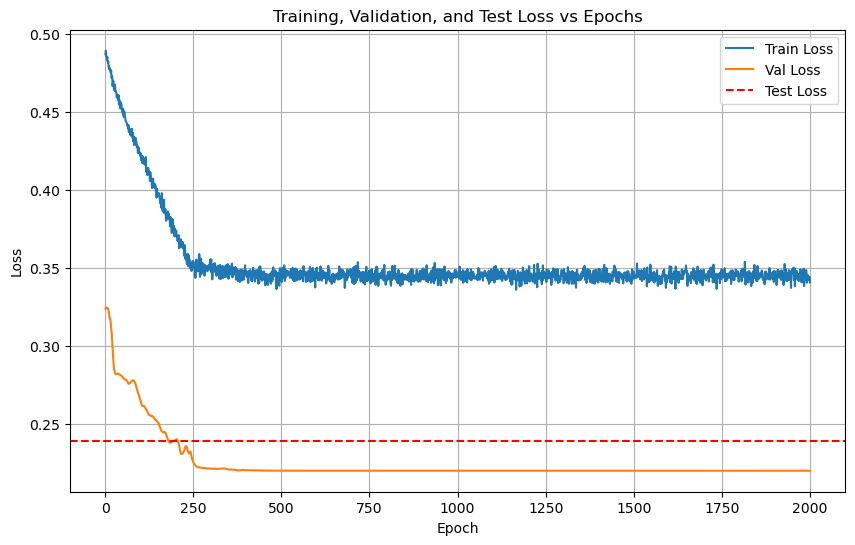

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/46 for test dataset.
  Processed batch 20/46 for test dataset.


  Processed batch 30/46 for test dataset.


  Processed batch 40/46 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       1.00      0.60      0.75         5
           5       0.50      0.40      0.44         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       0.60      0.60      0.60         5
           9       0.80      0.80      0.80         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7068  |  Val Loss: 2.6826
Validation loss improved from inf to 2.6826.
[Epoch 2/1000] Train Loss: 2.6695  |  Val Loss: 2.6465
Validation loss improved from 2.6826 to 2.6465.
[Epoch 3/1000] Train Loss: 2.6339  |  Val Loss: 2.6130
Validation loss improved from 2.6465 to 2.6130.
[Epoch 4/1000] Train Loss: 2.6014  |  Val Loss: 2.5818
Validation loss improved from 2.6130 to 2.5818.
[Epoch 5/1000] Train Loss: 2.5726  |  Val Loss: 2.5546
Validation loss improved from 2.5818 to 2.5546.
[Epoch 6/1000] Train Loss: 2.5465  |  Val Loss: 2.5301
Validation loss improved from 2.5546 to 2.5301.
[Epoch 7/1000] Train Loss: 2.5209  |  Val Loss: 2.5067
Validation loss improved from 2.5301 to 2.5067.
[Epoch 8/1000] Train Loss: 2.4979  |  Val Loss: 2.4848
Validation loss improved from 2.5067 to 2.4848.
[Epoch 9/1000] Train Loss: 2.4757  |  Val Loss: 2.4639
Validation loss improved from 2.4848 to 2.4639.


[Epoch 10/1000] Train Loss: 2.4524  |  Val Loss: 2.4426
Validation loss improved from 2.4639 to 2.4426.
[Epoch 11/1000] Train Loss: 2.4302  |  Val Loss: 2.4208
Validation loss improved from 2.4426 to 2.4208.
[Epoch 12/1000] Train Loss: 2.4079  |  Val Loss: 2.4005
Validation loss improved from 2.4208 to 2.4005.
[Epoch 13/1000] Train Loss: 2.3858  |  Val Loss: 2.3808
Validation loss improved from 2.4005 to 2.3808.
[Epoch 14/1000] Train Loss: 2.3652  |  Val Loss: 2.3607
Validation loss improved from 2.3808 to 2.3607.
[Epoch 15/1000] Train Loss: 2.3436  |  Val Loss: 2.3411
Validation loss improved from 2.3607 to 2.3411.


[Epoch 16/1000] Train Loss: 2.3234  |  Val Loss: 2.3217
Validation loss improved from 2.3411 to 2.3217.
[Epoch 17/1000] Train Loss: 2.3026  |  Val Loss: 2.3027
Validation loss improved from 2.3217 to 2.3027.
[Epoch 18/1000] Train Loss: 2.2819  |  Val Loss: 2.2839
Validation loss improved from 2.3027 to 2.2839.
[Epoch 19/1000] Train Loss: 2.2614  |  Val Loss: 2.2653
Validation loss improved from 2.2839 to 2.2653.
[Epoch 20/1000] Train Loss: 2.2411  |  Val Loss: 2.2466
Validation loss improved from 2.2653 to 2.2466.
[Epoch 21/1000] Train Loss: 2.2214  |  Val Loss: 2.2281
Validation loss improved from 2.2466 to 2.2281.
[Epoch 22/1000] Train Loss: 2.2003  |  Val Loss: 2.2098
Validation loss improved from 2.2281 to 2.2098.
[Epoch 23/1000] Train Loss: 2.1803  |  Val Loss: 2.1911
Validation loss improved from 2.2098 to 2.1911.
[Epoch 24/1000] Train Loss: 2.1603  |  Val Loss: 2.1723
Validation loss improved from 2.1911 to 2.1723.
[Epoch 25/1000] Train Loss: 2.1395  |  Val Loss: 2.1539
Validati

[Epoch 29/1000] Train Loss: 2.0576  |  Val Loss: 2.0796
Validation loss improved from 2.0985 to 2.0796.
[Epoch 30/1000] Train Loss: 2.0368  |  Val Loss: 2.0606
Validation loss improved from 2.0796 to 2.0606.
[Epoch 31/1000] Train Loss: 2.0157  |  Val Loss: 2.0415
Validation loss improved from 2.0606 to 2.0415.
[Epoch 32/1000] Train Loss: 1.9945  |  Val Loss: 2.0222
Validation loss improved from 2.0415 to 2.0222.
[Epoch 33/1000] Train Loss: 1.9734  |  Val Loss: 2.0027
Validation loss improved from 2.0222 to 2.0027.


[Epoch 34/1000] Train Loss: 1.9518  |  Val Loss: 1.9829
Validation loss improved from 2.0027 to 1.9829.
[Epoch 35/1000] Train Loss: 1.9298  |  Val Loss: 1.9630
Validation loss improved from 1.9829 to 1.9630.
[Epoch 36/1000] Train Loss: 1.9078  |  Val Loss: 1.9429
Validation loss improved from 1.9630 to 1.9429.
[Epoch 37/1000] Train Loss: 1.8854  |  Val Loss: 1.9223
Validation loss improved from 1.9429 to 1.9223.
[Epoch 38/1000] Train Loss: 1.8629  |  Val Loss: 1.9015
Validation loss improved from 1.9223 to 1.9015.
[Epoch 39/1000] Train Loss: 1.8401  |  Val Loss: 1.8806
Validation loss improved from 1.9015 to 1.8806.
[Epoch 40/1000] Train Loss: 1.8169  |  Val Loss: 1.8597
Validation loss improved from 1.8806 to 1.8597.
[Epoch 41/1000] Train Loss: 1.7936  |  Val Loss: 1.8387
Validation loss improved from 1.8597 to 1.8387.
[Epoch 42/1000] Train Loss: 1.7700  |  Val Loss: 1.8176
Validation loss improved from 1.8387 to 1.8176.
[Epoch 43/1000] Train Loss: 1.7465  |  Val Loss: 1.7964
Validati

[Epoch 50/1000] Train Loss: 1.5774  |  Val Loss: 1.6454
Validation loss improved from 1.6674 to 1.6454.
[Epoch 51/1000] Train Loss: 1.5523  |  Val Loss: 1.6234
Validation loss improved from 1.6454 to 1.6234.
[Epoch 52/1000] Train Loss: 1.5276  |  Val Loss: 1.6015
Validation loss improved from 1.6234 to 1.6015.
[Epoch 53/1000] Train Loss: 1.5032  |  Val Loss: 1.5795
Validation loss improved from 1.6015 to 1.5795.


[Epoch 54/1000] Train Loss: 1.4787  |  Val Loss: 1.5573
Validation loss improved from 1.5795 to 1.5573.
[Epoch 55/1000] Train Loss: 1.4542  |  Val Loss: 1.5351
Validation loss improved from 1.5573 to 1.5351.
[Epoch 56/1000] Train Loss: 1.4294  |  Val Loss: 1.5128
Validation loss improved from 1.5351 to 1.5128.
[Epoch 57/1000] Train Loss: 1.4050  |  Val Loss: 1.4903
Validation loss improved from 1.5128 to 1.4903.
[Epoch 58/1000] Train Loss: 1.3800  |  Val Loss: 1.4678
Validation loss improved from 1.4903 to 1.4678.
[Epoch 59/1000] Train Loss: 1.3552  |  Val Loss: 1.4450
Validation loss improved from 1.4678 to 1.4450.
[Epoch 60/1000] Train Loss: 1.3299  |  Val Loss: 1.4224
Validation loss improved from 1.4450 to 1.4224.
[Epoch 61/1000] Train Loss: 1.3048  |  Val Loss: 1.4001
Validation loss improved from 1.4224 to 1.4001.
[Epoch 62/1000] Train Loss: 1.2798  |  Val Loss: 1.3781
Validation loss improved from 1.4001 to 1.3781.
[Epoch 63/1000] Train Loss: 1.2551  |  Val Loss: 1.3561
Validati

[Epoch 69/1000] Train Loss: 1.1106  |  Val Loss: 1.2291
Validation loss improved from 1.2492 to 1.2291.
[Epoch 70/1000] Train Loss: 1.0874  |  Val Loss: 1.2090
Validation loss improved from 1.2291 to 1.2090.
[Epoch 71/1000] Train Loss: 1.0644  |  Val Loss: 1.1891
Validation loss improved from 1.2090 to 1.1891.
[Epoch 72/1000] Train Loss: 1.0413  |  Val Loss: 1.1692
Validation loss improved from 1.1891 to 1.1692.
[Epoch 73/1000] Train Loss: 1.0190  |  Val Loss: 1.1494
Validation loss improved from 1.1692 to 1.1494.
[Epoch 74/1000] Train Loss: 0.9965  |  Val Loss: 1.1299
Validation loss improved from 1.1494 to 1.1299.


[Epoch 75/1000] Train Loss: 0.9740  |  Val Loss: 1.1106
Validation loss improved from 1.1299 to 1.1106.
[Epoch 76/1000] Train Loss: 0.9520  |  Val Loss: 1.0919
Validation loss improved from 1.1106 to 1.0919.
[Epoch 77/1000] Train Loss: 0.9307  |  Val Loss: 1.0741
Validation loss improved from 1.0919 to 1.0741.
[Epoch 78/1000] Train Loss: 0.9098  |  Val Loss: 1.0560
Validation loss improved from 1.0741 to 1.0560.
[Epoch 79/1000] Train Loss: 0.8889  |  Val Loss: 1.0386
Validation loss improved from 1.0560 to 1.0386.
[Epoch 80/1000] Train Loss: 0.8678  |  Val Loss: 1.0217
Validation loss improved from 1.0386 to 1.0217.
[Epoch 81/1000] Train Loss: 0.8478  |  Val Loss: 1.0049
Validation loss improved from 1.0217 to 1.0049.
[Epoch 82/1000] Train Loss: 0.8276  |  Val Loss: 0.9876
Validation loss improved from 1.0049 to 0.9876.
[Epoch 83/1000] Train Loss: 0.8077  |  Val Loss: 0.9704
Validation loss improved from 0.9876 to 0.9704.
[Epoch 84/1000] Train Loss: 0.7884  |  Val Loss: 0.9537
Validati

[Epoch 86/1000] Train Loss: 0.7499  |  Val Loss: 0.9206
Validation loss improved from 0.9369 to 0.9206.
[Epoch 87/1000] Train Loss: 0.7312  |  Val Loss: 0.9048
Validation loss improved from 0.9206 to 0.9048.
[Epoch 88/1000] Train Loss: 0.7131  |  Val Loss: 0.8891
Validation loss improved from 0.9048 to 0.8891.
[Epoch 89/1000] Train Loss: 0.6952  |  Val Loss: 0.8739
Validation loss improved from 0.8891 to 0.8739.
[Epoch 90/1000] Train Loss: 0.6776  |  Val Loss: 0.8591
Validation loss improved from 0.8739 to 0.8591.
[Epoch 91/1000] Train Loss: 0.6601  |  Val Loss: 0.8447
Validation loss improved from 0.8591 to 0.8447.
[Epoch 92/1000] Train Loss: 0.6432  |  Val Loss: 0.8307
Validation loss improved from 0.8447 to 0.8307.
[Epoch 93/1000] Train Loss: 0.6272  |  Val Loss: 0.8170
Validation loss improved from 0.8307 to 0.8170.


[Epoch 94/1000] Train Loss: 0.6114  |  Val Loss: 0.8038
Validation loss improved from 0.8170 to 0.8038.
[Epoch 95/1000] Train Loss: 0.5963  |  Val Loss: 0.7912
Validation loss improved from 0.8038 to 0.7912.
[Epoch 96/1000] Train Loss: 0.5813  |  Val Loss: 0.7788
Validation loss improved from 0.7912 to 0.7788.
[Epoch 97/1000] Train Loss: 0.5669  |  Val Loss: 0.7669
Validation loss improved from 0.7788 to 0.7669.
[Epoch 98/1000] Train Loss: 0.5529  |  Val Loss: 0.7557
Validation loss improved from 0.7669 to 0.7557.
[Epoch 99/1000] Train Loss: 0.5392  |  Val Loss: 0.7449
Validation loss improved from 0.7557 to 0.7449.
[Epoch 100/1000] Train Loss: 0.5257  |  Val Loss: 0.7346
Validation loss improved from 0.7449 to 0.7346.
[Epoch 101/1000] Train Loss: 0.5130  |  Val Loss: 0.7244
Validation loss improved from 0.7346 to 0.7244.
[Epoch 102/1000] Train Loss: 0.5009  |  Val Loss: 0.7148
Validation loss improved from 0.7244 to 0.7148.
[Epoch 103/1000] Train Loss: 0.4886  |  Val Loss: 0.7054
Vali

[Epoch 105/1000] Train Loss: 0.4661  |  Val Loss: 0.6879
Validation loss improved from 0.6969 to 0.6879.
[Epoch 106/1000] Train Loss: 0.4552  |  Val Loss: 0.6788
Validation loss improved from 0.6879 to 0.6788.
[Epoch 107/1000] Train Loss: 0.4451  |  Val Loss: 0.6700
Validation loss improved from 0.6788 to 0.6700.
[Epoch 108/1000] Train Loss: 0.4346  |  Val Loss: 0.6614
Validation loss improved from 0.6700 to 0.6614.
[Epoch 109/1000] Train Loss: 0.4252  |  Val Loss: 0.6534
Validation loss improved from 0.6614 to 0.6534.
[Epoch 110/1000] Train Loss: 0.4158  |  Val Loss: 0.6455
Validation loss improved from 0.6534 to 0.6455.
[Epoch 111/1000] Train Loss: 0.4069  |  Val Loss: 0.6379
Validation loss improved from 0.6455 to 0.6379.
[Epoch 112/1000] Train Loss: 0.3980  |  Val Loss: 0.6312
Validation loss improved from 0.6379 to 0.6312.


[Epoch 113/1000] Train Loss: 0.3897  |  Val Loss: 0.6248
Validation loss improved from 0.6312 to 0.6248.
[Epoch 114/1000] Train Loss: 0.3817  |  Val Loss: 0.6191
Validation loss improved from 0.6248 to 0.6191.
[Epoch 115/1000] Train Loss: 0.3737  |  Val Loss: 0.6136
Validation loss improved from 0.6191 to 0.6136.
[Epoch 116/1000] Train Loss: 0.3665  |  Val Loss: 0.6083
Validation loss improved from 0.6136 to 0.6083.
[Epoch 117/1000] Train Loss: 0.3591  |  Val Loss: 0.6029
Validation loss improved from 0.6083 to 0.6029.
[Epoch 118/1000] Train Loss: 0.3521  |  Val Loss: 0.5978
Validation loss improved from 0.6029 to 0.5978.
[Epoch 119/1000] Train Loss: 0.3458  |  Val Loss: 0.5922
Validation loss improved from 0.5978 to 0.5922.
[Epoch 120/1000] Train Loss: 0.3390  |  Val Loss: 0.5867
Validation loss improved from 0.5922 to 0.5867.
[Epoch 121/1000] Train Loss: 0.3327  |  Val Loss: 0.5818
Validation loss improved from 0.5867 to 0.5818.
[Epoch 122/1000] Train Loss: 0.3263  |  Val Loss: 0.576

[Epoch 123/1000] Train Loss: 0.3206  |  Val Loss: 0.5721
Validation loss improved from 0.5766 to 0.5721.
[Epoch 124/1000] Train Loss: 0.3147  |  Val Loss: 0.5681
Validation loss improved from 0.5721 to 0.5681.
[Epoch 125/1000] Train Loss: 0.3092  |  Val Loss: 0.5638
Validation loss improved from 0.5681 to 0.5638.
[Epoch 126/1000] Train Loss: 0.3037  |  Val Loss: 0.5593
Validation loss improved from 0.5638 to 0.5593.
[Epoch 127/1000] Train Loss: 0.2983  |  Val Loss: 0.5549
Validation loss improved from 0.5593 to 0.5549.
[Epoch 128/1000] Train Loss: 0.2934  |  Val Loss: 0.5505
Validation loss improved from 0.5549 to 0.5505.
[Epoch 129/1000] Train Loss: 0.2886  |  Val Loss: 0.5464
Validation loss improved from 0.5505 to 0.5464.
[Epoch 130/1000] Train Loss: 0.2836  |  Val Loss: 0.5430
Validation loss improved from 0.5464 to 0.5430.


[Epoch 131/1000] Train Loss: 0.2790  |  Val Loss: 0.5397
Validation loss improved from 0.5430 to 0.5397.
[Epoch 132/1000] Train Loss: 0.2744  |  Val Loss: 0.5368
Validation loss improved from 0.5397 to 0.5368.
[Epoch 133/1000] Train Loss: 0.2702  |  Val Loss: 0.5341
Validation loss improved from 0.5368 to 0.5341.
[Epoch 134/1000] Train Loss: 0.2657  |  Val Loss: 0.5309
Validation loss improved from 0.5341 to 0.5309.
[Epoch 135/1000] Train Loss: 0.2616  |  Val Loss: 0.5278
Validation loss improved from 0.5309 to 0.5278.
[Epoch 136/1000] Train Loss: 0.2577  |  Val Loss: 0.5251
Validation loss improved from 0.5278 to 0.5251.
[Epoch 137/1000] Train Loss: 0.2539  |  Val Loss: 0.5216
Validation loss improved from 0.5251 to 0.5216.
[Epoch 138/1000] Train Loss: 0.2501  |  Val Loss: 0.5192
Validation loss improved from 0.5216 to 0.5192.
[Epoch 139/1000] Train Loss: 0.2464  |  Val Loss: 0.5170
Validation loss improved from 0.5192 to 0.5170.
[Epoch 140/1000] Train Loss: 0.2428  |  Val Loss: 0.514

[Epoch 142/1000] Train Loss: 0.2361  |  Val Loss: 0.5097
Validation loss improved from 0.5117 to 0.5097.
[Epoch 143/1000] Train Loss: 0.2329  |  Val Loss: 0.5084
Validation loss improved from 0.5097 to 0.5084.
[Epoch 144/1000] Train Loss: 0.2296  |  Val Loss: 0.5067
Validation loss improved from 0.5084 to 0.5067.
[Epoch 145/1000] Train Loss: 0.2267  |  Val Loss: 0.5050
Validation loss improved from 0.5067 to 0.5050.
[Epoch 146/1000] Train Loss: 0.2236  |  Val Loss: 0.5025
Validation loss improved from 0.5050 to 0.5025.
[Epoch 147/1000] Train Loss: 0.2206  |  Val Loss: 0.5007
Validation loss improved from 0.5025 to 0.5007.
[Epoch 148/1000] Train Loss: 0.2177  |  Val Loss: 0.4989
Validation loss improved from 0.5007 to 0.4989.
[Epoch 149/1000] Train Loss: 0.2150  |  Val Loss: 0.4972
Validation loss improved from 0.4989 to 0.4972.


[Epoch 150/1000] Train Loss: 0.2122  |  Val Loss: 0.4958
Validation loss improved from 0.4972 to 0.4958.
[Epoch 151/1000] Train Loss: 0.2094  |  Val Loss: 0.4943
Validation loss improved from 0.4958 to 0.4943.
[Epoch 152/1000] Train Loss: 0.2066  |  Val Loss: 0.4914
Validation loss improved from 0.4943 to 0.4914.
[Epoch 153/1000] Train Loss: 0.2041  |  Val Loss: 0.4891
Validation loss improved from 0.4914 to 0.4891.
[Epoch 154/1000] Train Loss: 0.2015  |  Val Loss: 0.4870
Validation loss improved from 0.4891 to 0.4870.
[Epoch 155/1000] Train Loss: 0.1991  |  Val Loss: 0.4855
Validation loss improved from 0.4870 to 0.4855.
[Epoch 156/1000] Train Loss: 0.1965  |  Val Loss: 0.4836
Validation loss improved from 0.4855 to 0.4836.
[Epoch 157/1000] Train Loss: 0.1942  |  Val Loss: 0.4822
Validation loss improved from 0.4836 to 0.4822.
[Epoch 158/1000] Train Loss: 0.1918  |  Val Loss: 0.4812
Validation loss improved from 0.4822 to 0.4812.
[Epoch 159/1000] Train Loss: 0.1896  |  Val Loss: 0.479

[Epoch 160/1000] Train Loss: 0.1876  |  Val Loss: 0.4777
Validation loss improved from 0.4798 to 0.4777.
[Epoch 161/1000] Train Loss: 0.1853  |  Val Loss: 0.4767
Validation loss improved from 0.4777 to 0.4767.
[Epoch 162/1000] Train Loss: 0.1833  |  Val Loss: 0.4761
Validation loss improved from 0.4767 to 0.4761.
[Epoch 163/1000] Train Loss: 0.1812  |  Val Loss: 0.4749
Validation loss improved from 0.4761 to 0.4749.
[Epoch 164/1000] Train Loss: 0.1792  |  Val Loss: 0.4737
Validation loss improved from 0.4749 to 0.4737.
[Epoch 165/1000] Train Loss: 0.1771  |  Val Loss: 0.4728
Validation loss improved from 0.4737 to 0.4728.
[Epoch 166/1000] Train Loss: 0.1753  |  Val Loss: 0.4725
Validation loss improved from 0.4728 to 0.4725.


[Epoch 167/1000] Train Loss: 0.1735  |  Val Loss: 0.4711
Validation loss improved from 0.4725 to 0.4711.
[Epoch 168/1000] Train Loss: 0.1718  |  Val Loss: 0.4699
Validation loss improved from 0.4711 to 0.4699.
[Epoch 169/1000] Train Loss: 0.1700  |  Val Loss: 0.4681
Validation loss improved from 0.4699 to 0.4681.
[Epoch 170/1000] Train Loss: 0.1681  |  Val Loss: 0.4668
Validation loss improved from 0.4681 to 0.4668.
[Epoch 171/1000] Train Loss: 0.1666  |  Val Loss: 0.4655
Validation loss improved from 0.4668 to 0.4655.
[Epoch 172/1000] Train Loss: 0.1648  |  Val Loss: 0.4650
Validation loss improved from 0.4655 to 0.4650.
[Epoch 173/1000] Train Loss: 0.1632  |  Val Loss: 0.4644
Validation loss improved from 0.4650 to 0.4644.
[Epoch 174/1000] Train Loss: 0.1615  |  Val Loss: 0.4624
Validation loss improved from 0.4644 to 0.4624.
[Epoch 175/1000] Train Loss: 0.1600  |  Val Loss: 0.4599
Validation loss improved from 0.4624 to 0.4599.
[Epoch 176/1000] Train Loss: 0.1584  |  Val Loss: 0.458

[Epoch 179/1000] Train Loss: 0.1537  |  Val Loss: 0.4558
Validation loss improved from 0.4560 to 0.4558.
[Epoch 180/1000] Train Loss: 0.1523  |  Val Loss: 0.4553
Validation loss improved from 0.4558 to 0.4553.
[Epoch 181/1000] Train Loss: 0.1510  |  Val Loss: 0.4548
Validation loss improved from 0.4553 to 0.4548.
[Epoch 182/1000] Train Loss: 0.1494  |  Val Loss: 0.4535
Validation loss improved from 0.4548 to 0.4535.
[Epoch 183/1000] Train Loss: 0.1481  |  Val Loss: 0.4527
Validation loss improved from 0.4535 to 0.4527.
[Epoch 184/1000] Train Loss: 0.1471  |  Val Loss: 0.4515
Validation loss improved from 0.4527 to 0.4515.
[Epoch 185/1000] Train Loss: 0.1455  |  Val Loss: 0.4513
Validation loss improved from 0.4515 to 0.4513.


[Epoch 186/1000] Train Loss: 0.1441  |  Val Loss: 0.4512
Validation loss improved from 0.4513 to 0.4512.
[Epoch 187/1000] Train Loss: 0.1430  |  Val Loss: 0.4504
Validation loss improved from 0.4512 to 0.4504.
[Epoch 188/1000] Train Loss: 0.1417  |  Val Loss: 0.4502
Validation loss improved from 0.4504 to 0.4502.
[Epoch 189/1000] Train Loss: 0.1404  |  Val Loss: 0.4497
Validation loss improved from 0.4502 to 0.4497.
[Epoch 190/1000] Train Loss: 0.1392  |  Val Loss: 0.4486
Validation loss improved from 0.4497 to 0.4486.
[Epoch 191/1000] Train Loss: 0.1379  |  Val Loss: 0.4471
Validation loss improved from 0.4486 to 0.4471.
[Epoch 192/1000] Train Loss: 0.1367  |  Val Loss: 0.4466
Validation loss improved from 0.4471 to 0.4466.
[Epoch 193/1000] Train Loss: 0.1356  |  Val Loss: 0.4463
Validation loss improved from 0.4466 to 0.4463.
[Epoch 194/1000] Train Loss: 0.1345  |  Val Loss: 0.4460
Validation loss improved from 0.4463 to 0.4460.
[Epoch 195/1000] Train Loss: 0.1333  |  Val Loss: 0.445

[Epoch 199/1000] Train Loss: 0.1290  |  Val Loss: 0.4412
Validation loss improved from 0.4417 to 0.4412.
[Epoch 200/1000] Train Loss: 0.1279  |  Val Loss: 0.4409
Validation loss improved from 0.4412 to 0.4409.
[Epoch 201/1000] Train Loss: 0.1269  |  Val Loss: 0.4411
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 202/1000] Train Loss: 0.1260  |  Val Loss: 0.4414
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 203/1000] Train Loss: 0.1248  |  Val Loss: 0.4417
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 204/1000] Train Loss: 0.1239  |  Val Loss: 0.4412
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 205/1000] Train Loss: 0.1229  |  Val Loss: 0.4404
Validation loss improved from 0.4409 to 0.4404.
[Epoch 206/1000] Train Loss: 0.1220  |  Val Loss: 0.4392
Validation loss improved from 0.4404 to 0.4392.
[Epoch 207/1000] Train Loss: 0.1209  |  Val Loss: 0.4388
Validation loss improved from 0.4392 to 0.4388.
[Epoch 208/1000] Train Loss: 0.1199  |  Val Loss: 0.4379
Validation loss improved from 0.4388 to 0.4379.
[Epoch 209/1000] Train Loss: 0.1190  |  Val Loss: 0.4371
Validation loss improved from 0.4379 to 0.4371.
[Epoch 210/1000] Train Loss: 0.1180  |  Val Loss: 0.4370
Validation loss improved from 0.4371 to 0.4370.
[Epoch 211/1000] Train Loss: 0.1172  |  Val Loss: 0.4367
Validation loss improved from 0.4370 to 0.4367.
[Epoch 212/1000] Train Loss: 0.1162  |  Val Loss: 0.4353
Validation loss improved from 0.4367 to 0.4353.
[Epoch 213/1000] Train Loss: 0.1154  |  Val Loss: 0.4349
Validation loss improved from 0.4353 to 0.4349.
[Epoch 214/1000] Train Loss: 0.1147  |  Val Loss: 0.434

[Epoch 218/1000] Train Loss: 0.1110  |  Val Loss: 0.4310
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 0.1102  |  Val Loss: 0.4304
Validation loss improved from 0.4309 to 0.4304.
[Epoch 220/1000] Train Loss: 0.1094  |  Val Loss: 0.4299
Validation loss improved from 0.4304 to 0.4299.
[Epoch 221/1000] Train Loss: 0.1085  |  Val Loss: 0.4300
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 0.1078  |  Val Loss: 0.4302
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 0.1069  |  Val Loss: 0.4295
Validation loss improved from 0.4299 to 0.4295.


[Epoch 224/1000] Train Loss: 0.1063  |  Val Loss: 0.4295
Validation loss improved from 0.4295 to 0.4295.
[Epoch 225/1000] Train Loss: 0.1053  |  Val Loss: 0.4292
Validation loss improved from 0.4295 to 0.4292.
[Epoch 226/1000] Train Loss: 0.1047  |  Val Loss: 0.4281
Validation loss improved from 0.4292 to 0.4281.
[Epoch 227/1000] Train Loss: 0.1040  |  Val Loss: 0.4272
Validation loss improved from 0.4281 to 0.4272.
[Epoch 228/1000] Train Loss: 0.1032  |  Val Loss: 0.4269
Validation loss improved from 0.4272 to 0.4269.
[Epoch 229/1000] Train Loss: 0.1025  |  Val Loss: 0.4270
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.1019  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 0.1011  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 232/1000] Train Loss: 0.1005  |  Val Loss: 0.4278
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 233/1000] Train Loss: 0.

[Epoch 239/1000] Train Loss: 0.0959  |  Val Loss: 0.4241
Validation loss improved from 0.4242 to 0.4241.
[Epoch 240/1000] Train Loss: 0.0951  |  Val Loss: 0.4235
Validation loss improved from 0.4241 to 0.4235.
[Epoch 241/1000] Train Loss: 0.0945  |  Val Loss: 0.4235
Validation loss improved from 0.4235 to 0.4235.


[Epoch 242/1000] Train Loss: 0.0939  |  Val Loss: 0.4237
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 0.0933  |  Val Loss: 0.4221
Validation loss improved from 0.4235 to 0.4221.
[Epoch 244/1000] Train Loss: 0.0927  |  Val Loss: 0.4218
Validation loss improved from 0.4221 to 0.4218.
[Epoch 245/1000] Train Loss: 0.0921  |  Val Loss: 0.4225
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Train Loss: 0.0914  |  Val Loss: 0.4223
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 247/1000] Train Loss: 0.0908  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 248/1000] Train Loss: 0.0901  |  Val Loss: 0.4227
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 249/1000] Train Loss: 0.0898  |  Val Loss: 0.4237
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 250/1000] Train Loss: 0.0890  |  Val Loss: 0.4232
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 251/10

[Epoch 259/1000] Train Loss: 0.0842  |  Val Loss: 0.4235
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 260/1000] Train Loss: 0.0836  |  Val Loss: 0.4214
Validation loss improved from 0.4215 to 0.4214.
[Epoch 261/1000] Train Loss: 0.0828  |  Val Loss: 0.4206
Validation loss improved from 0.4214 to 0.4206.
[Epoch 262/1000] Train Loss: 0.0823  |  Val Loss: 0.4199
Validation loss improved from 0.4206 to 0.4199.
[Epoch 263/1000] Train Loss: 0.0819  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.0812  |  Val Loss: 0.4193
Validation loss improved from 0.4199 to 0.4193.
[Epoch 265/1000] Train Loss: 0.0808  |  Val Loss: 0.4184
Validation loss improved from 0.4193 to 0.4184.
[Epoch 266/1000] Train Loss: 0.0804  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 267/1000] Train Loss: 0.0798  |  Val Loss: 0.4189
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 268/1000] Train Loss: 0.

[Epoch 278/1000] Train Loss: 0.0749  |  Val Loss: 0.4189
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 279/1000] Train Loss: 0.0741  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 280/1000] Train Loss: 0.0735  |  Val Loss: 0.4197
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 281/1000] Train Loss: 0.0735  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 282/1000] Train Loss: 0.0729  |  Val Loss: 0.4212
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 283/1000] Train Loss: 0.0725  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 284/1000] Train Loss: 0.0719  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 285/1000] Train Loss: 0.0713  |  Val Loss: 0.4178
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 286/1000] Train Loss: 0.0714  |  Val Loss: 0.4163
Validation loss improved from 0.4171 to 0.4163.
[Ep

[Epoch 297/1000] Train Loss: 0.0668  |  Val Loss: 0.4151
Validation loss improved from 0.4152 to 0.4151.
[Epoch 298/1000] Train Loss: 0.0663  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 299/1000] Train Loss: 0.0661  |  Val Loss: 0.4162
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 300/1000] Train Loss: 0.0657  |  Val Loss: 0.4160
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 301/1000] Train Loss: 0.0652  |  Val Loss: 0.4159
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 302/1000] Train Loss: 0.0648  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 303/1000] Train Loss: 0.0643  |  Val Loss: 0.4147
Validation loss improved from 0.4151 to 0.4147.
[Epoch 304/1000] Train Loss: 0.0640  |  Val Loss: 0.4145
Validation loss improved from 0.4147 to 0.4145.
[Epoch 305/1000] Train Loss: 0.0636  |  Val Loss: 0.4147
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 306/1000] Tr

[Epoch 315/1000] Train Loss: 0.0602  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 316/1000] Train Loss: 0.0598  |  Val Loss: 0.4157
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 317/1000] Train Loss: 0.0595  |  Val Loss: 0.4147
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 318/1000] Train Loss: 0.0591  |  Val Loss: 0.4141
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 319/1000] Train Loss: 0.0589  |  Val Loss: 0.4127
Validation loss improved from 0.4129 to 0.4127.
[Epoch 320/1000] Train Loss: 0.0586  |  Val Loss: 0.4116
Validation loss improved from 0.4127 to 0.4116.
[Epoch 321/1000] Train Loss: 0.0583  |  Val Loss: 0.4118
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.0581  |  Val Loss: 0.4123
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.0577  |  Val Loss: 0.4138
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/10

[Epoch 334/1000] Train Loss: 0.0540  |  Val Loss: 0.4164
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 335/1000] Train Loss: 0.0537  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 336/1000] Train Loss: 0.0534  |  Val Loss: 0.4135
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 337/1000] Train Loss: 0.0531  |  Val Loss: 0.4123
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 338/1000] Train Loss: 0.0529  |  Val Loss: 0.4120
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 339/1000] Train Loss: 0.0526  |  Val Loss: 0.4118
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 340/1000] Train Loss: 0.0522  |  Val Loss: 0.4134
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 341/1000] Train Loss: 0.0520  |  Val Loss: 0.4149
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 342/1000] Train Loss: 0.0518  |  Val Loss: 0.4137
!! Validation loss did NOT improve !! Patience:

[Epoch 352/1000] Train Loss: 0.0485  |  Val Loss: 0.4138
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 353/1000] Train Loss: 0.0482  |  Val Loss: 0.4143
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 354/1000] Train Loss: 0.0479  |  Val Loss: 0.4145
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 355/1000] Train Loss: 0.0475  |  Val Loss: 0.4146
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 356/1000] Train Loss: 0.0473  |  Val Loss: 0.4138
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 357/1000] Train Loss: 0.0470  |  Val Loss: 0.4144
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 358/1000] Train Loss: 0.0467  |  Val Loss: 0.4145
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 359/1000] Train Loss: 0.0465  |  Val Loss: 0.4151
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 360/1000] Train Loss: 0.0463  |  Val Loss: 0.4158
!! Validation loss did NOT improve !! Patience:

[Epoch 370/1000] Train Loss: 0.0436  |  Val Loss: 0.4148
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 371/1000] Train Loss: 0.0432  |  Val Loss: 0.4140
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 372/1000] Train Loss: 0.0429  |  Val Loss: 0.4141
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 373/1000] Train Loss: 0.0428  |  Val Loss: 0.4133
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 374/1000] Train Loss: 0.0426  |  Val Loss: 0.4140
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 375/1000] Train Loss: 0.0423  |  Val Loss: 0.4129
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 376/1000] Train Loss: 0.0419  |  Val Loss: 0.4122
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 377/1000] Train Loss: 0.0417  |  Val Loss: 0.4127
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 378/1000] Train Loss: 0.0415  |  Val Loss: 0.4127
!! Validation loss did NOT improve !! Patience:

[Epoch 389/1000] Train Loss: 0.0389  |  Val Loss: 0.4139
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 390/1000] Train Loss: 0.0387  |  Val Loss: 0.4135
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 391/1000] Train Loss: 0.0384  |  Val Loss: 0.4142
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 392/1000] Train Loss: 0.0383  |  Val Loss: 0.4157
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 393/1000] Train Loss: 0.0380  |  Val Loss: 0.4170
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 394/1000] Train Loss: 0.0379  |  Val Loss: 0.4182
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 395/1000] Train Loss: 0.0377  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 396/1000] Train Loss: 0.0375  |  Val Loss: 0.4182
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 397/1000] Train Loss: 0.0373  |  Val Loss: 0.4185
!! Validation loss did NOT improve !! Patience:

[Epoch 408/1000] Train Loss: 0.0349  |  Val Loss: 0.4162
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 409/1000] Train Loss: 0.0347  |  Val Loss: 0.4157
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 410/1000] Train Loss: 0.0344  |  Val Loss: 0.4157
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 411/1000] Train Loss: 0.0341  |  Val Loss: 0.4160
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 412/1000] Train Loss: 0.0341  |  Val Loss: 0.4172
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 413/1000] Train Loss: 0.0340  |  Val Loss: 0.4175
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 414/1000] Train Loss: 0.0338  |  Val Loss: 0.4177
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 415/1000] Train Loss: 0.0336  |  Val Loss: 0.4169
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 416/1000] Train Loss: 0.0334  |  Val Loss: 0.4168
!! Validation loss did NOT improve !! Patience:

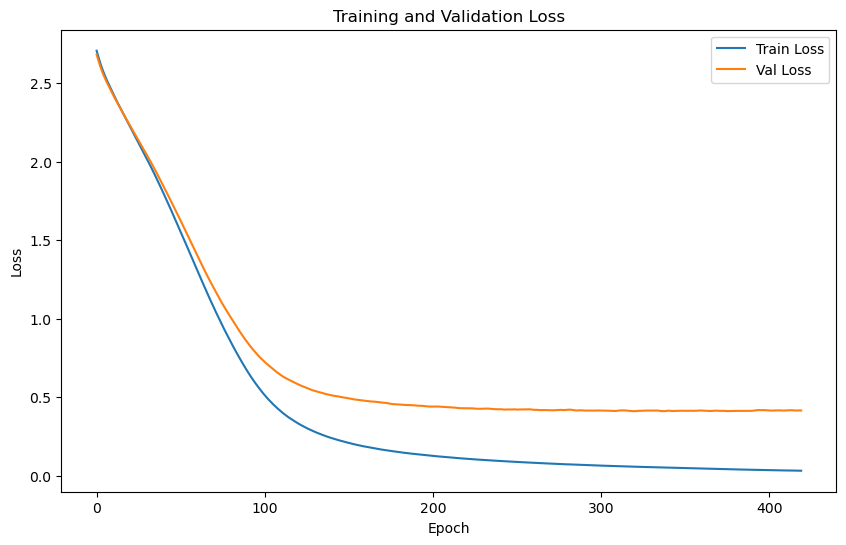

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3262 | Test Accuracy: 88.82%


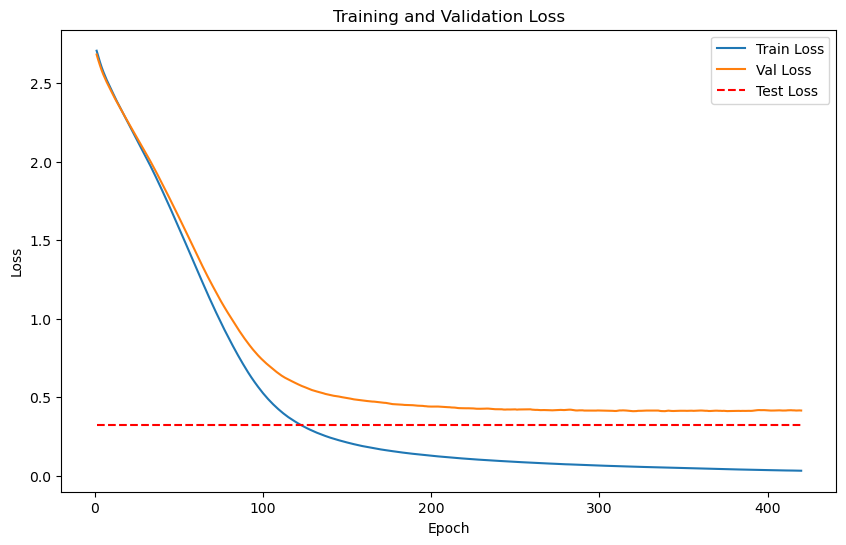

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


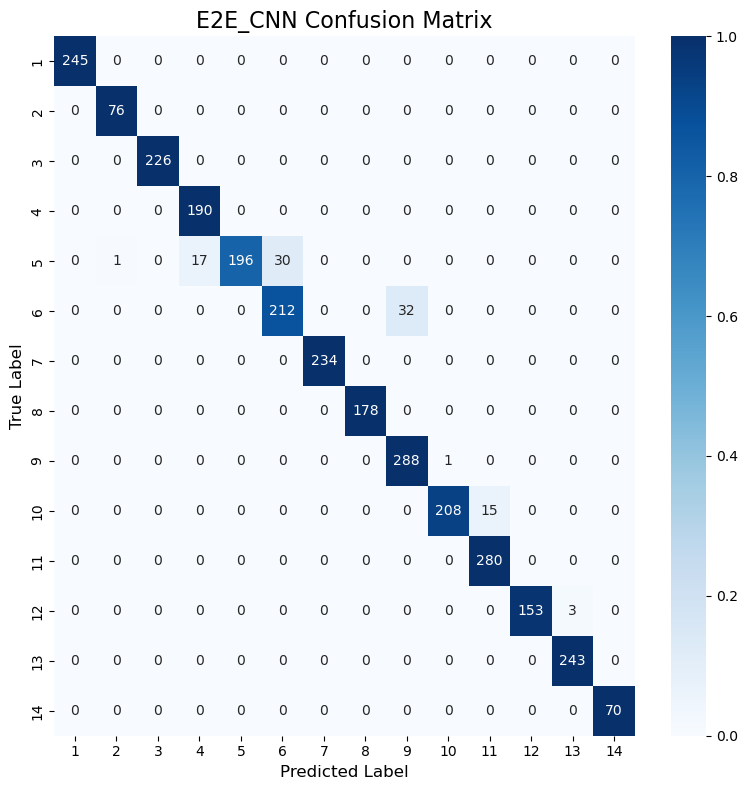

Classification Accuracy: 96.58%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


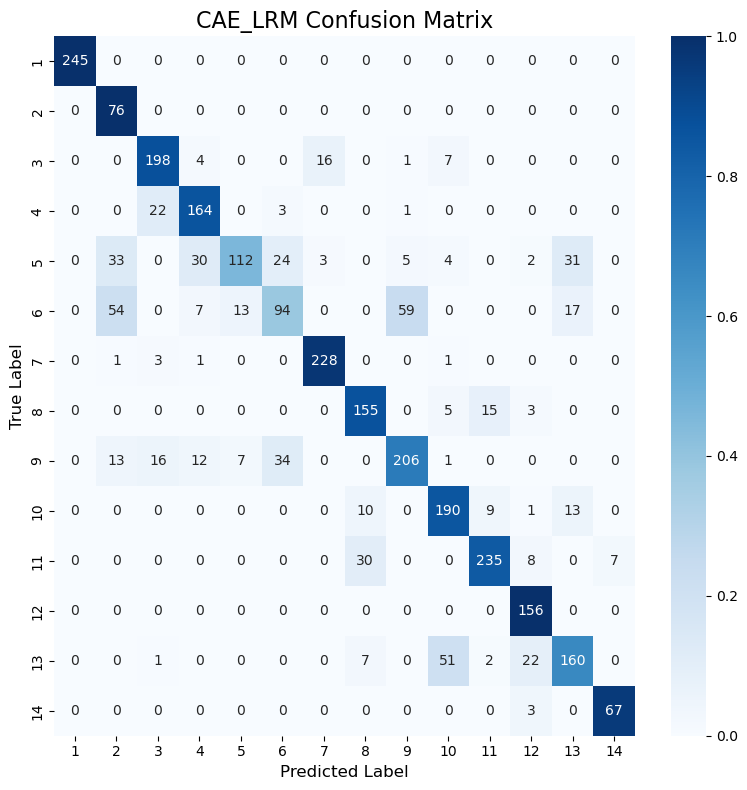

Classification Accuracy: 78.88%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


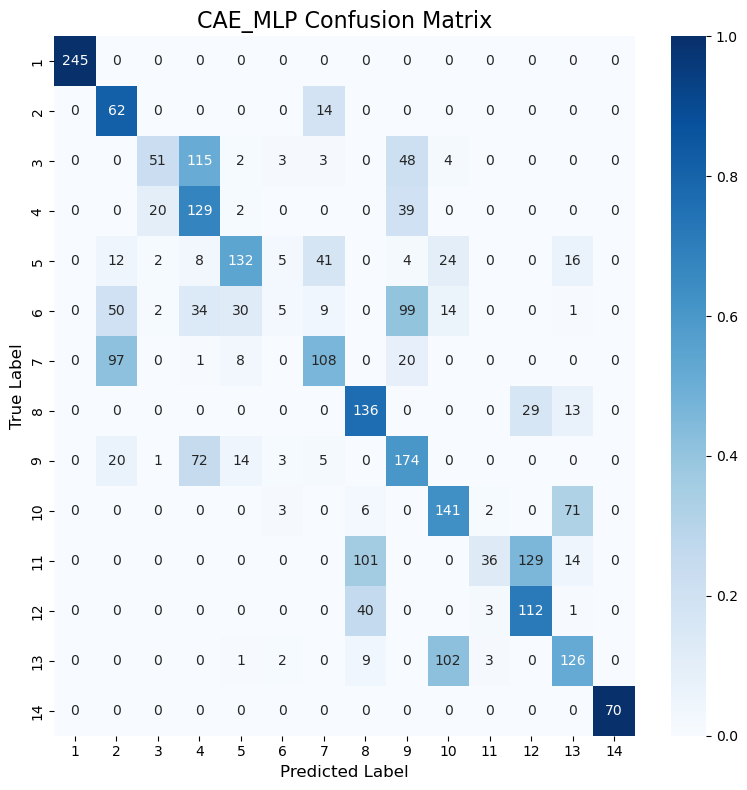

Classification Accuracy: 52.69%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


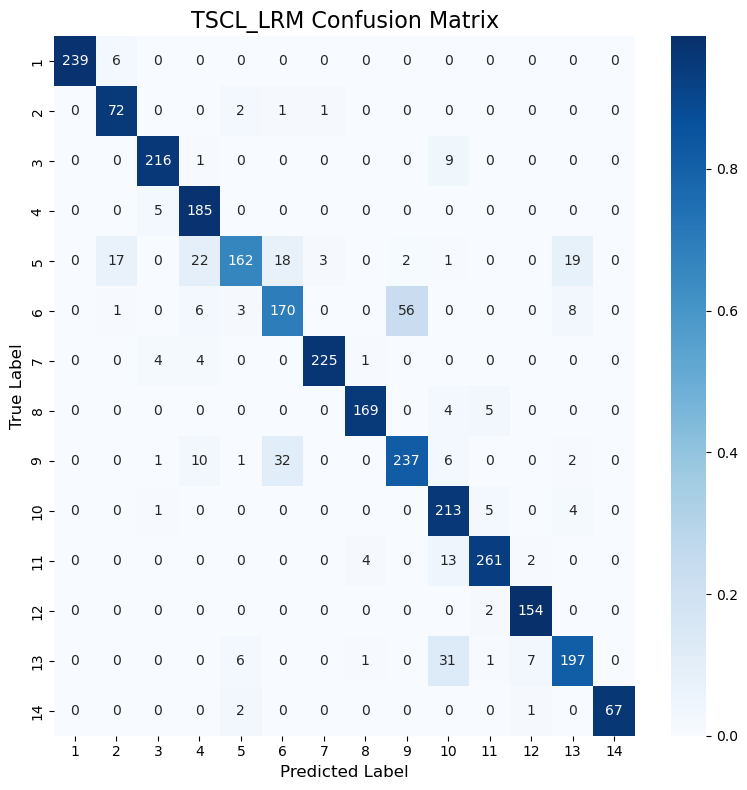

Classification Accuracy: 88.58%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


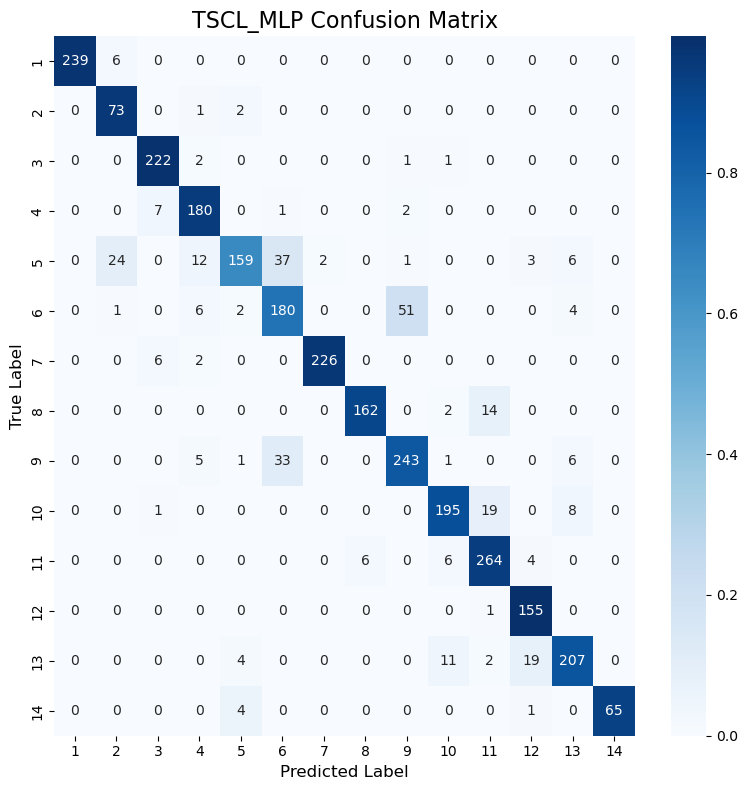

Classification Accuracy: 88.68%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


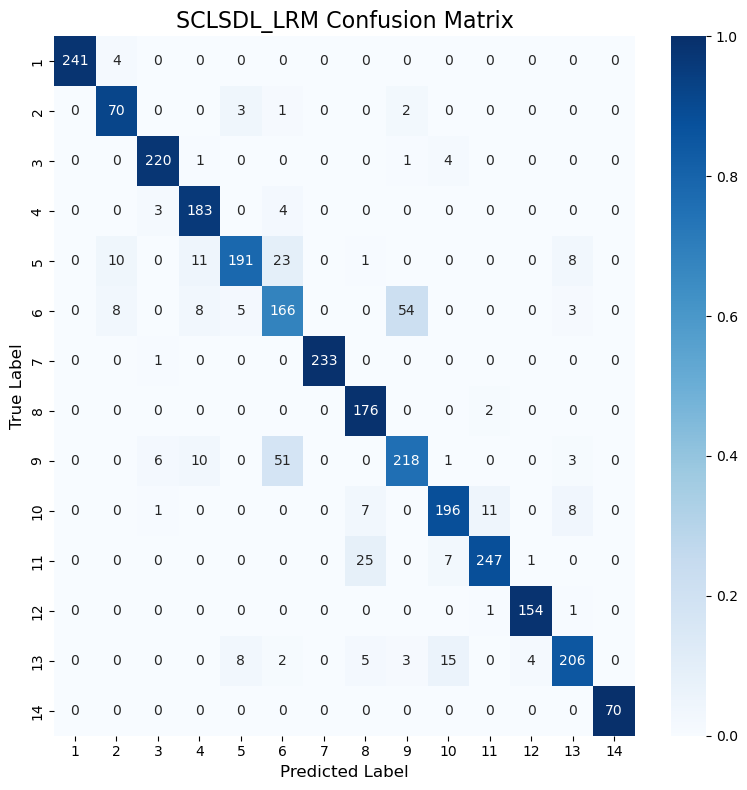

Classification Accuracy: 88.72%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


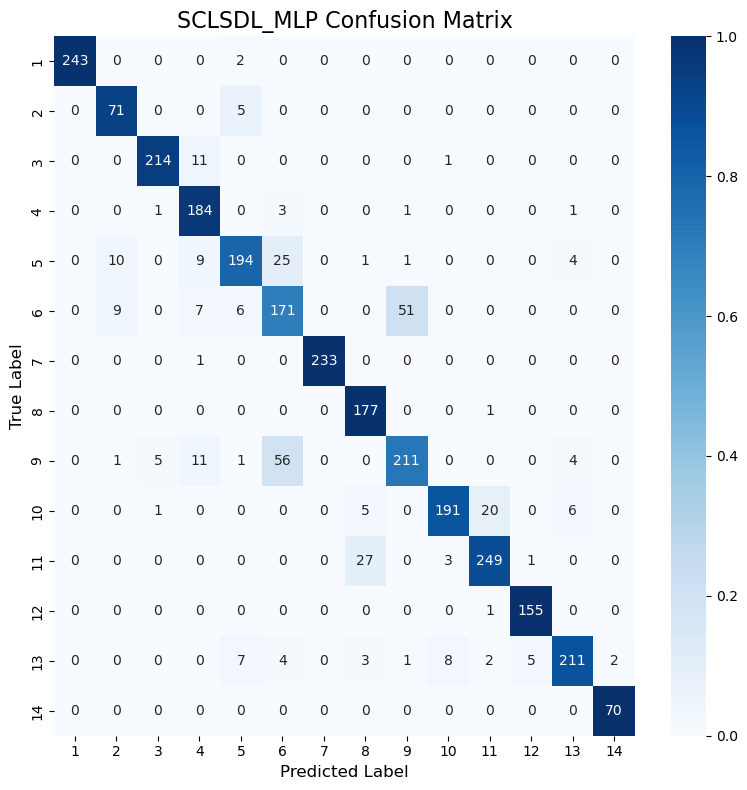

Classification Accuracy: 88.82%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          96.58
1    LRM (CAE)          78.88
2    MLP (CAE)          52.69
3     TSCL LRM          88.58
4     TSCL MLP          88.68
5  SCL_SDL LRM          88.72
6  SCL_SDL MLP          88.82

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          96.58
6  SCL_SDL MLP          88.82
5  SCL_SDL LRM          88.72
4     TSCL MLP          88.68
3     TSCL LRM          88.58
1    LRM (CAE)          78.88
2    MLP (CAE)          52.69
